In [2]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import IterWholeFirst
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random

In [2]:
!nvidia-smi

Sat Mar 30 17:28:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   36C    P0             58W /  300W |   32303MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!export CUDA_VISIBLE_DEVICES=2

In [4]:
# data_set = BallDataset()
# data_set = BallDataset(output_first=True)
# data_set = BallDataset(is_previous=False)
# data_set = BallDataset("ellipse/uniform_samples_80.json")
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
# data_set = DAVIS_Seq2(is_one_video=True)
test_set = Balltest("ellipse/uniform_samples_80.json")
# test_set = Balltest()

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([0]), tensor([1]))

Text(0.5, 1.0, 'First Frame in test set')

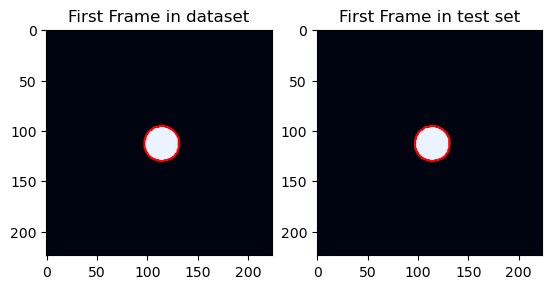

In [6]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(first_frame[index].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in dataset")
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(test_set[0][0].permute(1, 2, 0)))
plt.plot(first_boundary[index][:, 0], first_boundary[index][:, 1], 'r')
plt.title("First Frame in test set")

Text(0.5, 1.0, 'Curr Frame')

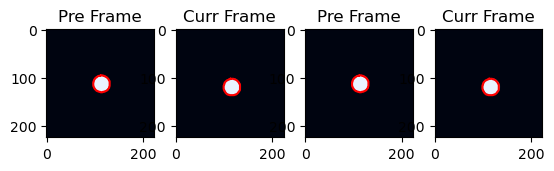

In [7]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')

In [8]:
# model = IterativeModelWithFirst()
# model = IterativeModelWithFirst_Con()
# model = IterativeModelWithFirst_Nei()
model = IterWholeFirst(add_xy_in_token=True, use_unet=True)
# model = IterWholeFirst_Con()

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
model = model.cuda()

results = model(
    first_frame.cuda(), 
    first_boundary.cuda(), 
    pre_frame.cuda(), 
    curr_frame.cuda(), 
    pre_boundary.cuda(), 
)

In [10]:
order_loss(results[0], curr_boundary.cuda())


tensor(8.2753, device='cuda:0', grad_fn=<DivBackward0>)

In [11]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

1.8885498046875

In [12]:
test_set = Balltest("ellipse/uniform_samples_80.json")

In [13]:
class ModelInfer:
    def __init__(
        self,
        test_set: torch.utils.data.Dataset,
        device="cuda",
    ) -> None:
        self.test_set = test_set
        self.device = device
        self.infer_results = {}
    
    def infer_model(self, model: torch.nn.Module):
        model = model.to(self.device)
        def inference_model_at_index(
            model: torch.nn.Module,
            test_dataset: torch.utils.data.Dataset,
            first_index: int,
            end_index: int,
            device="cuda",
        ):
            inference_results = {}
            model = model.to(device)
            model.eval()
            if end_index < first_index:
                step = -1
            else:
                step = 1
            first_img, first_sgm, first_boundary = test_dataset[first_index]
            inference_results[first_index] = first_boundary
            # plt.subplot(10, 4, first_index + 1)
            # plt.imshow(normalize_image(first_img.permute(1, 2, 0)))
            # plt.plot(first_boundary[:, 0], first_boundary[:, 1], "r")
            # plt.axis("off")
            # plt.title(f"Frame {first_index}")
            first_index += step
            pre_boundary = first_boundary
            pre_img = first_img
            # for i in tqdm(range(first_index, end_index + step, step)):
            for i in range(first_index, end_index + step, step):
                curr_img, curr_sgm, curr_boundary = test_dataset[i]
                results = model(
                    first_img.unsqueeze(0).to(device),
                    first_boundary.unsqueeze(0).to(device),
                    pre_img.unsqueeze(0).to(device),
                    curr_img.unsqueeze(0).to(device),
                    pre_boundary.unsqueeze(0).to(device),
                )
                pre_boundary = results[-1].int().squeeze(0).clamp(0, 223)
                inference_results[i] = pre_boundary
                pre_img = curr_img
                # plt.subplot(10, 4, i + 1)
                # plt.imshow(normalize_image(curr_img.squeeze(0).permute(1, 2, 0)))
                # plt.plot(
                #     pre_boundary.cpu().numpy()[:, 0],
                #     pre_boundary.cpu().numpy()[:, 1],
                #     "r",
                # )
                # plt.axis("off")
                # plt.title(f"Frame {i}")
            return inference_results


        def inference_model(
            model: torch.nn.Module,
            test_dataset: torch.utils.data.Dataset,
            device="cuda",
        ):
            inference_results = {}
            for i in range(len(test_dataset)):
                tmp_result1 = inference_model_at_index(model, test_dataset, i, 0, device)
                tmp_result2 = inference_model_at_index(
                    model, test_dataset, i, len(test_dataset) - 1, device
                )
                inference_results[i] = {**tmp_result1, **tmp_result2}
            return inference_results        
        
        self.infer_results = inference_model(model, self.test_set, self.device)

    def show_infer_result(self, index: int):
        total_iou = 0
        plt.figure(figsize=(10, 20))
        for i in range(len(self.test_set)):
            plt.subplot(10, 4, i + 1)
            img, sgm, boundary = self.test_set[i]
            plt.imshow(normalize_image(img.permute(1, 2, 0)))
            plt.plot(
                self.infer_results[index][i].cpu()[:, 0],
                self.infer_results[index][i].cpu()[:, 1],
                "r",
            )
            plt.axis("off")
            plt.title(f"Frame {i}")
            total_iou += get_boundary_iou(
                sgm, self.infer_results[index][i].cpu().numpy()
            )
        plt.show()
        return total_iou / len(self.test_set)
    
    def get_boundary(self, index: int):
        if len(self.infer_results) == 0:
            return self.test_set[index][2]
        else:
            random_index = random.randint(0, len(self.infer_results) - 1)
            return self.infer_results[random_index][index]

In [14]:
model_infer = ModelInfer(test_set)

In [20]:
model_infer.infer_model(model)

KeyboardInterrupt: 

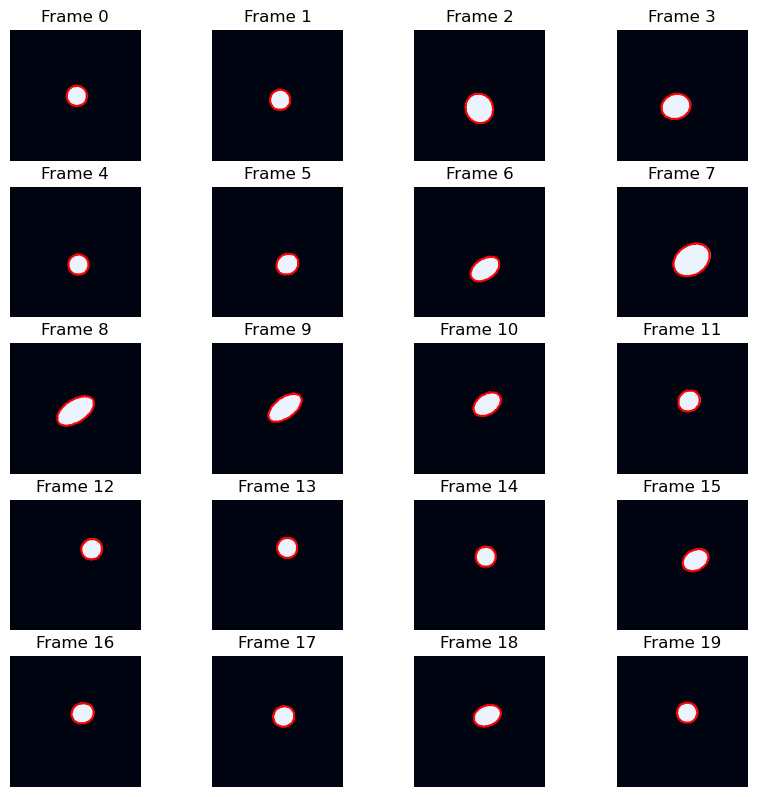

In [19]:
plt.figure(figsize=(10, 20))
for i in range(len(test_set)):
    plt.subplot(10, 4, i + 1)
    img, sgm, boundary = test_set[i]
    plt.imshow(normalize_image(img.permute(1, 2, 0)))
    boundary = model_infer.get_boundary(i)
    plt.plot(boundary.cpu()[:, 0], boundary.cpu()[:, 1], "r")
    plt.axis("off")
    plt.title(f"Frame {i}")

In [21]:
# model = IterativeModelWithFirst().to('cuda')
# model = IterativeModelWithFirst_Con().to('cuda')
# model = IterativeModelWithFirst_Nei().to('cuda')
model = IterWholeFirst(add_xy_in_token=True, use_unet=True).to('cuda')
# model = IterWholeFirst_Con().to('cuda')
model_name = "uniform_model"
model_infer = ModelInfer(test_set)
# data_set = BallDataset(output_first=True)
# data_set = BallDataset("ellipse/uniform_samples_80.json")
data_set = BallDataset("ellipse/uniform_samples_80.json", output_first=True)
# data_set = BallDataset("ellipse/uniform_samples_80.json", is_previous=False)
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [22]:
dict_loss = {}
dict_iou = {}
interval_epochs = 50
interval_num = 155
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
test_set = Balltest("ellipse/uniform_samples_80.json")
model_infer = ModelInfer(test_set)
epoch_index = 0

Epoch 1, Loss: 46.26
Epoch 2, Loss: 39.06
Epoch 3, Loss: 37.11
Epoch 4, Loss: 39.00
Epoch 5, Loss: 39.37
Epoch 6, Loss: 38.48
Epoch 7, Loss: 36.98
Epoch 8, Loss: 37.03
Epoch 9, Loss: 36.59
Epoch 10, Loss: 36.94
Epoch 11, Loss: 36.27
Epoch 12, Loss: 37.26
Epoch 13, Loss: 35.66
Epoch 14, Loss: 34.47
Epoch 15, Loss: 36.97
Epoch 16, Loss: 35.55
Epoch 17, Loss: 36.01
Epoch 18, Loss: 34.26
Epoch 19, Loss: 34.32
Epoch 20, Loss: 32.96
Epoch 21, Loss: 31.15
Epoch 22, Loss: 38.57
Epoch 23, Loss: 36.14
Epoch 24, Loss: 31.51
Epoch 25, Loss: 31.46
Epoch 26, Loss: 32.21
Epoch 27, Loss: 30.54
Epoch 28, Loss: 33.60
Epoch 29, Loss: 29.67
Epoch 30, Loss: 33.01
Epoch 31, Loss: 33.40
Epoch 32, Loss: 29.86
Epoch 33, Loss: 28.69
Epoch 34, Loss: 29.89
Epoch 35, Loss: 30.00
Epoch 36, Loss: 25.69
Epoch 37, Loss: 27.27
Epoch 38, Loss: 27.25
Epoch 39, Loss: 26.85
Epoch 40, Loss: 27.70
Epoch 41, Loss: 26.08
Epoch 42, Loss: 27.88
Epoch 43, Loss: 27.42
Epoch 44, Loss: 24.62
Epoch 45, Loss: 24.12
Epoch 46, Loss: 22.

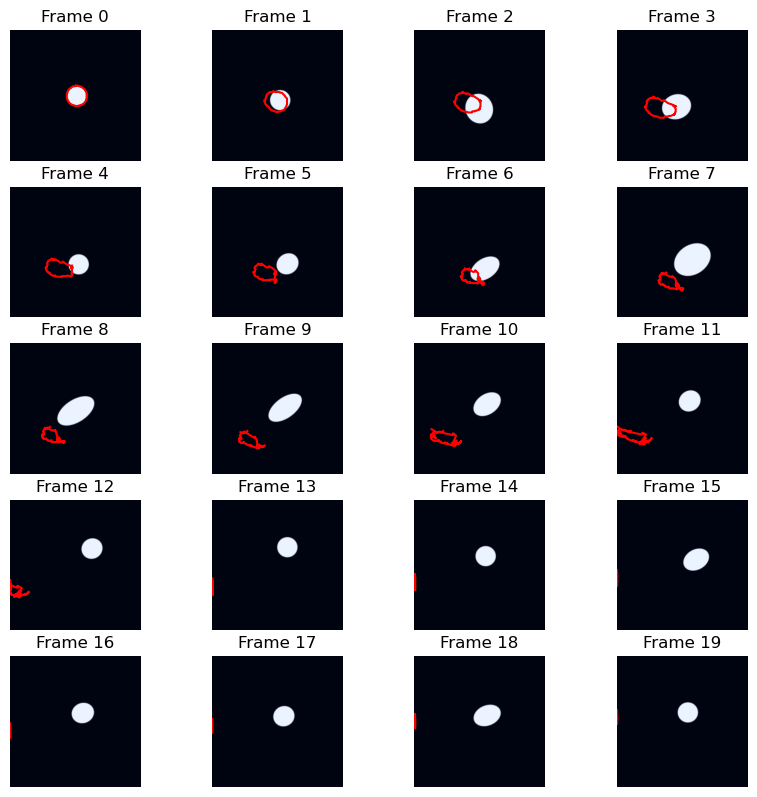

Epoch 50, IOU: 0.108503
Epoch 51, Loss: 158.25
Epoch 52, Loss: 126.45
Epoch 53, Loss: 153.07
Epoch 54, Loss: 125.74
Epoch 55, Loss: 143.63
Epoch 56, Loss: 129.41
Epoch 57, Loss: 126.83
Epoch 58, Loss: 125.91
Epoch 59, Loss: 150.32
Epoch 60, Loss: 147.59
Epoch 61, Loss: 130.96
Epoch 62, Loss: 168.94
Epoch 63, Loss: 135.83
Epoch 64, Loss: 135.89
Epoch 65, Loss: 145.16
Epoch 66, Loss: 110.35
Epoch 67, Loss: 116.15
Epoch 68, Loss: 144.74
Epoch 69, Loss: 196.10
Epoch 70, Loss: 111.20
Epoch 71, Loss: 115.76
Epoch 72, Loss: 143.21
Epoch 73, Loss: 153.56
Epoch 74, Loss: 130.36
Epoch 75, Loss: 137.46
Epoch 76, Loss: 155.14
Epoch 77, Loss: 108.32
Epoch 78, Loss: 130.90
Epoch 79, Loss: 125.48
Epoch 80, Loss: 147.61
Epoch 81, Loss: 123.41
Epoch 82, Loss: 115.29
Epoch 83, Loss: 143.08
Epoch 84, Loss: 128.32
Epoch 85, Loss: 137.46
Epoch 86, Loss: 150.30
Epoch 87, Loss: 126.28
Epoch 88, Loss: 94.54
Epoch 89, Loss: 147.30
Epoch 90, Loss: 117.87
Epoch 91, Loss: 132.54
Epoch 92, Loss: 107.00
Epoch 93, L

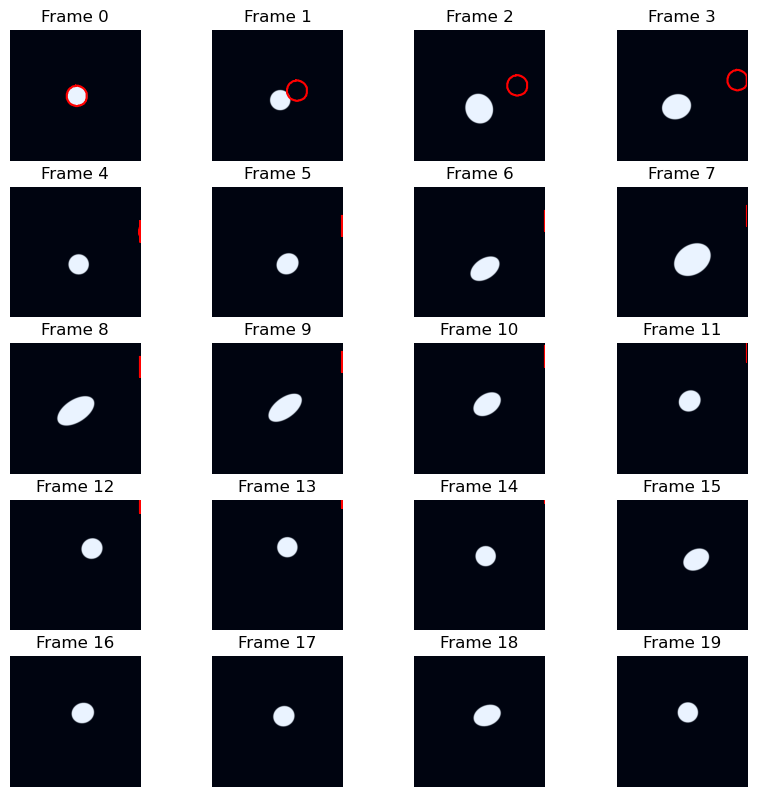

Epoch 95, IOU: 0.050361
Epoch 96, Loss: 366.06
Epoch 97, Loss: 367.51
Epoch 98, Loss: 276.89
Epoch 99, Loss: 203.58
Epoch 100, Loss: 232.28
Epoch 101, Loss: 212.73
Epoch 102, Loss: 203.49
Epoch 103, Loss: 173.63
Epoch 104, Loss: 208.75
Epoch 105, Loss: 196.44
Epoch 106, Loss: 164.29
Epoch 107, Loss: 168.09
Epoch 108, Loss: 166.05
Epoch 109, Loss: 191.16
Epoch 110, Loss: 197.58
Epoch 111, Loss: 176.16
Epoch 112, Loss: 176.11
Epoch 113, Loss: 189.79
Epoch 114, Loss: 212.36
Epoch 115, Loss: 193.08
Epoch 116, Loss: 179.87
Epoch 117, Loss: 182.51
Epoch 118, Loss: 181.49
Epoch 119, Loss: 181.76
Epoch 120, Loss: 181.14
Epoch 121, Loss: 214.98
Epoch 122, Loss: 176.04
Epoch 123, Loss: 184.70
Epoch 124, Loss: 162.18
Epoch 125, Loss: 196.27
Epoch 126, Loss: 174.32
Epoch 127, Loss: 156.57
Epoch 128, Loss: 157.79
Epoch 129, Loss: 153.54
Epoch 130, Loss: 163.00
Epoch 131, Loss: 154.02
Epoch 132, Loss: 162.87
Epoch 133, Loss: 163.42
Epoch 134, Loss: 132.92
Epoch 135, Loss: 149.48


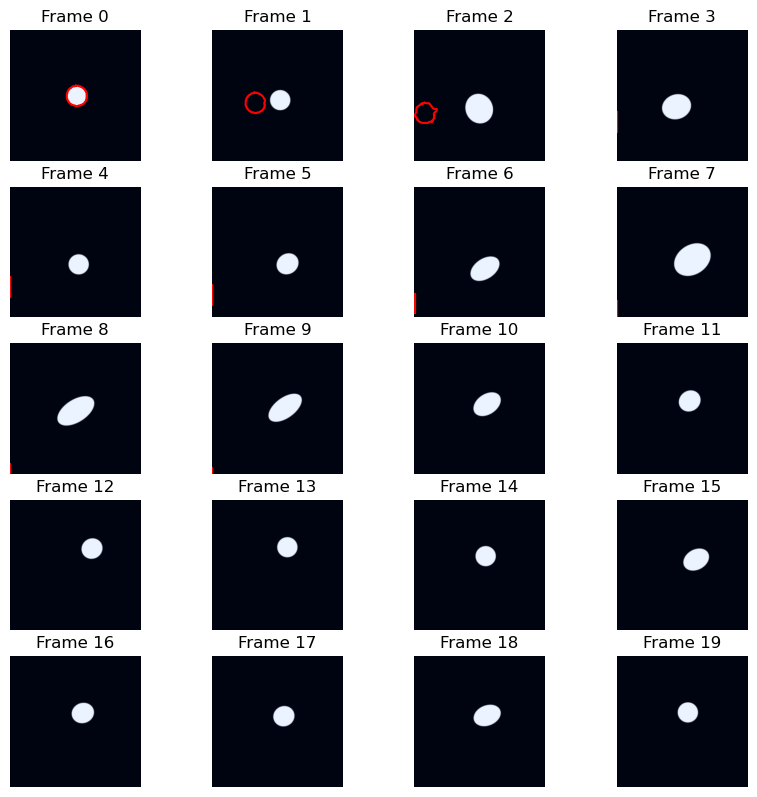

Epoch 135, IOU: 0.049799
Epoch 136, Loss: 279.25
Epoch 137, Loss: 203.22
Epoch 138, Loss: 215.06
Epoch 139, Loss: 210.43
Epoch 140, Loss: 199.46
Epoch 141, Loss: 217.45
Epoch 142, Loss: 200.22
Epoch 143, Loss: 202.74
Epoch 144, Loss: 218.30
Epoch 145, Loss: 179.98
Epoch 146, Loss: 214.14
Epoch 147, Loss: 205.16
Epoch 148, Loss: 206.11
Epoch 149, Loss: 206.45
Epoch 150, Loss: 196.65
Epoch 151, Loss: 220.38
Epoch 152, Loss: 193.77
Epoch 153, Loss: 205.73
Epoch 154, Loss: 190.67
Epoch 155, Loss: 205.45
Epoch 156, Loss: 193.22
Epoch 157, Loss: 194.12
Epoch 158, Loss: 192.53
Epoch 159, Loss: 200.32
Epoch 160, Loss: 218.07
Epoch 161, Loss: 186.18
Epoch 162, Loss: 208.49
Epoch 163, Loss: 235.46
Epoch 164, Loss: 196.64
Epoch 165, Loss: 201.66
Epoch 166, Loss: 212.97
Epoch 167, Loss: 200.14
Epoch 168, Loss: 196.34
Epoch 169, Loss: 196.55
Epoch 170, Loss: 202.23


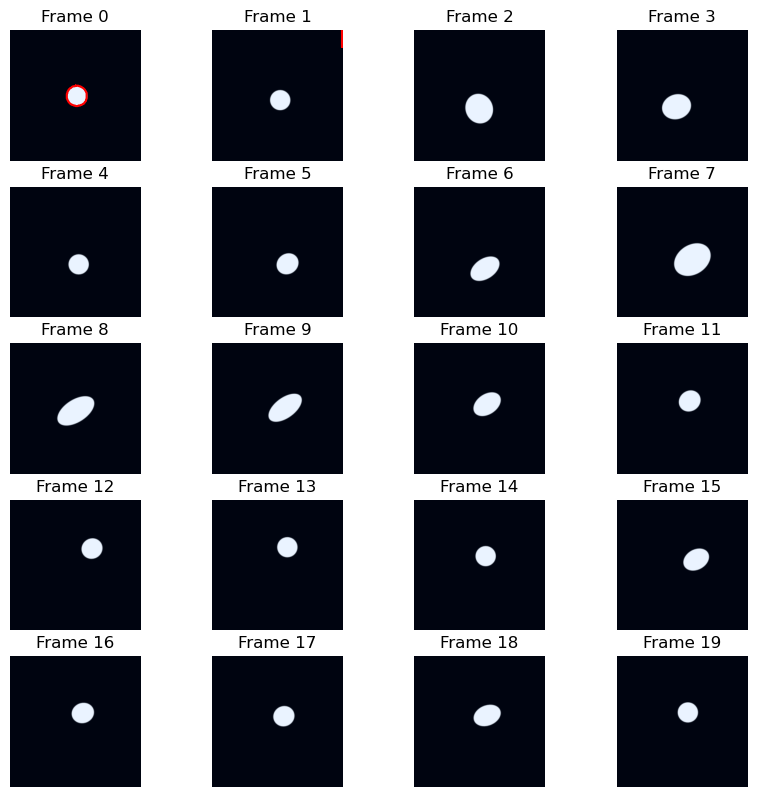

Epoch 170, IOU: 0.049799
Epoch 171, Loss: 356.33
Epoch 172, Loss: 197.51
Epoch 173, Loss: 185.30
Epoch 174, Loss: 167.21
Epoch 175, Loss: 183.01
Epoch 176, Loss: 196.29
Epoch 177, Loss: 182.56
Epoch 178, Loss: 199.12
Epoch 179, Loss: 190.99
Epoch 180, Loss: 167.53
Epoch 181, Loss: 177.84
Epoch 182, Loss: 168.12
Epoch 183, Loss: 167.00
Epoch 184, Loss: 182.18
Epoch 185, Loss: 184.83
Epoch 186, Loss: 166.01
Epoch 187, Loss: 160.98
Epoch 188, Loss: 172.71
Epoch 189, Loss: 210.20
Epoch 190, Loss: 181.17
Epoch 191, Loss: 184.96
Epoch 192, Loss: 184.91
Epoch 193, Loss: 162.93
Epoch 194, Loss: 165.32
Epoch 195, Loss: 204.09
Epoch 196, Loss: 189.45
Epoch 197, Loss: 179.25
Epoch 198, Loss: 162.61
Epoch 199, Loss: 191.47
Epoch 200, Loss: 173.90


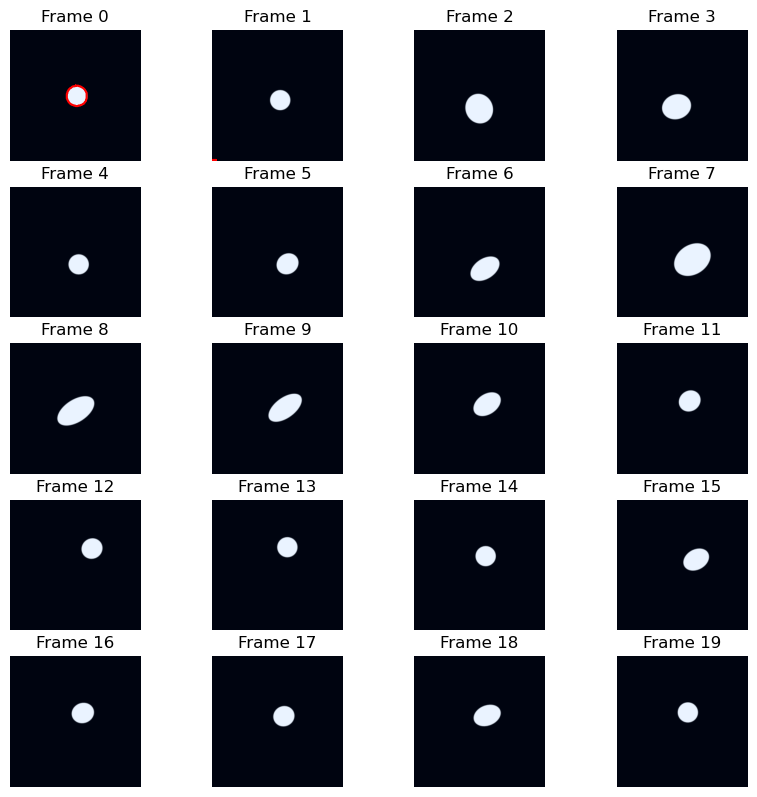

Epoch 200, IOU: 0.049799
Epoch 201, Loss: 651.02
Epoch 202, Loss: 569.82
Epoch 203, Loss: 276.59
Epoch 204, Loss: 231.87
Epoch 205, Loss: 189.55
Epoch 206, Loss: 185.37
Epoch 207, Loss: 193.84
Epoch 208, Loss: 195.47
Epoch 209, Loss: 182.99
Epoch 210, Loss: 238.59
Epoch 211, Loss: 209.69
Epoch 212, Loss: 195.46
Epoch 213, Loss: 181.83
Epoch 214, Loss: 207.56
Epoch 215, Loss: 181.98
Epoch 216, Loss: 179.41
Epoch 217, Loss: 196.59
Epoch 218, Loss: 192.73
Epoch 219, Loss: 179.32
Epoch 220, Loss: 212.05
Epoch 221, Loss: 196.60
Epoch 222, Loss: 213.30
Epoch 223, Loss: 227.42
Epoch 224, Loss: 193.38
Epoch 225, Loss: 206.35


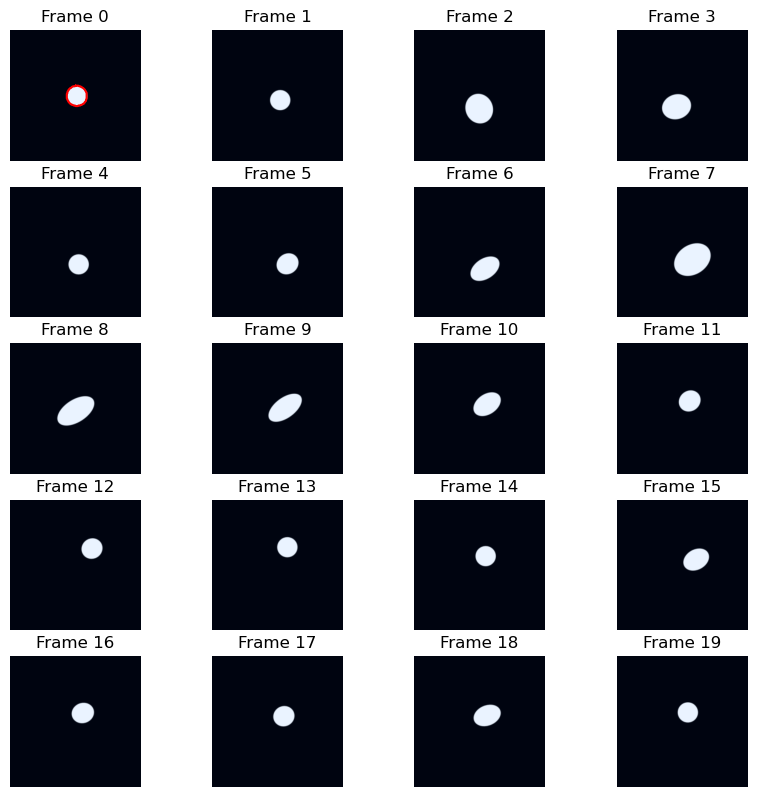

Epoch 225, IOU: 0.049799
Epoch 226, Loss: 682.75
Epoch 227, Loss: 345.43
Epoch 228, Loss: 181.16
Epoch 229, Loss: 207.16
Epoch 230, Loss: 188.80
Epoch 231, Loss: 182.38
Epoch 232, Loss: 176.03
Epoch 233, Loss: 167.48
Epoch 234, Loss: 178.70
Epoch 235, Loss: 180.21
Epoch 236, Loss: 179.30
Epoch 237, Loss: 174.79
Epoch 238, Loss: 182.91
Epoch 239, Loss: 167.44
Epoch 240, Loss: 179.61
Epoch 241, Loss: 211.39
Epoch 242, Loss: 167.27
Epoch 243, Loss: 184.37
Epoch 244, Loss: 191.99
Epoch 245, Loss: 196.16


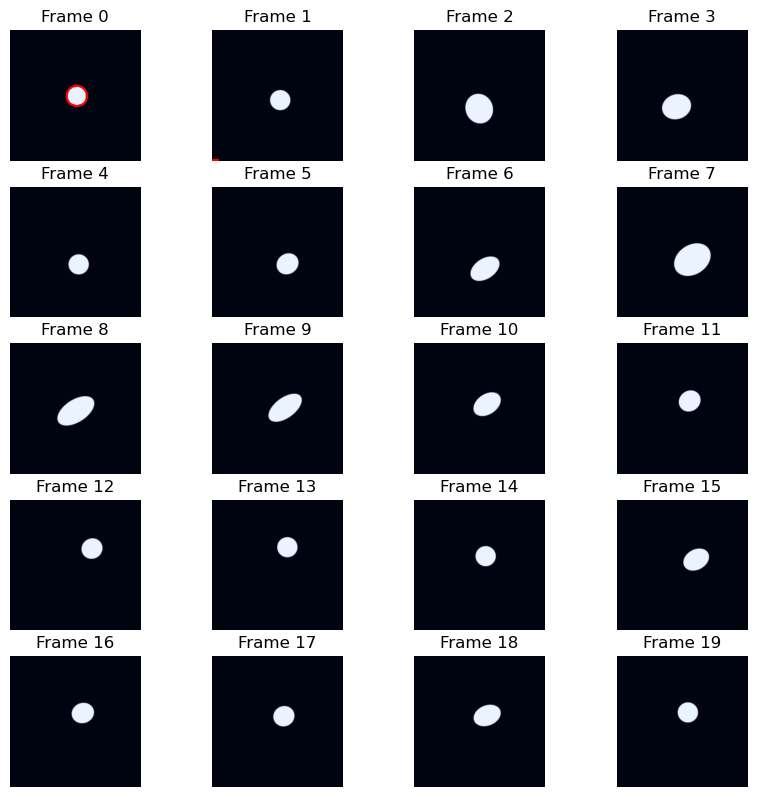

Epoch 245, IOU: 0.049799
Epoch 246, Loss: 622.27
Epoch 247, Loss: 191.56
Epoch 248, Loss: 215.26
Epoch 249, Loss: 181.21
Epoch 250, Loss: 196.88
Epoch 251, Loss: 198.46
Epoch 252, Loss: 179.74
Epoch 253, Loss: 179.51
Epoch 254, Loss: 193.19
Epoch 255, Loss: 181.04
Epoch 256, Loss: 207.30
Epoch 257, Loss: 180.69
Epoch 258, Loss: 180.24
Epoch 259, Loss: 213.02
Epoch 260, Loss: 179.90


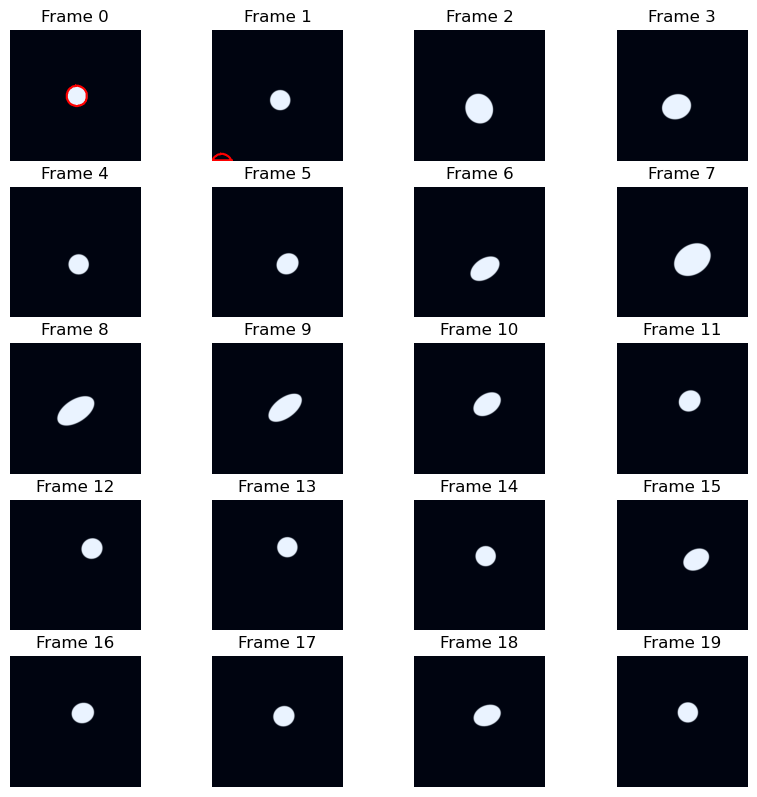

Epoch 260, IOU: 0.049799
Epoch 261, Loss: 178.36
Epoch 262, Loss: 191.61
Epoch 263, Loss: 208.01
Epoch 264, Loss: 194.15
Epoch 265, Loss: 193.07
Epoch 266, Loss: 239.48
Epoch 267, Loss: 178.94
Epoch 268, Loss: 190.25
Epoch 269, Loss: 193.44
Epoch 270, Loss: 189.07


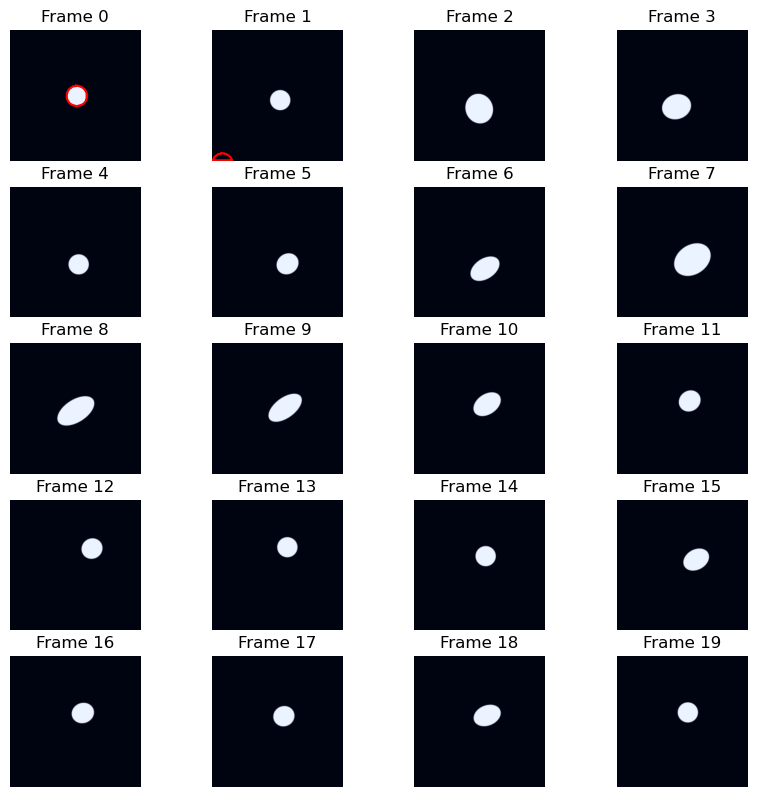

Epoch 270, IOU: 0.049799
Epoch 271, Loss: 191.02
Epoch 272, Loss: 207.98
Epoch 273, Loss: 180.87
Epoch 274, Loss: 210.75
Epoch 275, Loss: 193.81


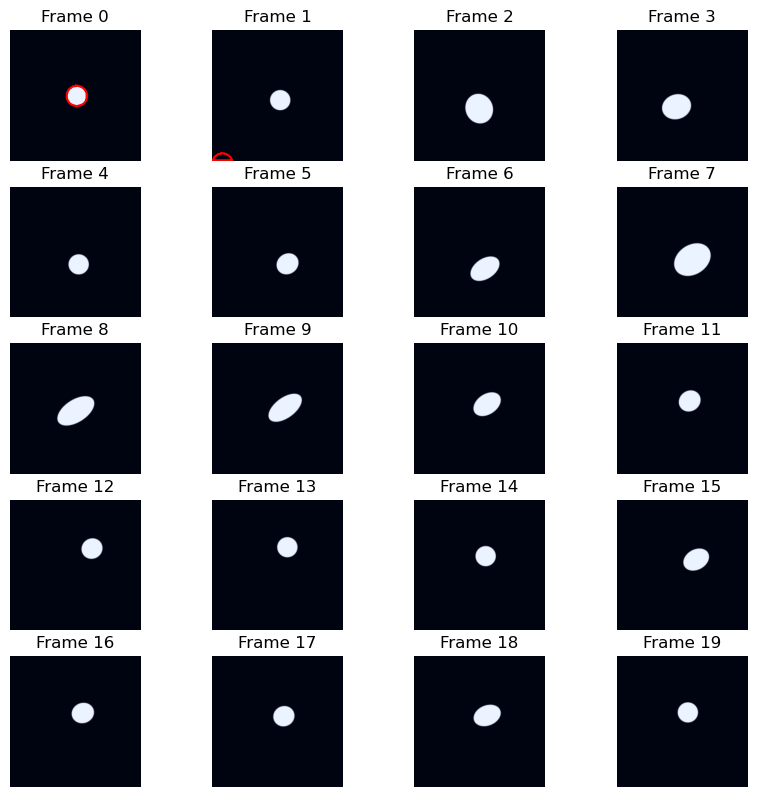

Epoch 275, IOU: 0.049799
Epoch 276, Loss: 208.72
Epoch 277, Loss: 194.18
Epoch 278, Loss: 194.56
Epoch 279, Loss: 202.58
Epoch 280, Loss: 192.59


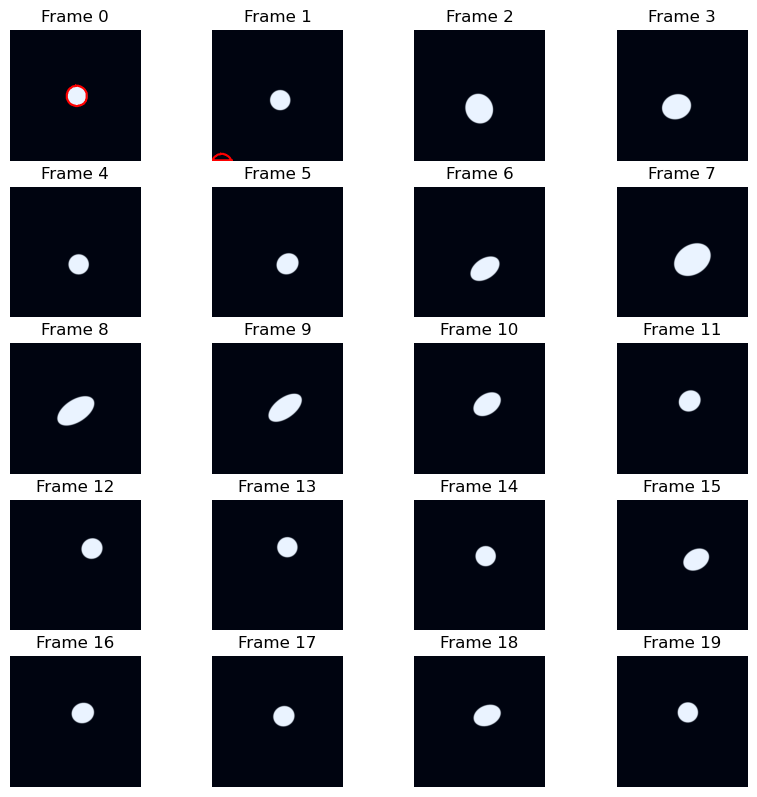

Epoch 280, IOU: 0.049799
Epoch 281, Loss: 191.80
Epoch 282, Loss: 209.99
Epoch 283, Loss: 180.94
Epoch 284, Loss: 204.02
Epoch 285, Loss: 193.90


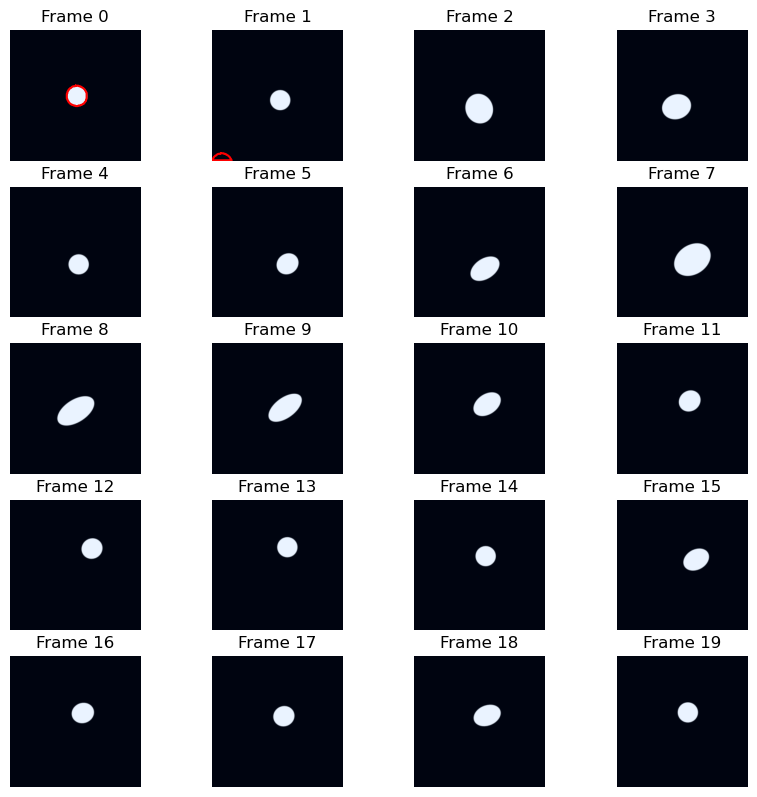

Epoch 285, IOU: 0.049799
Epoch 286, Loss: 186.45
Epoch 287, Loss: 208.19
Epoch 288, Loss: 206.95
Epoch 289, Loss: 234.32
Epoch 290, Loss: 203.95


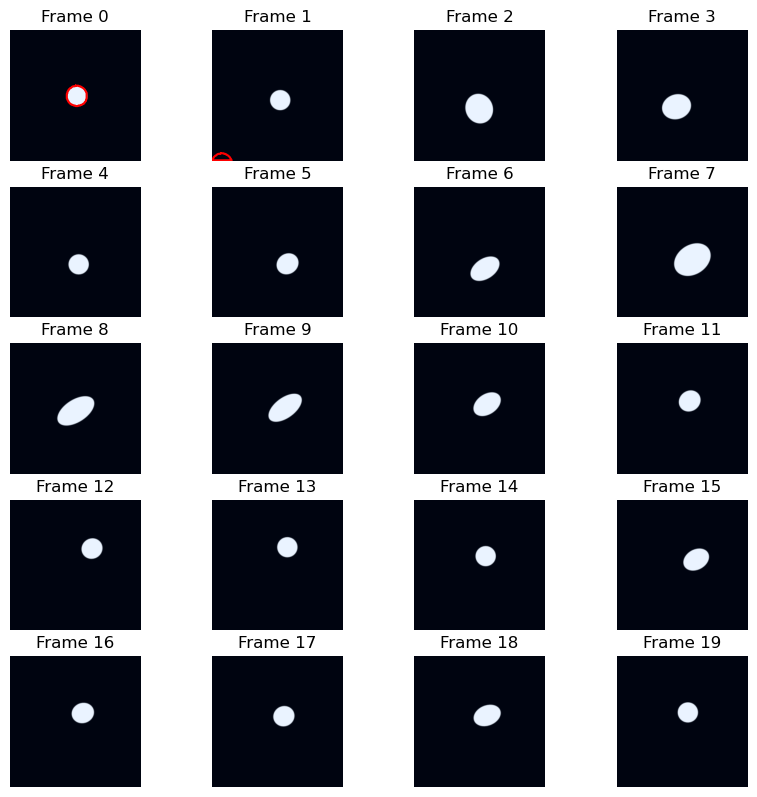

Epoch 290, IOU: 0.049799
Epoch 291, Loss: 192.80
Epoch 292, Loss: 228.71
Epoch 293, Loss: 178.37
Epoch 294, Loss: 180.35
Epoch 295, Loss: 218.47


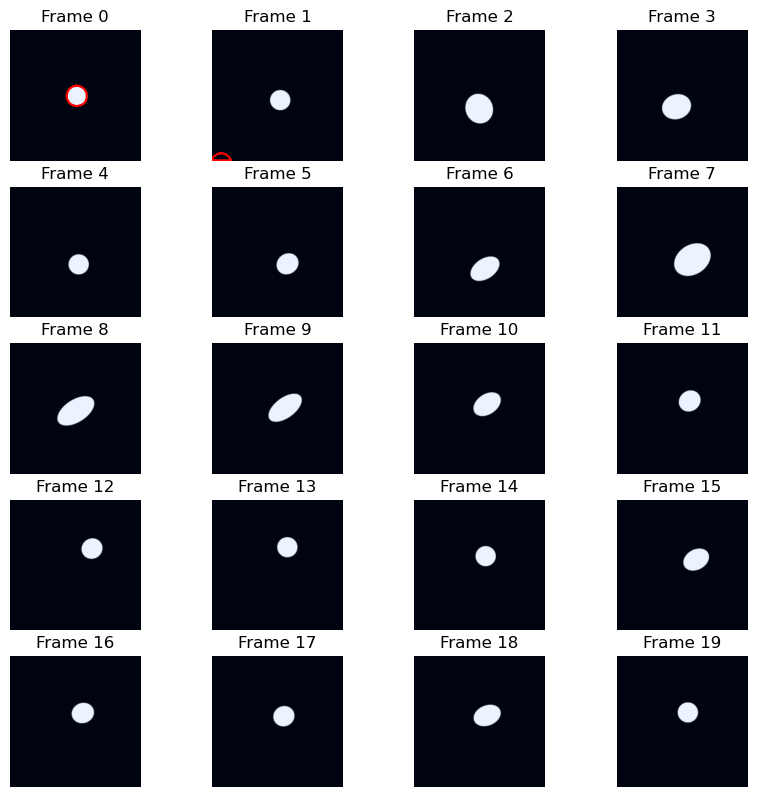

Epoch 295, IOU: 0.049799
Epoch 296, Loss: 194.21
Epoch 297, Loss: 194.18
Epoch 298, Loss: 228.78
Epoch 299, Loss: 192.94
Epoch 300, Loss: 193.07


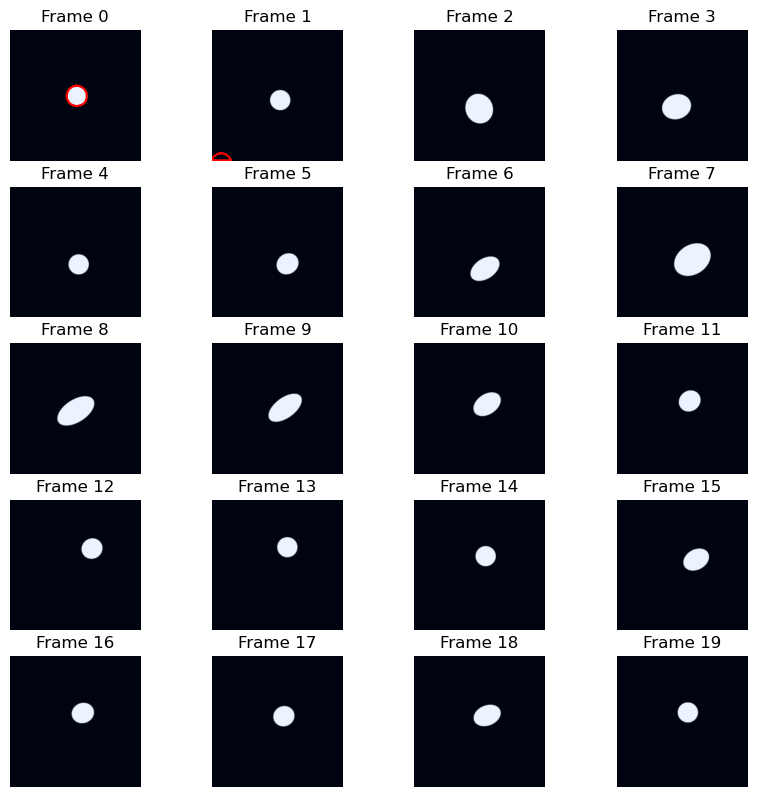

Epoch 300, IOU: 0.049799
Epoch 301, Loss: 178.85
Epoch 302, Loss: 195.01
Epoch 303, Loss: 205.53
Epoch 304, Loss: 206.14
Epoch 305, Loss: 205.69


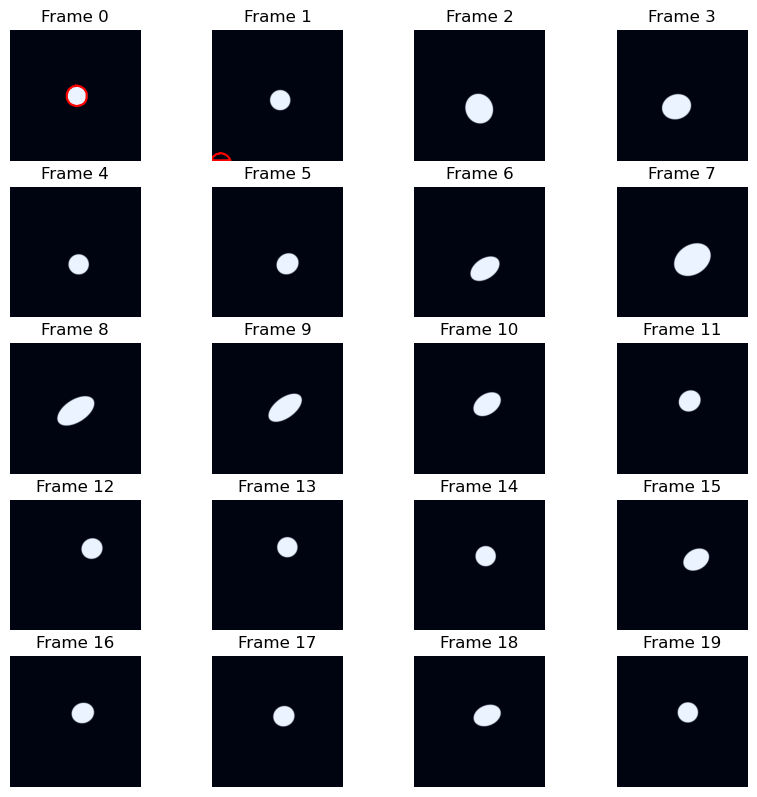

Epoch 305, IOU: 0.049799
Epoch 306, Loss: 186.13
Epoch 307, Loss: 215.95
Epoch 308, Loss: 194.78
Epoch 309, Loss: 192.01
Epoch 310, Loss: 177.80


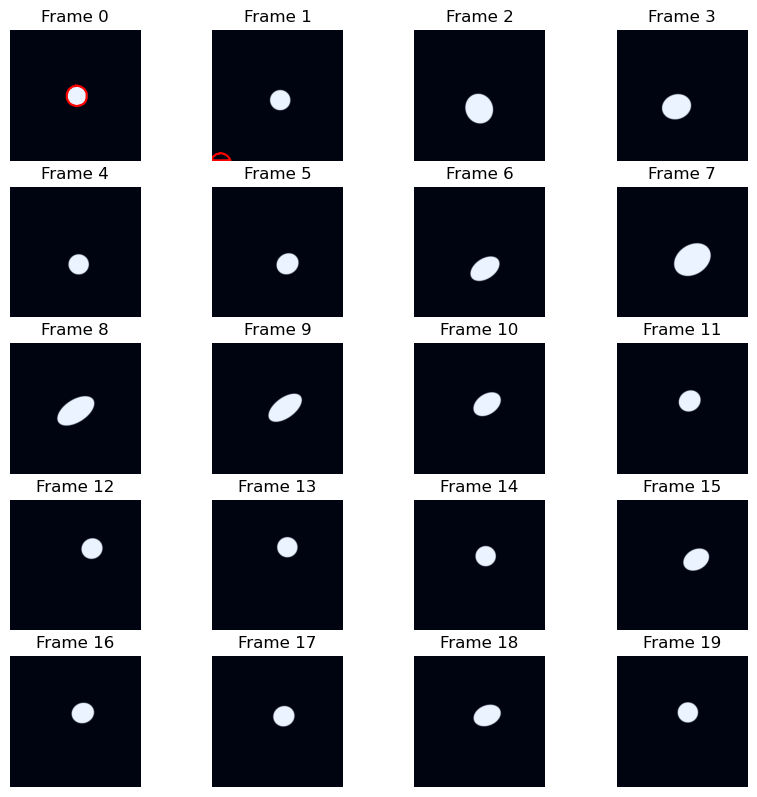

Epoch 310, IOU: 0.049799
Epoch 311, Loss: 191.50
Epoch 312, Loss: 192.17
Epoch 313, Loss: 184.69
Epoch 314, Loss: 177.03
Epoch 315, Loss: 191.54


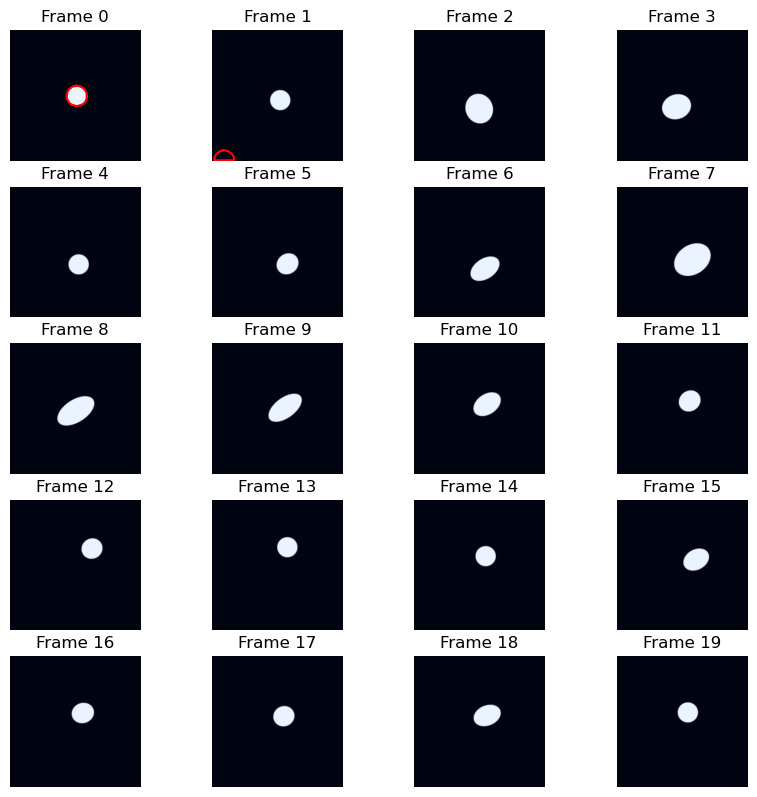

Epoch 315, IOU: 0.049799
Epoch 316, Loss: 189.56
Epoch 317, Loss: 177.93
Epoch 318, Loss: 209.94
Epoch 319, Loss: 189.55
Epoch 320, Loss: 194.90


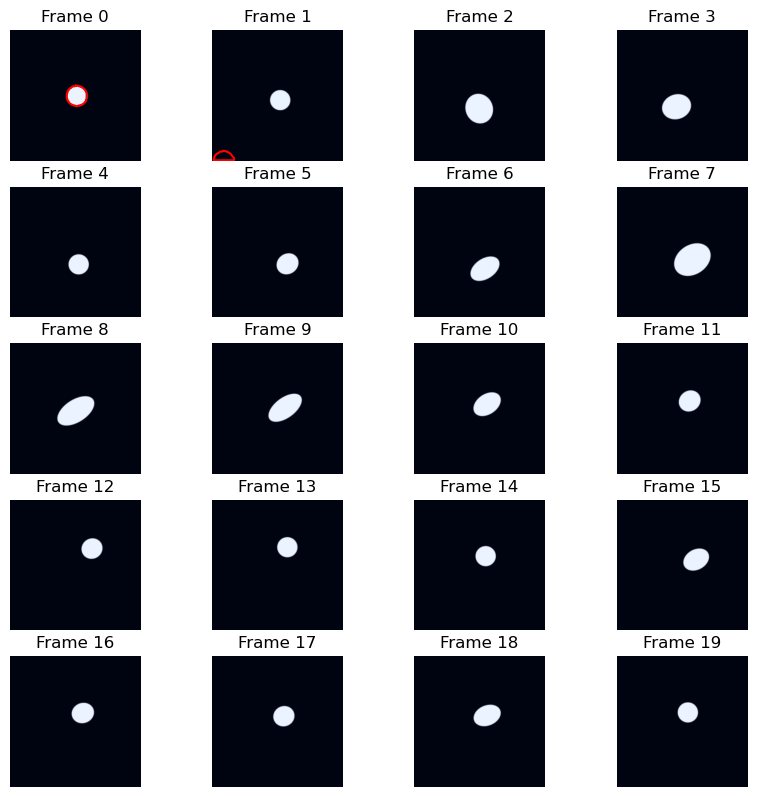

Epoch 320, IOU: 0.049799
Epoch 321, Loss: 186.54
Epoch 322, Loss: 177.66
Epoch 323, Loss: 192.41
Epoch 324, Loss: 187.84
Epoch 325, Loss: 233.19


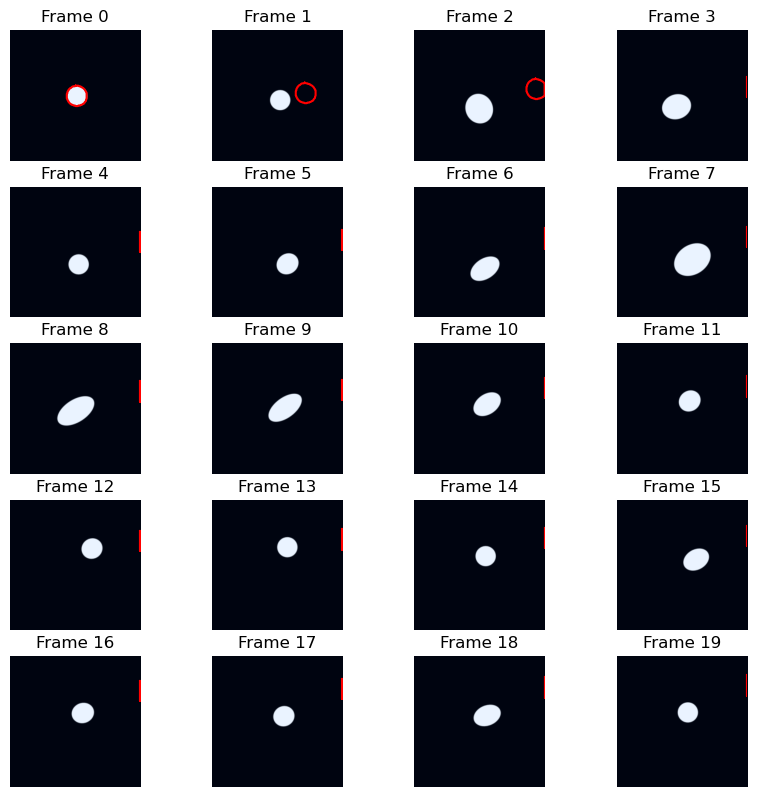

Epoch 325, IOU: 0.049799
Epoch 326, Loss: 274.17
Epoch 327, Loss: 181.48
Epoch 328, Loss: 161.92
Epoch 329, Loss: 173.00
Epoch 330, Loss: 150.34


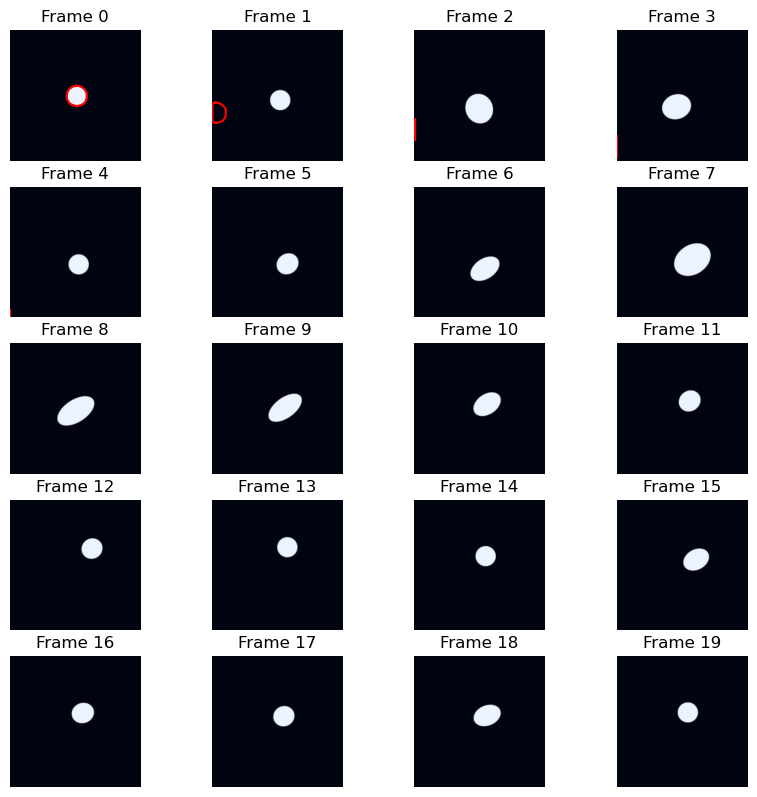

Epoch 330, IOU: 0.049799
Epoch 331, Loss: 559.58
Epoch 332, Loss: 414.58
Epoch 333, Loss: 223.13
Epoch 334, Loss: 197.50
Epoch 335, Loss: 184.73


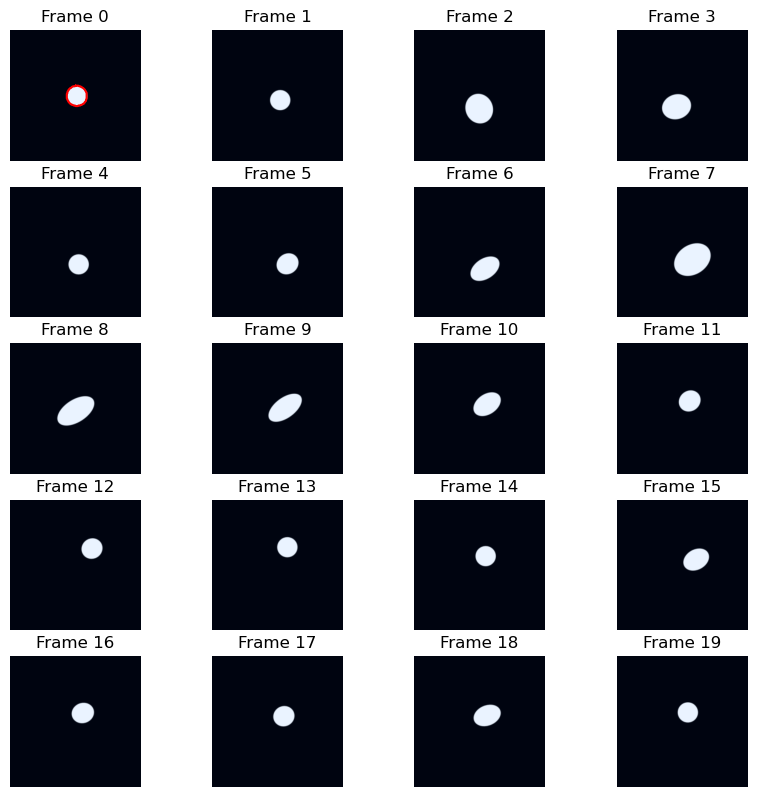

Epoch 335, IOU: 0.049799
Epoch 336, Loss: 700.45
Epoch 337, Loss: 463.47
Epoch 338, Loss: 197.05
Epoch 339, Loss: 350.30
Epoch 340, Loss: 436.93


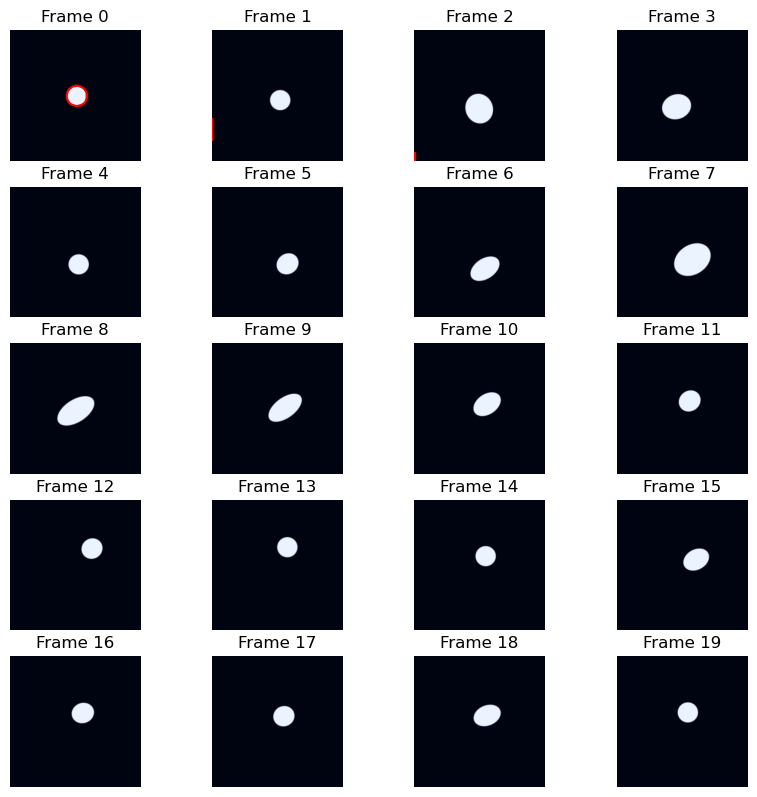

Epoch 340, IOU: 0.049799
Epoch 341, Loss: 313.19
Epoch 342, Loss: 216.90
Epoch 343, Loss: 191.57
Epoch 344, Loss: 197.31
Epoch 345, Loss: 190.56


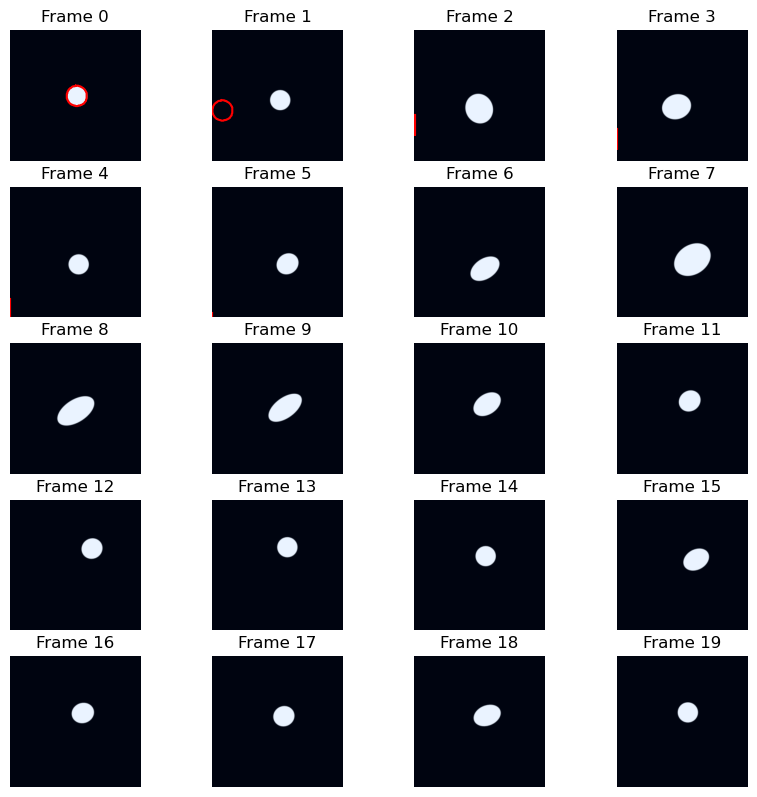

Epoch 345, IOU: 0.049799
Epoch 346, Loss: 237.64
Epoch 347, Loss: 179.64
Epoch 348, Loss: 216.13
Epoch 349, Loss: 180.16
Epoch 350, Loss: 199.56


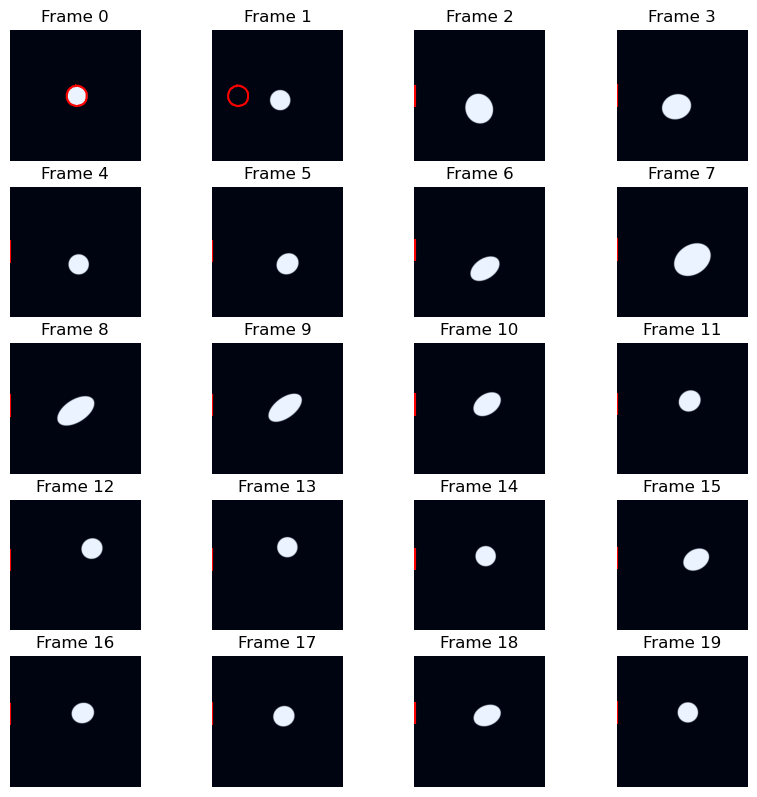

Epoch 350, IOU: 0.049799
Epoch 351, Loss: 294.41
Epoch 352, Loss: 210.21
Epoch 353, Loss: 172.47
Epoch 354, Loss: 160.54
Epoch 355, Loss: 166.19


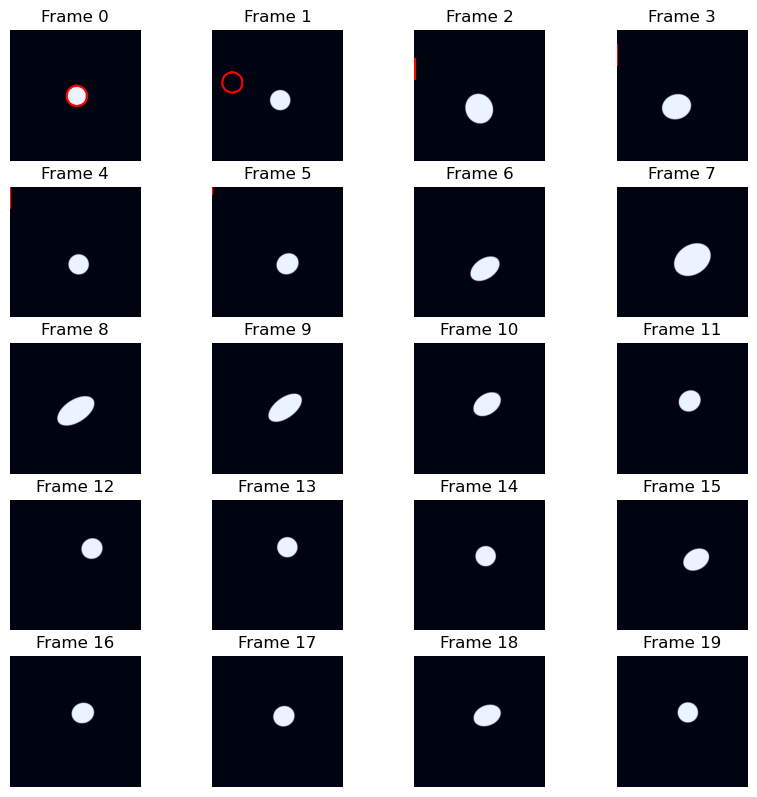

Epoch 355, IOU: 0.049799
Epoch 356, Loss: 294.30
Epoch 357, Loss: 269.17
Epoch 358, Loss: 245.40
Epoch 359, Loss: 232.68
Epoch 360, Loss: 228.61


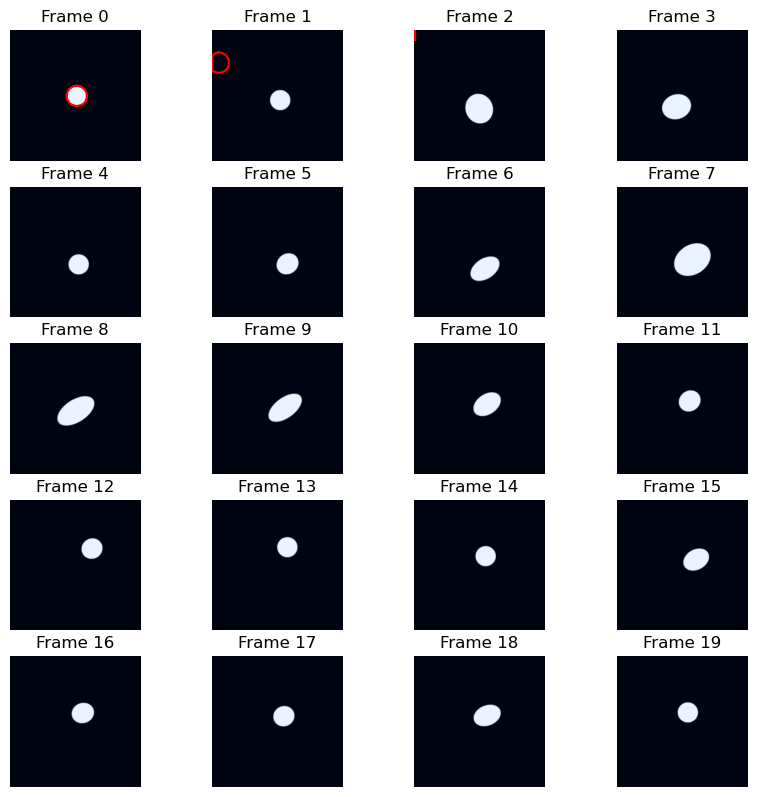

Epoch 360, IOU: 0.049799
Epoch 361, Loss: 240.52
Epoch 362, Loss: 216.75
Epoch 363, Loss: 199.27
Epoch 364, Loss: 213.49
Epoch 365, Loss: 211.37


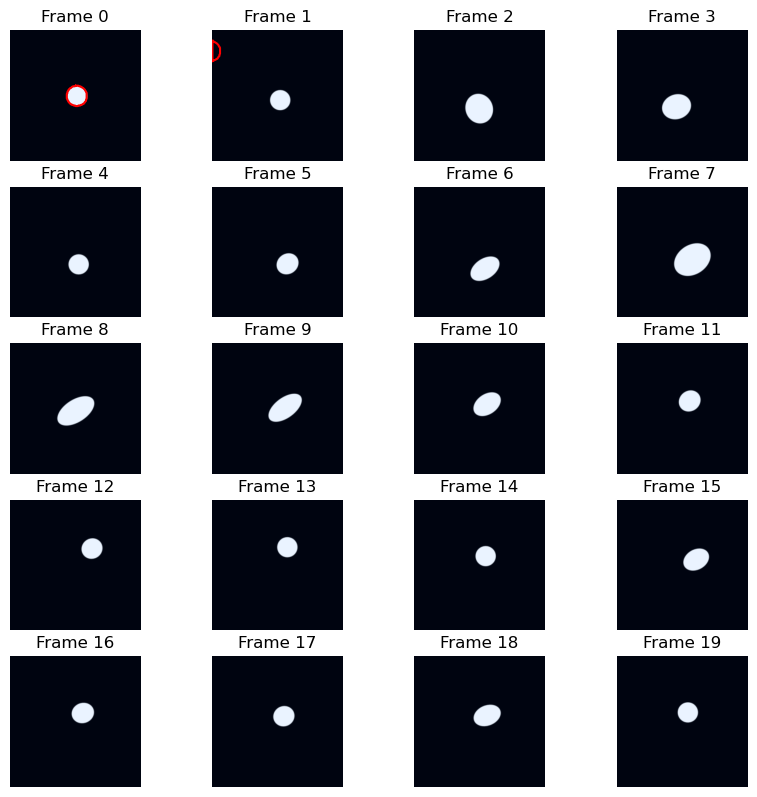

Epoch 365, IOU: 0.049799
Epoch 366, Loss: 198.23
Epoch 367, Loss: 193.84
Epoch 368, Loss: 181.88
Epoch 369, Loss: 198.24
Epoch 370, Loss: 220.34


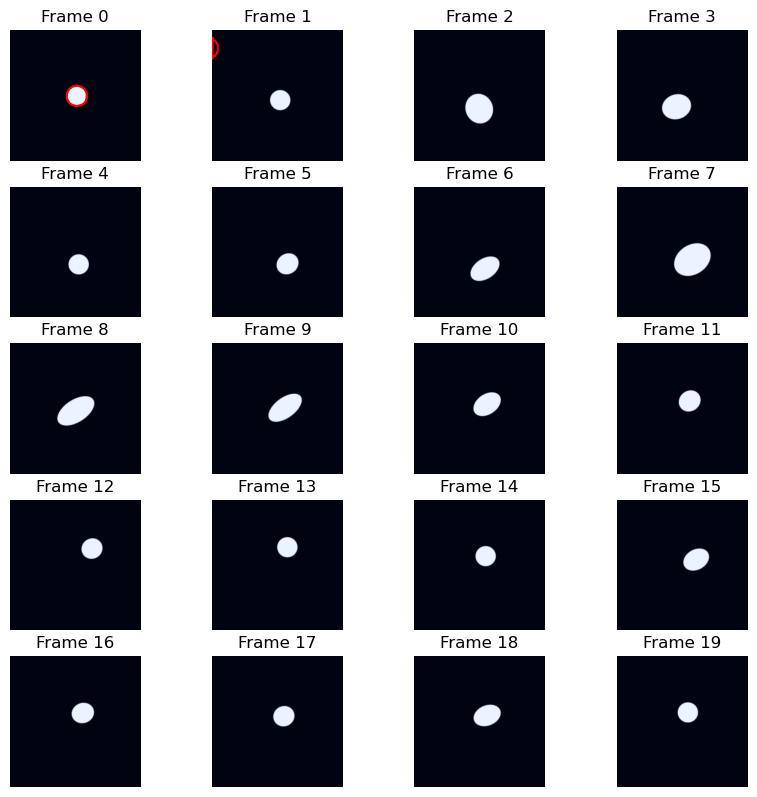

Epoch 370, IOU: 0.049799
Epoch 371, Loss: 201.49
Epoch 372, Loss: 179.16
Epoch 373, Loss: 215.00
Epoch 374, Loss: 208.05
Epoch 375, Loss: 181.90


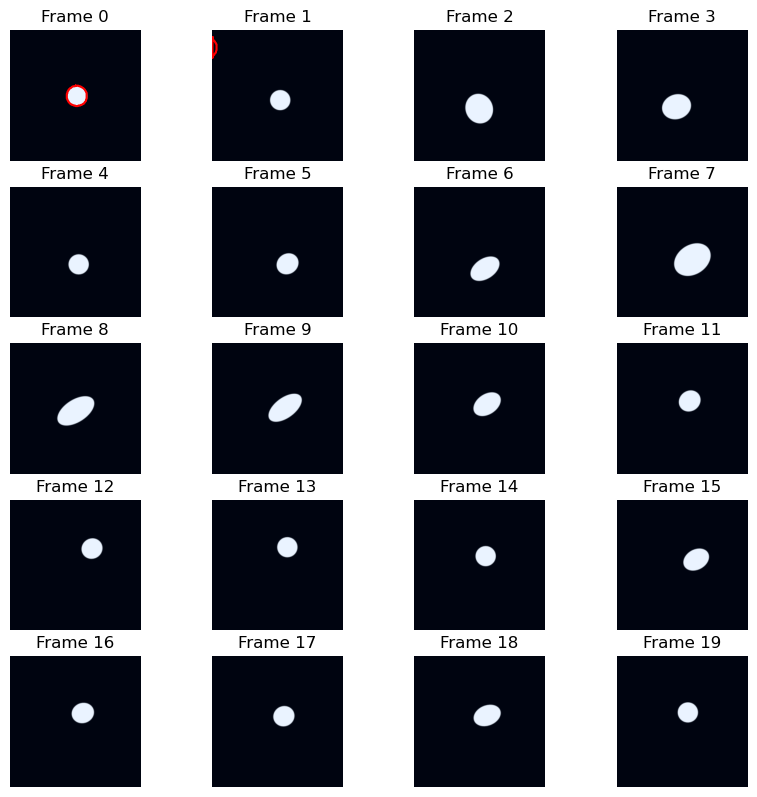

Epoch 375, IOU: 0.049799
Epoch 376, Loss: 196.96
Epoch 377, Loss: 190.81
Epoch 378, Loss: 181.17
Epoch 379, Loss: 204.51
Epoch 380, Loss: 178.03


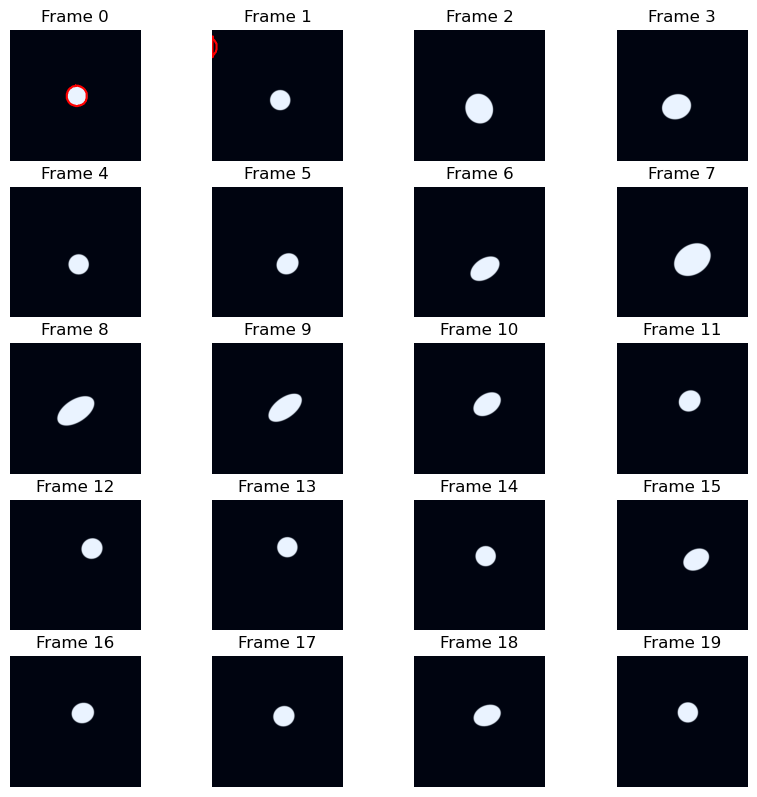

Epoch 380, IOU: 0.049799
Epoch 381, Loss: 178.31
Epoch 382, Loss: 192.22
Epoch 383, Loss: 193.37
Epoch 384, Loss: 200.50
Epoch 385, Loss: 179.20


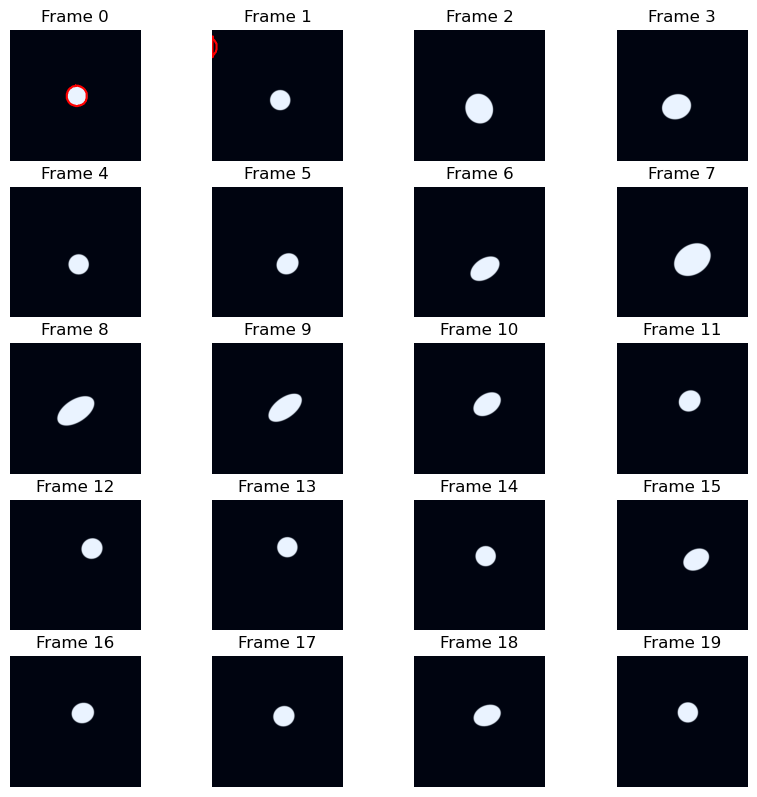

Epoch 385, IOU: 0.049799
Epoch 386, Loss: 181.01
Epoch 387, Loss: 192.53
Epoch 388, Loss: 207.37
Epoch 389, Loss: 190.46
Epoch 390, Loss: 226.49


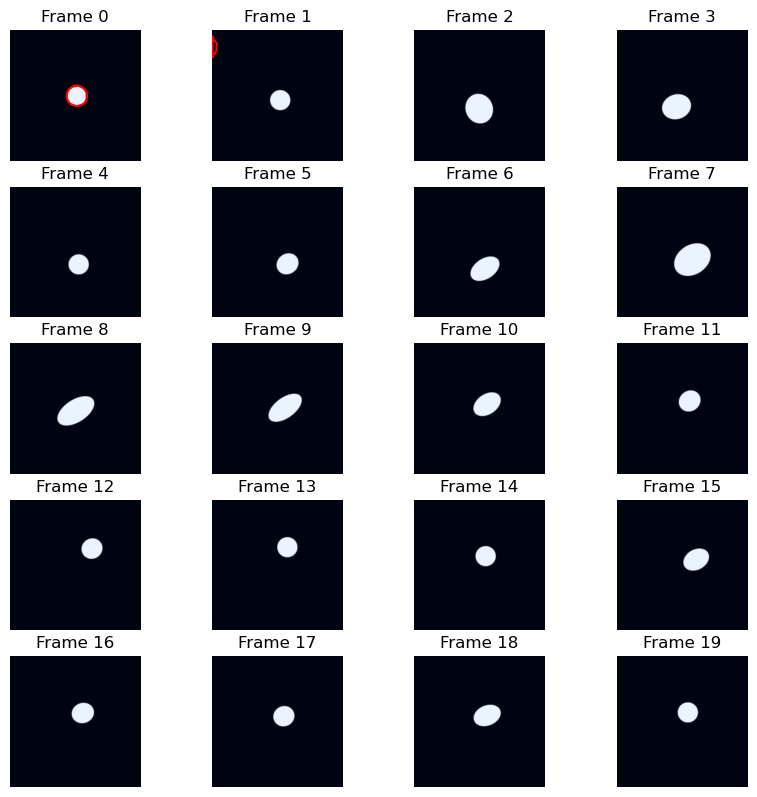

Epoch 390, IOU: 0.049799
Epoch 391, Loss: 204.40
Epoch 392, Loss: 182.54
Epoch 393, Loss: 195.95
Epoch 394, Loss: 195.89
Epoch 395, Loss: 192.28


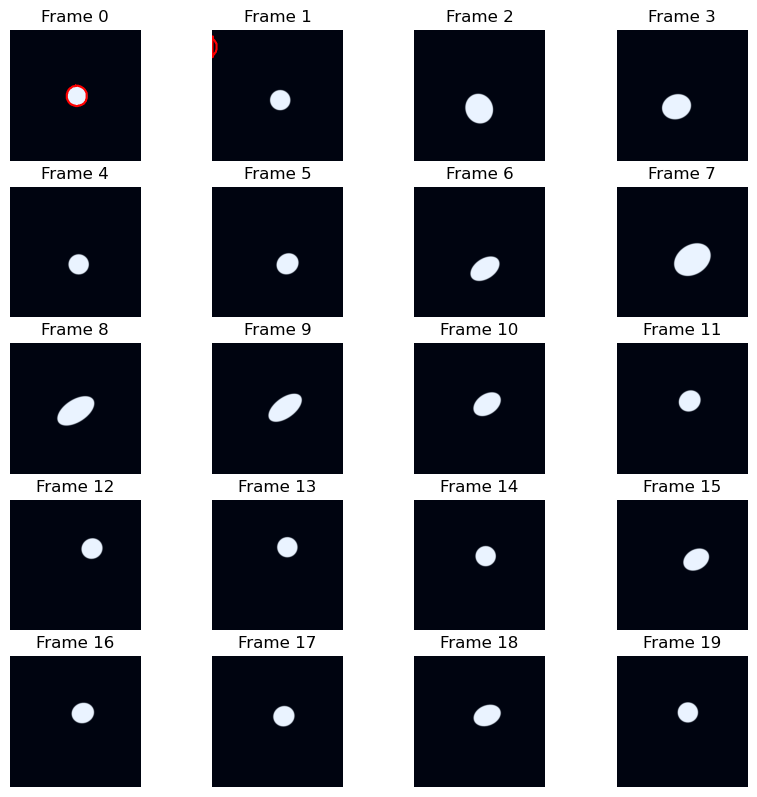

Epoch 395, IOU: 0.049799
Epoch 396, Loss: 188.74
Epoch 397, Loss: 182.00
Epoch 398, Loss: 194.50
Epoch 399, Loss: 196.77
Epoch 400, Loss: 191.60


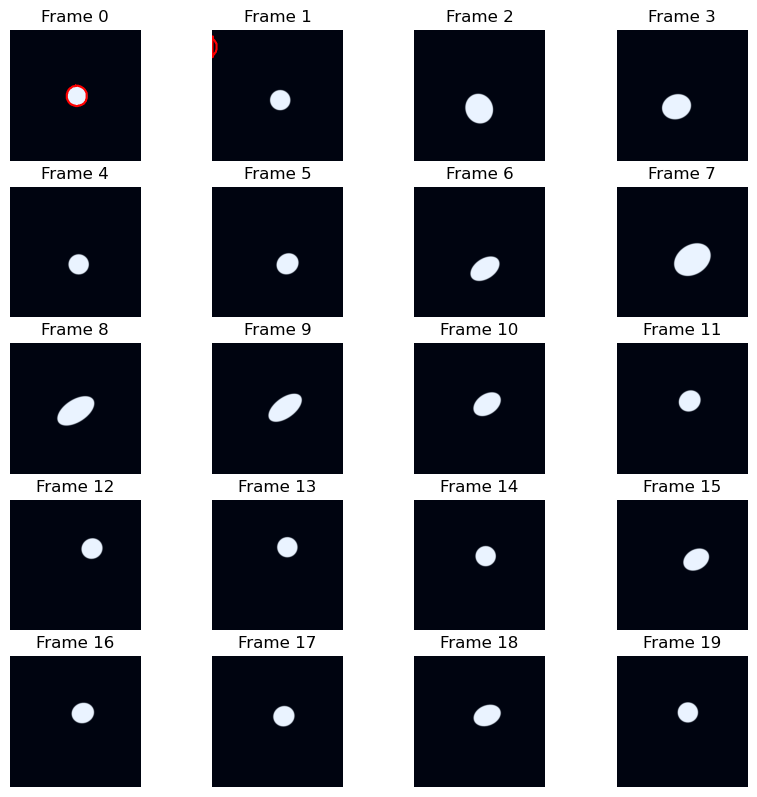

Epoch 400, IOU: 0.049799
Epoch 401, Loss: 180.43
Epoch 402, Loss: 189.17
Epoch 403, Loss: 210.91
Epoch 404, Loss: 177.06
Epoch 405, Loss: 177.06


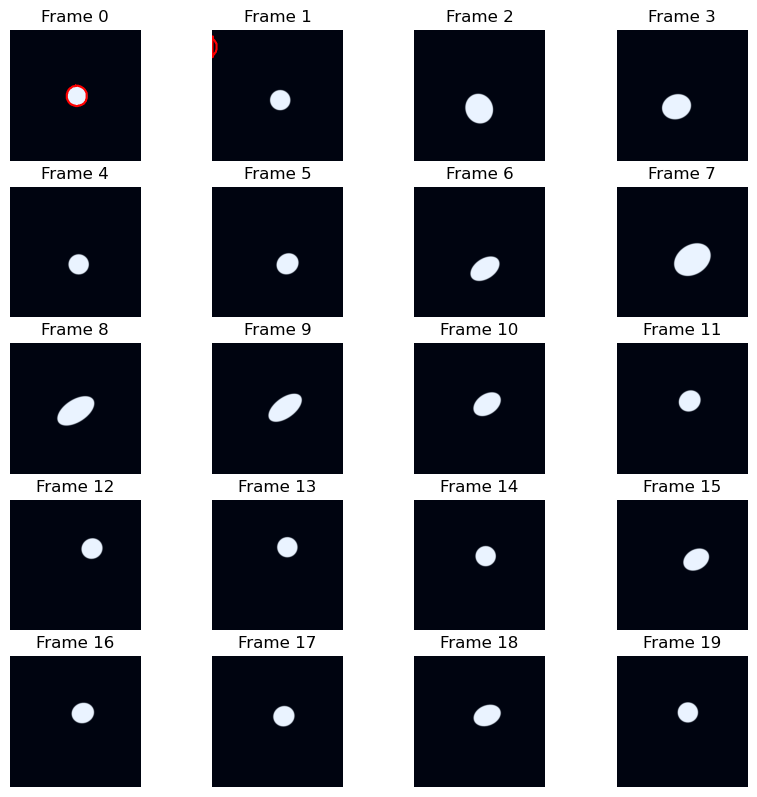

Epoch 405, IOU: 0.049799
Epoch 406, Loss: 233.28
Epoch 407, Loss: 196.33
Epoch 408, Loss: 192.42
Epoch 409, Loss: 193.30
Epoch 410, Loss: 194.23


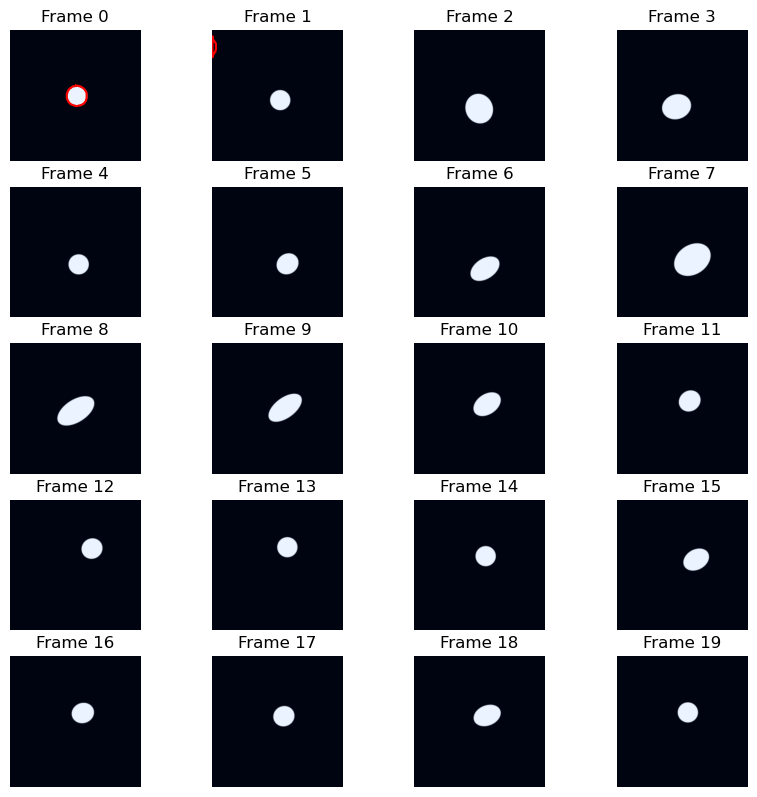

Epoch 410, IOU: 0.049799
Epoch 411, Loss: 192.99
Epoch 412, Loss: 178.59
Epoch 413, Loss: 192.95
Epoch 414, Loss: 210.04
Epoch 415, Loss: 181.23


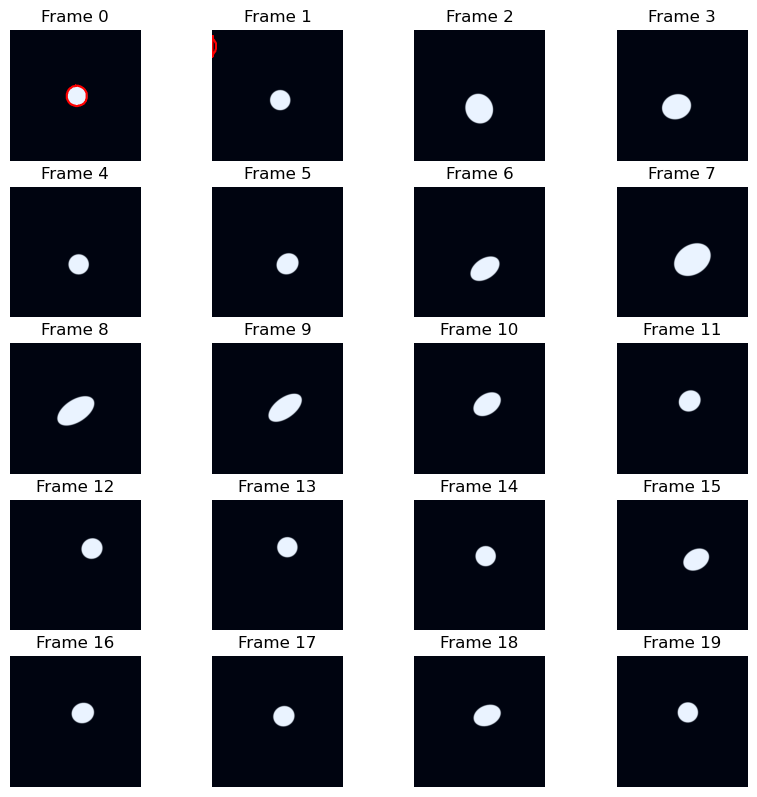

Epoch 415, IOU: 0.049799
Epoch 416, Loss: 221.96
Epoch 417, Loss: 183.78
Epoch 418, Loss: 196.37
Epoch 419, Loss: 179.55
Epoch 420, Loss: 327.60


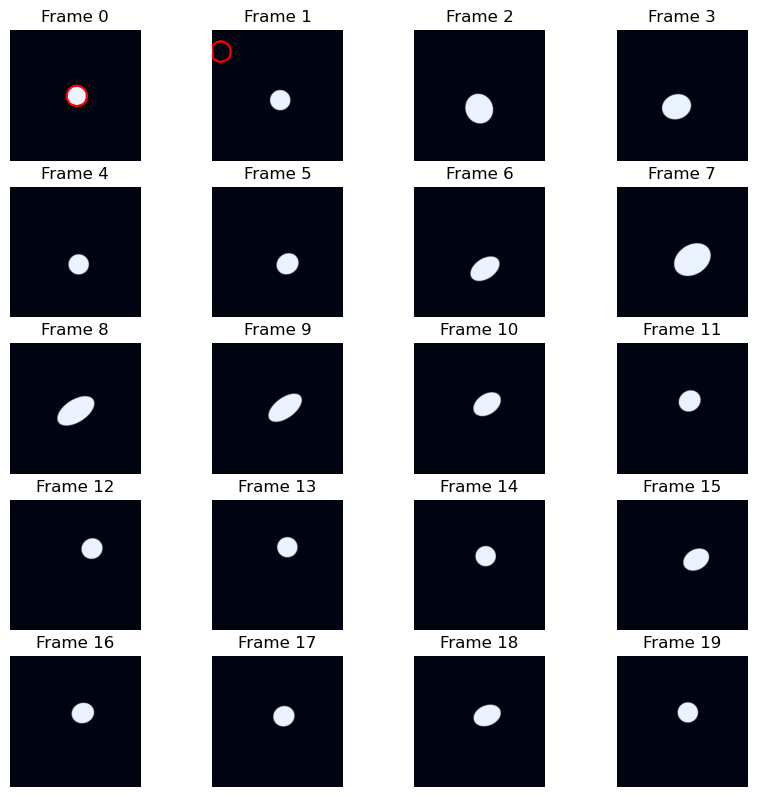

Epoch 420, IOU: 0.049799
Epoch 421, Loss: 186.68
Epoch 422, Loss: 177.47
Epoch 423, Loss: 181.54
Epoch 424, Loss: 175.78
Epoch 425, Loss: 179.69


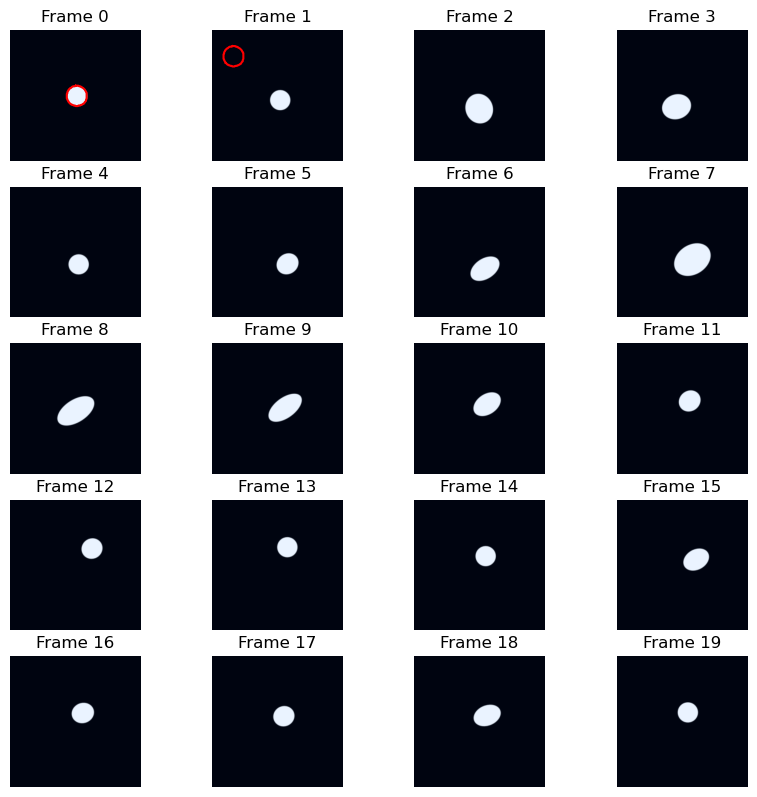

Epoch 425, IOU: 0.049799
Epoch 426, Loss: 179.25
Epoch 427, Loss: 181.39
Epoch 428, Loss: 196.40
Epoch 429, Loss: 184.81
Epoch 430, Loss: 184.37


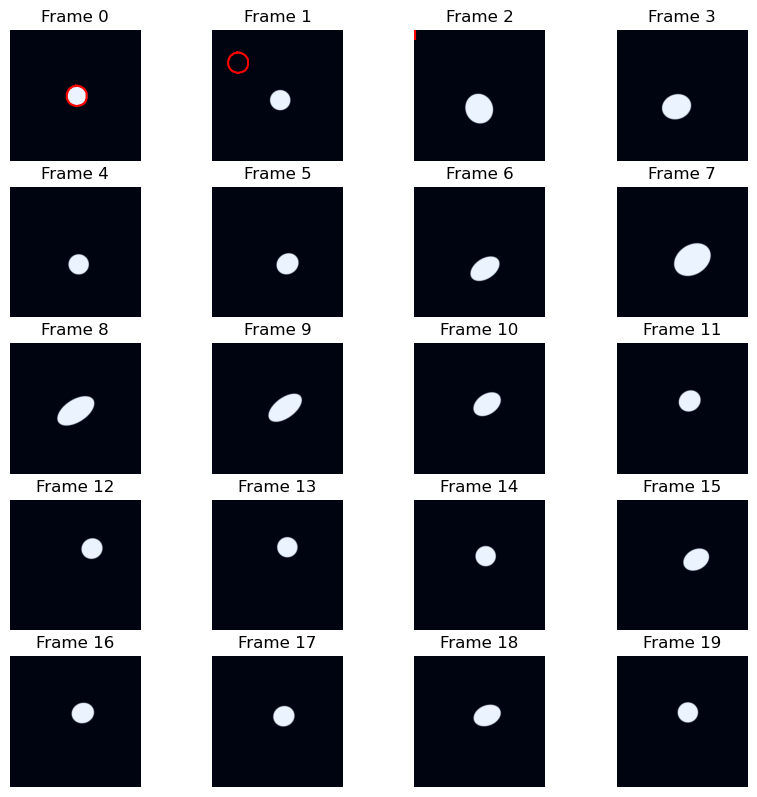

Epoch 430, IOU: 0.049799
Epoch 431, Loss: 204.79
Epoch 432, Loss: 179.46
Epoch 433, Loss: 179.29
Epoch 434, Loss: 169.93
Epoch 435, Loss: 176.70


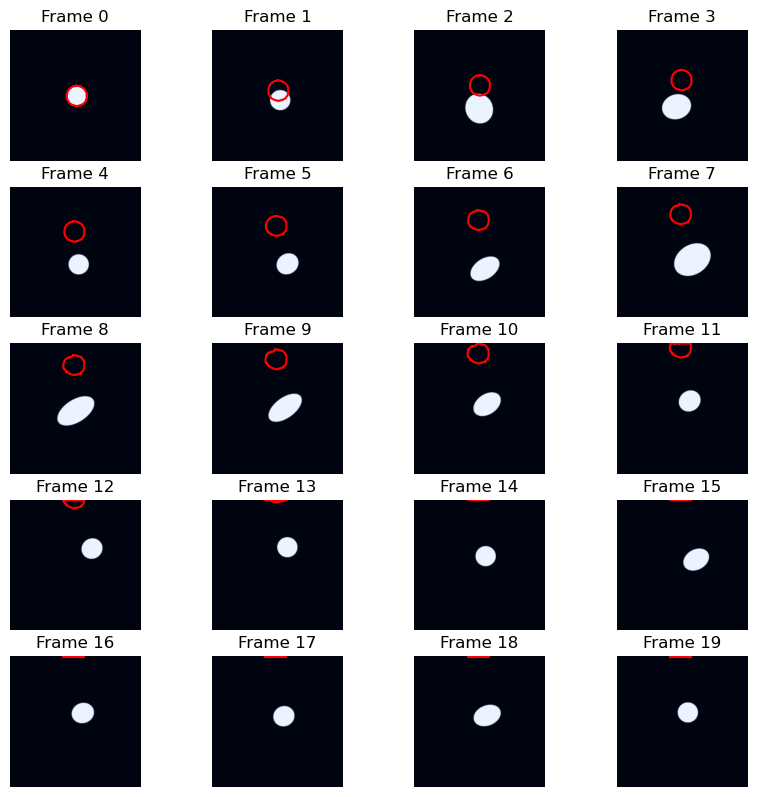

Epoch 435, IOU: 0.064993
Epoch 436, Loss: 165.88
Epoch 437, Loss: 161.06
Epoch 438, Loss: 122.88
Epoch 439, Loss: 88.00
Epoch 440, Loss: 91.86


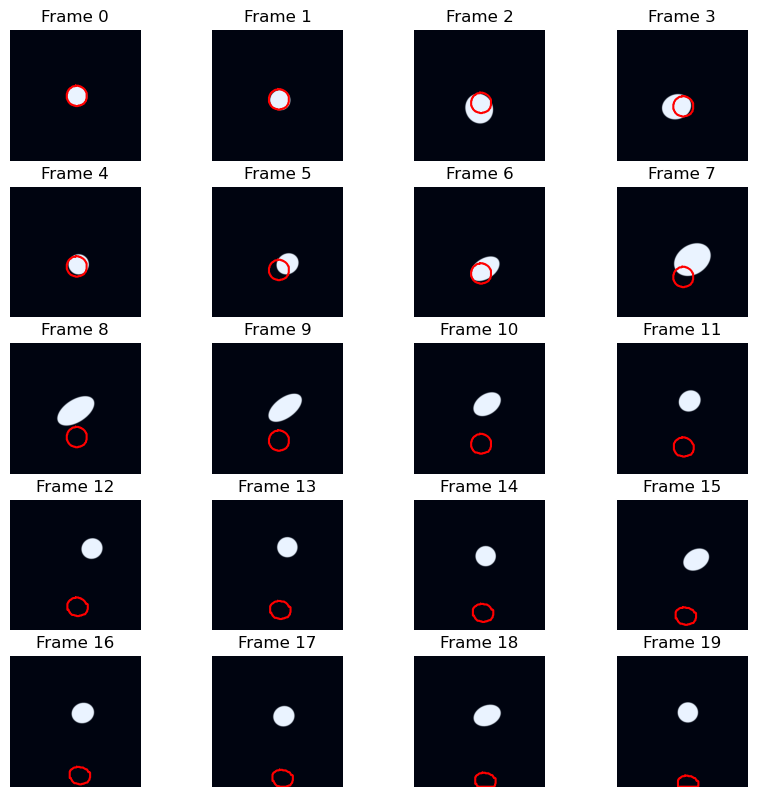

Epoch 440, IOU: 0.220813
Epoch 441, Loss: 213.51
Epoch 442, Loss: 127.98
Epoch 443, Loss: 141.41
Epoch 444, Loss: 138.05
Epoch 445, Loss: 127.18


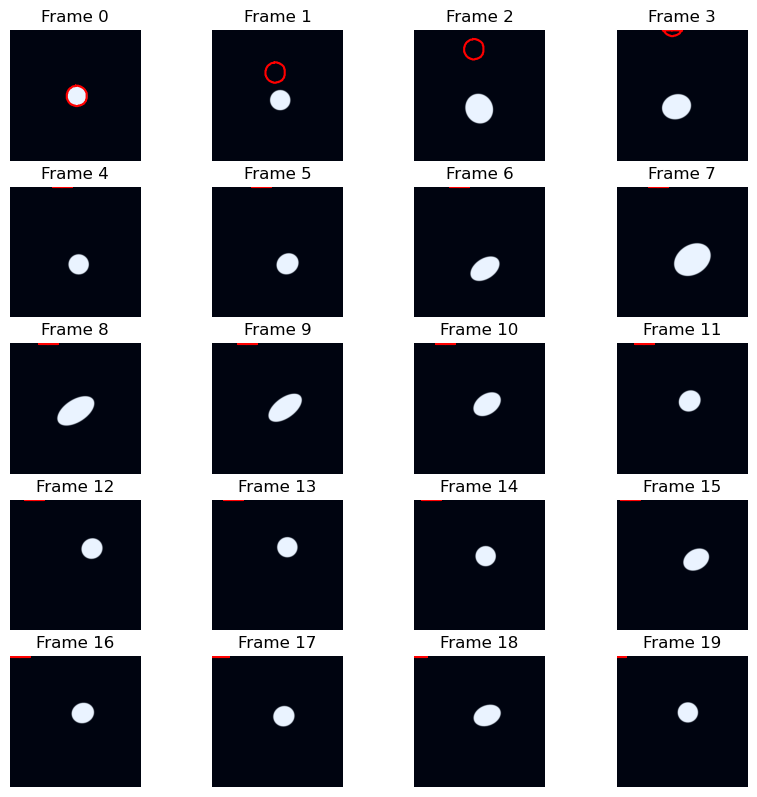

Epoch 445, IOU: 0.049799
Epoch 446, Loss: 197.61
Epoch 447, Loss: 162.40
Epoch 448, Loss: 140.67
Epoch 449, Loss: 152.39
Epoch 450, Loss: 159.93


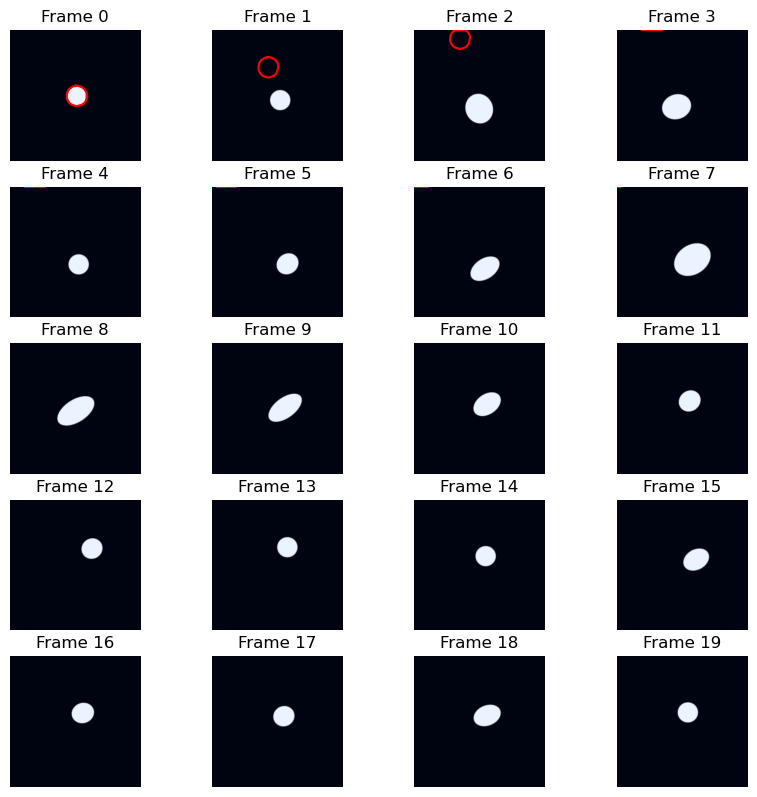

Epoch 450, IOU: 0.049799
Epoch 451, Loss: 209.54
Epoch 452, Loss: 180.60
Epoch 453, Loss: 190.00
Epoch 454, Loss: 169.01
Epoch 455, Loss: 163.48


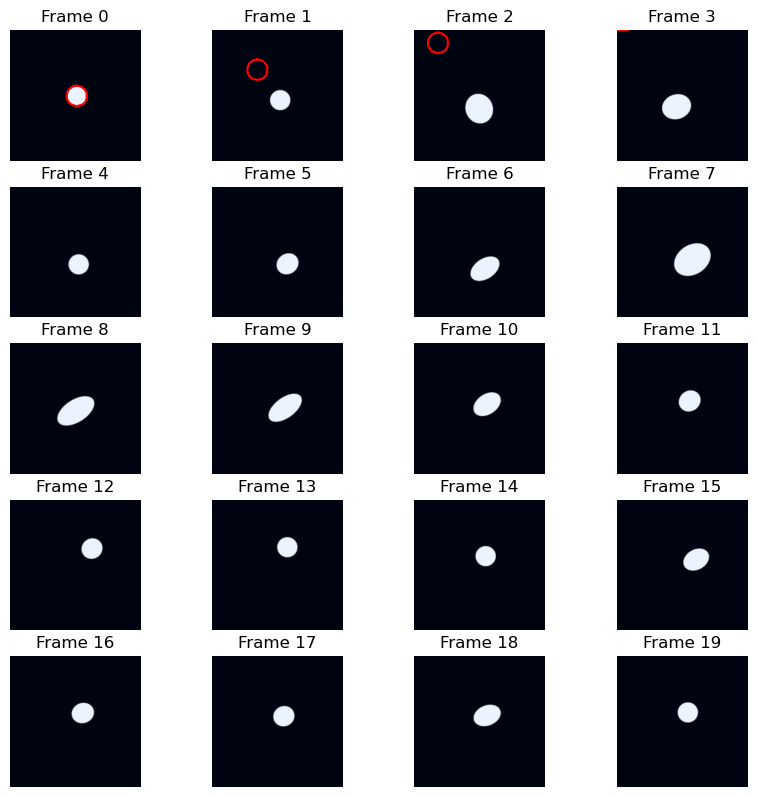

Epoch 455, IOU: 0.049799
Epoch 456, Loss: 168.01
Epoch 457, Loss: 163.05
Epoch 458, Loss: 167.63
Epoch 459, Loss: 151.37
Epoch 460, Loss: 172.57


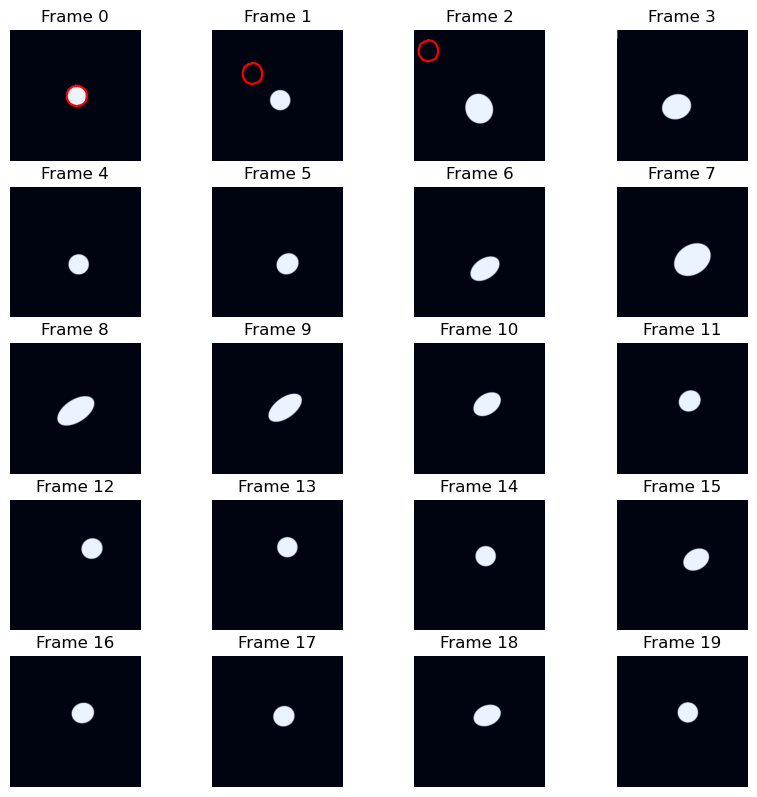

Epoch 460, IOU: 0.049799
Epoch 461, Loss: 182.02
Epoch 462, Loss: 162.60
Epoch 463, Loss: 170.34
Epoch 464, Loss: 166.73
Epoch 465, Loss: 165.53


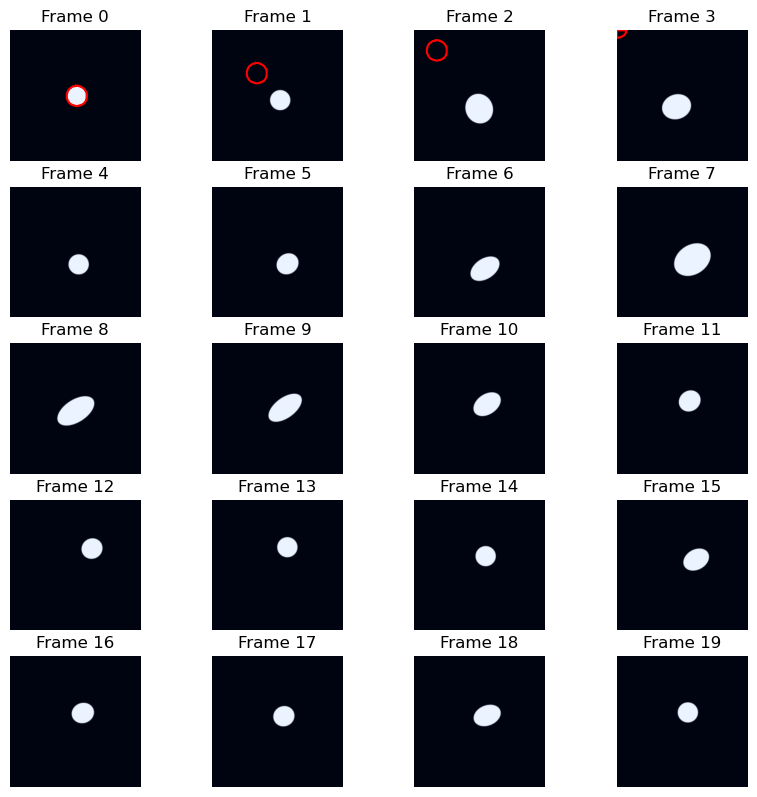

Epoch 465, IOU: 0.049799
Epoch 466, Loss: 154.50
Epoch 467, Loss: 164.79
Epoch 468, Loss: 150.87
Epoch 469, Loss: 152.14
Epoch 470, Loss: 166.54


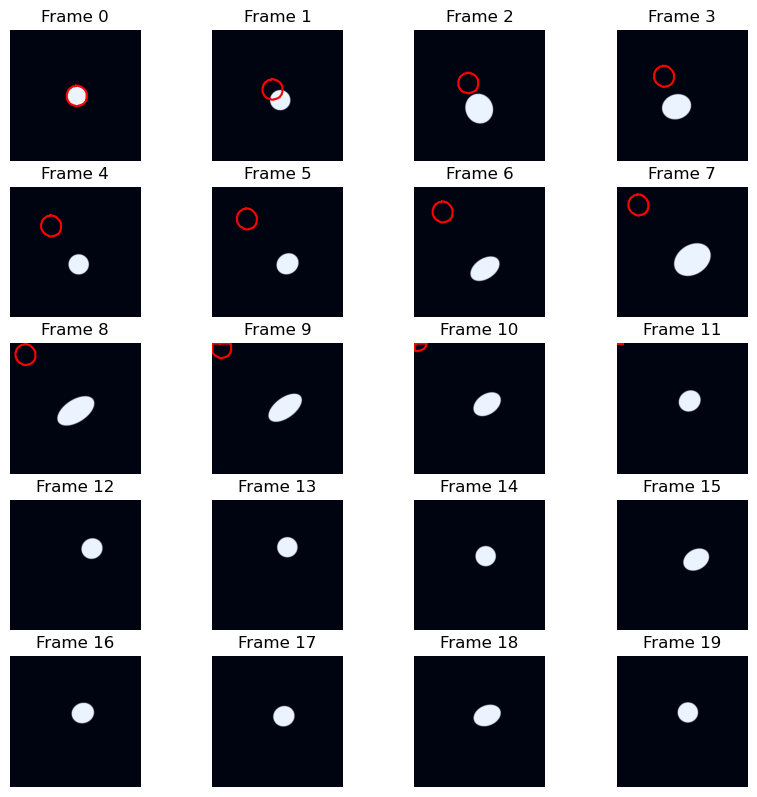

Epoch 470, IOU: 0.057521
Epoch 471, Loss: 123.23
Epoch 472, Loss: 133.33
Epoch 473, Loss: 154.05
Epoch 474, Loss: 122.98
Epoch 475, Loss: 118.30


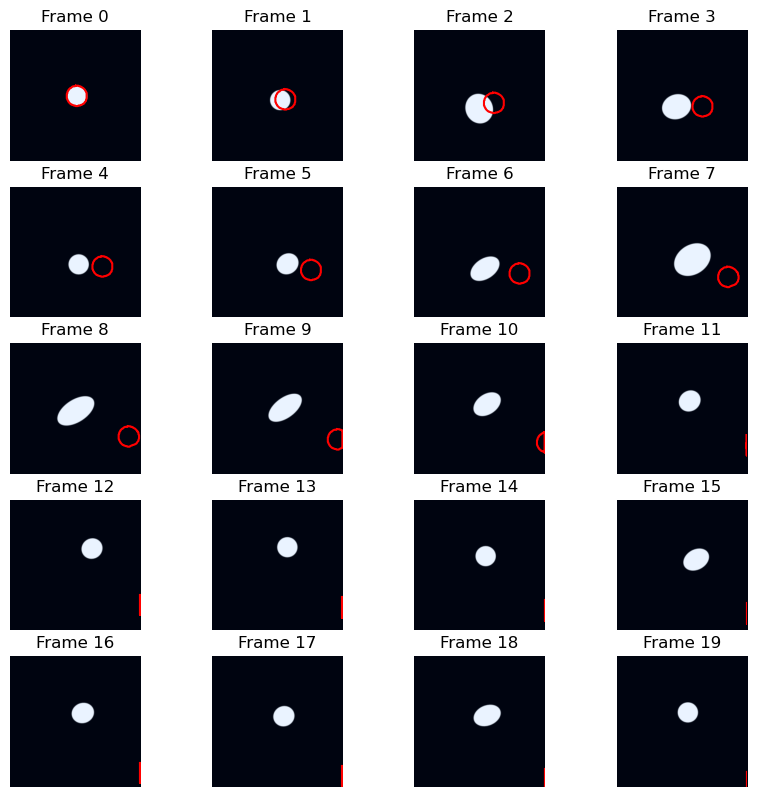

Epoch 475, IOU: 0.081768
Epoch 476, Loss: 510.43
Epoch 477, Loss: 374.77
Epoch 478, Loss: 502.64
Epoch 479, Loss: 398.65
Epoch 480, Loss: 276.45


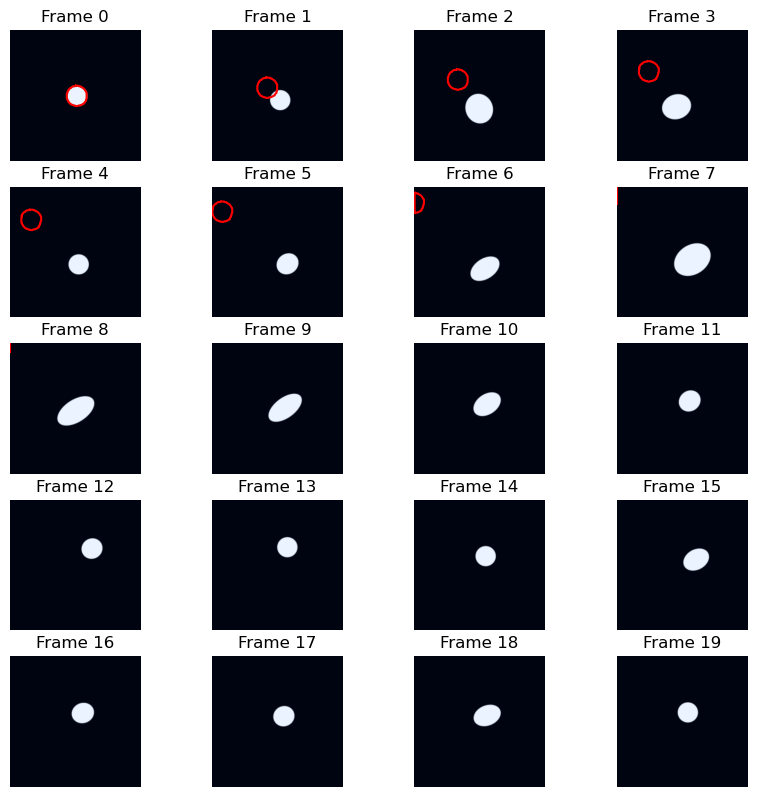

Epoch 480, IOU: 0.051604
Epoch 481, Loss: 456.37
Epoch 482, Loss: 314.11
Epoch 483, Loss: 314.34
Epoch 484, Loss: 252.39
Epoch 485, Loss: 183.67


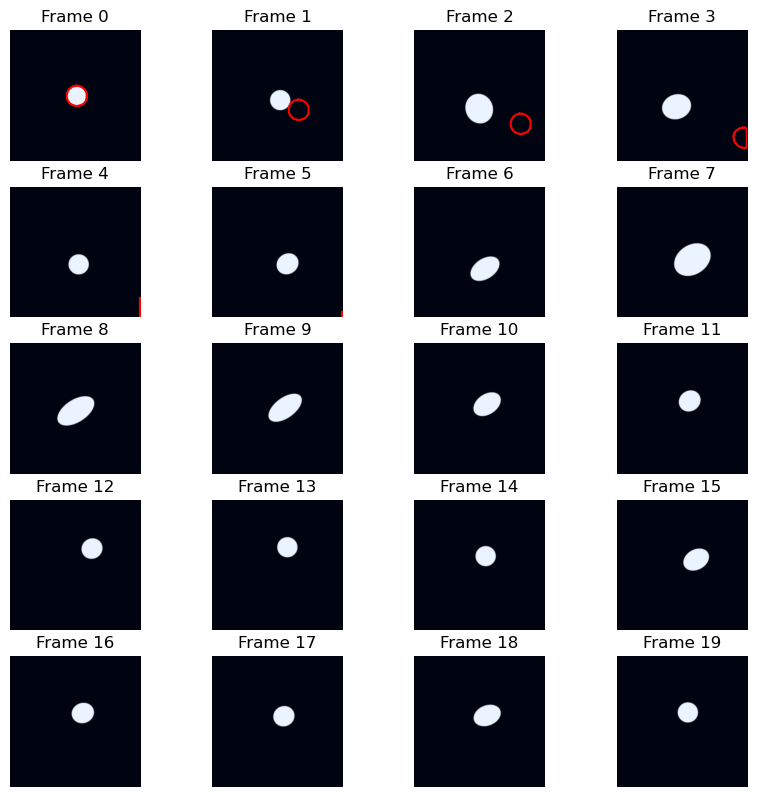

Epoch 485, IOU: 0.049799
Epoch 486, Loss: 457.14
Epoch 487, Loss: 310.28
Epoch 488, Loss: 281.90
Epoch 489, Loss: 213.79
Epoch 490, Loss: 195.68


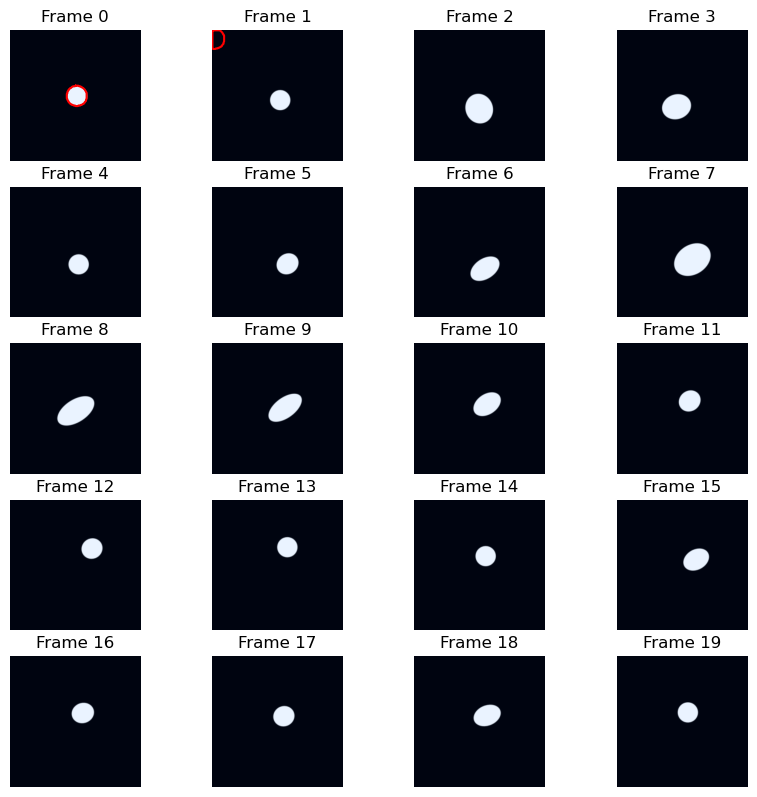

Epoch 490, IOU: 0.049799
Epoch 491, Loss: 404.21
Epoch 492, Loss: 369.44
Epoch 493, Loss: 402.40
Epoch 494, Loss: 422.76
Epoch 495, Loss: 411.79


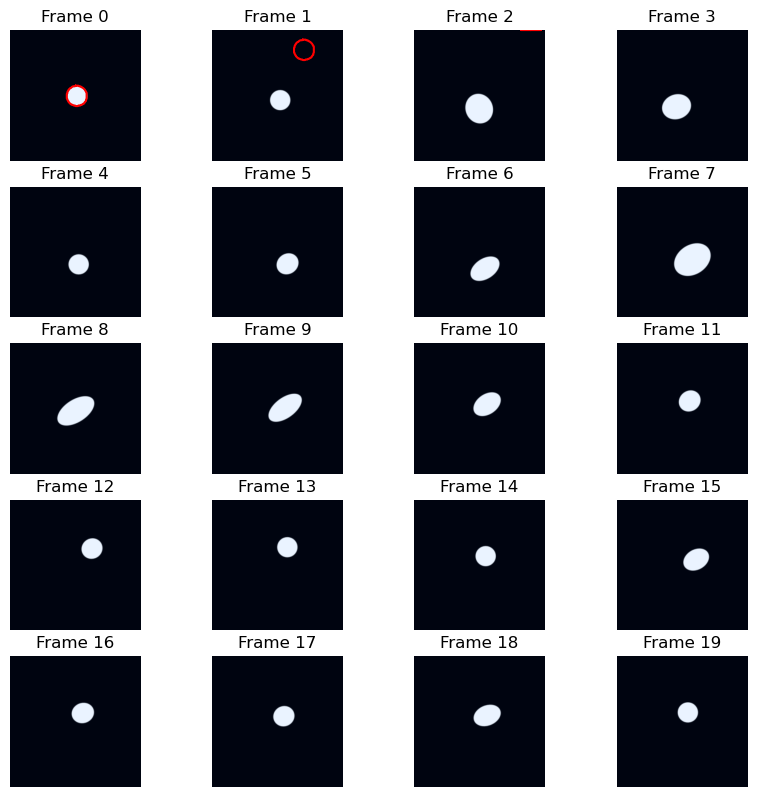

Epoch 495, IOU: 0.049799
Epoch 496, Loss: 556.00
Epoch 497, Loss: 493.03
Epoch 498, Loss: 456.56
Epoch 499, Loss: 387.60
Epoch 500, Loss: 367.02


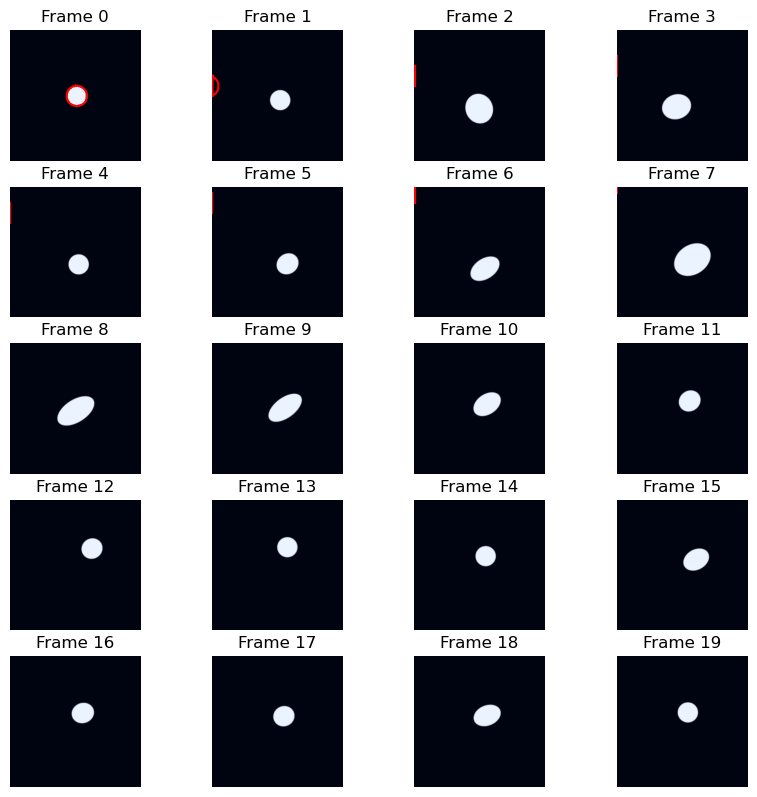

Epoch 500, IOU: 0.049799
Epoch 501, Loss: 365.41
Epoch 502, Loss: 312.73
Epoch 503, Loss: 293.22
Epoch 504, Loss: 231.40
Epoch 505, Loss: 175.13


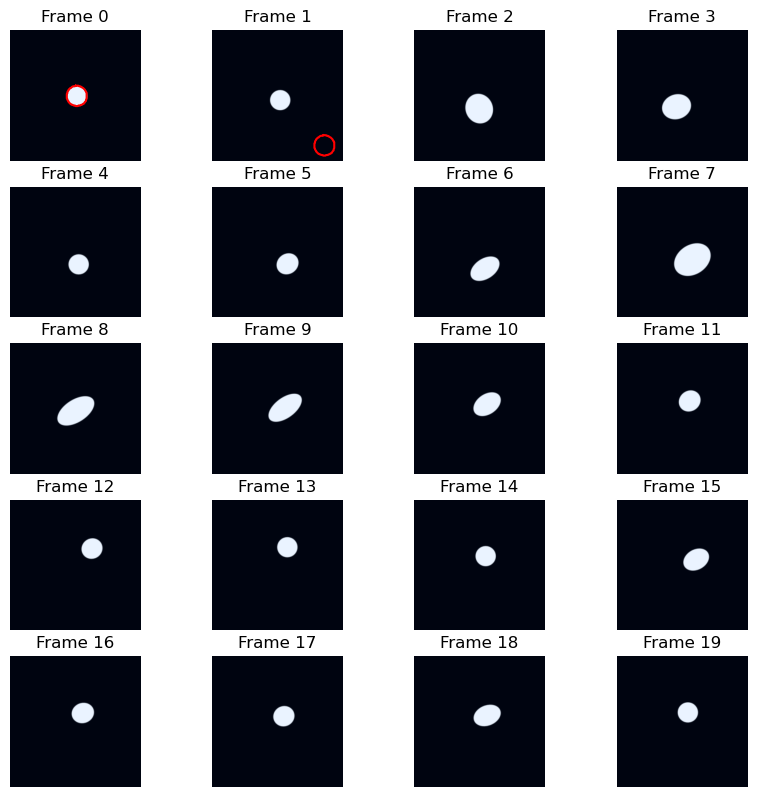

Epoch 505, IOU: 0.049799
Epoch 506, Loss: 624.58
Epoch 507, Loss: 482.10
Epoch 508, Loss: 433.20
Epoch 509, Loss: 313.63
Epoch 510, Loss: 297.84


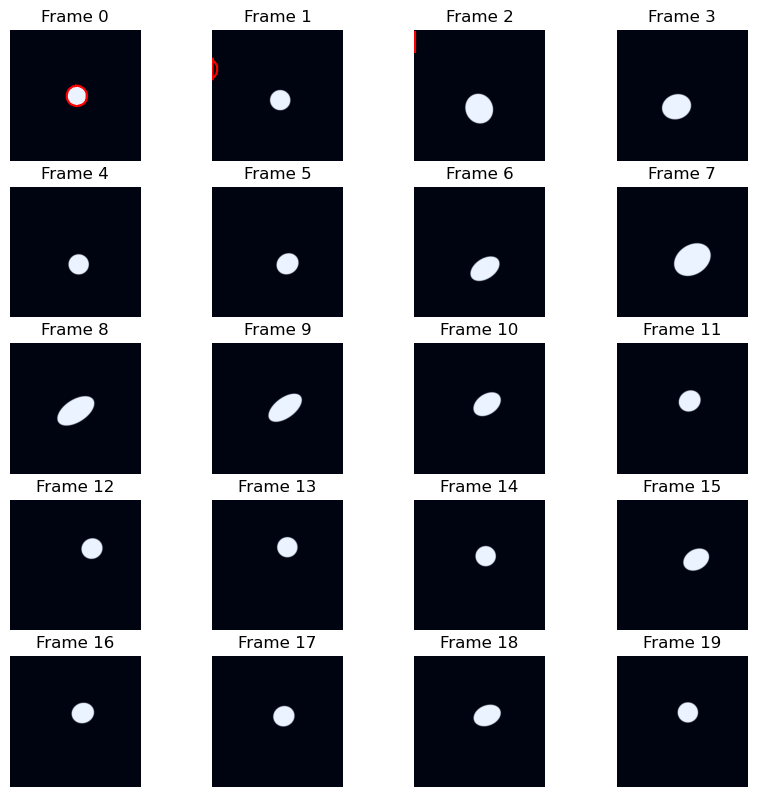

Epoch 510, IOU: 0.049799
Epoch 511, Loss: 393.21
Epoch 512, Loss: 372.17
Epoch 513, Loss: 337.86
Epoch 514, Loss: 259.19
Epoch 515, Loss: 214.46


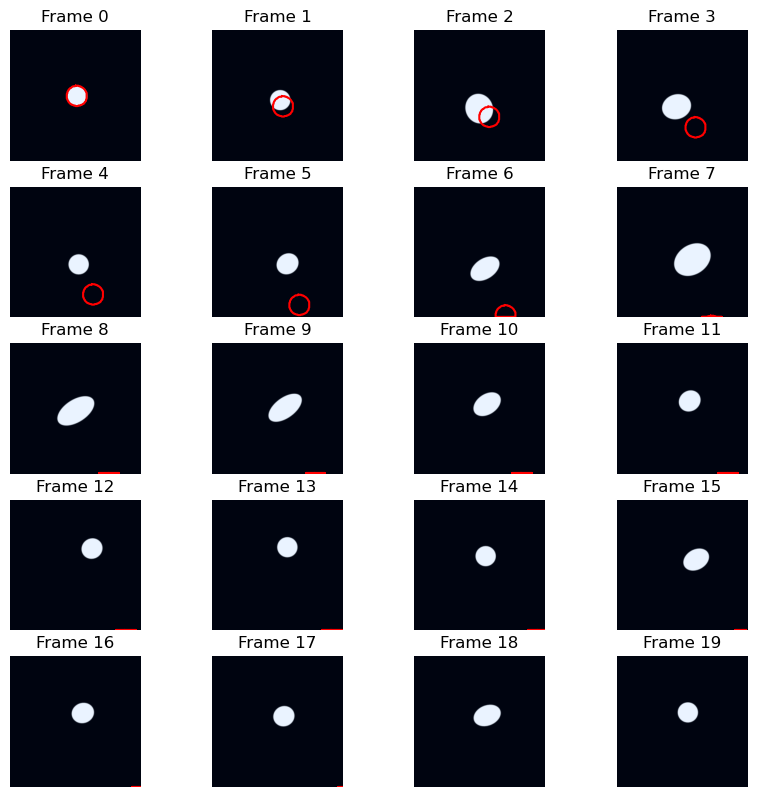

Epoch 515, IOU: 0.080332
Epoch 516, Loss: 283.10
Epoch 517, Loss: 272.72
Epoch 518, Loss: 248.52
Epoch 519, Loss: 224.67
Epoch 520, Loss: 184.37


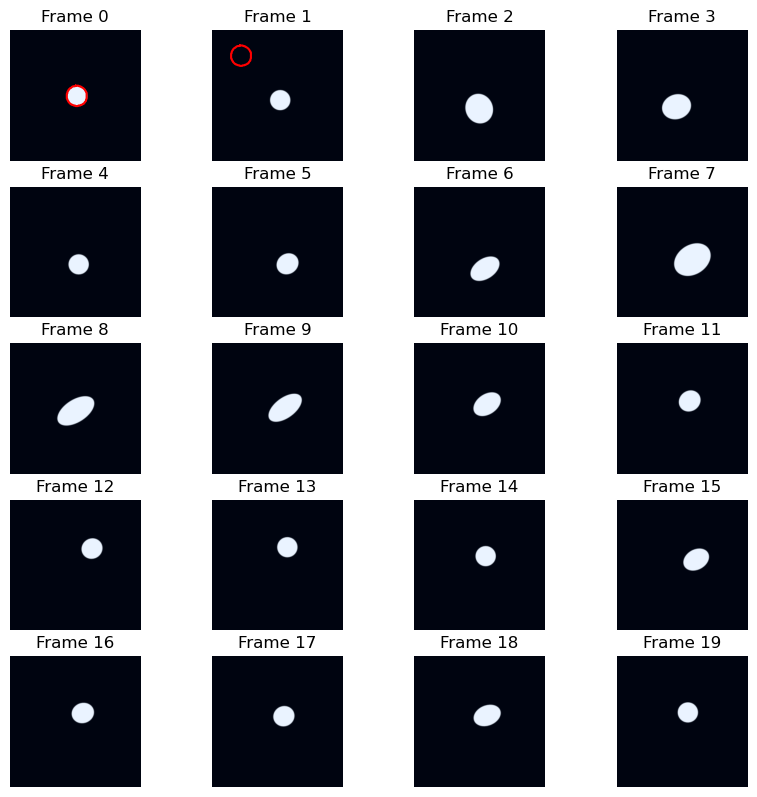

Epoch 520, IOU: 0.049799
Epoch 521, Loss: 333.58
Epoch 522, Loss: 281.09
Epoch 523, Loss: 246.07
Epoch 524, Loss: 214.36
Epoch 525, Loss: 171.87


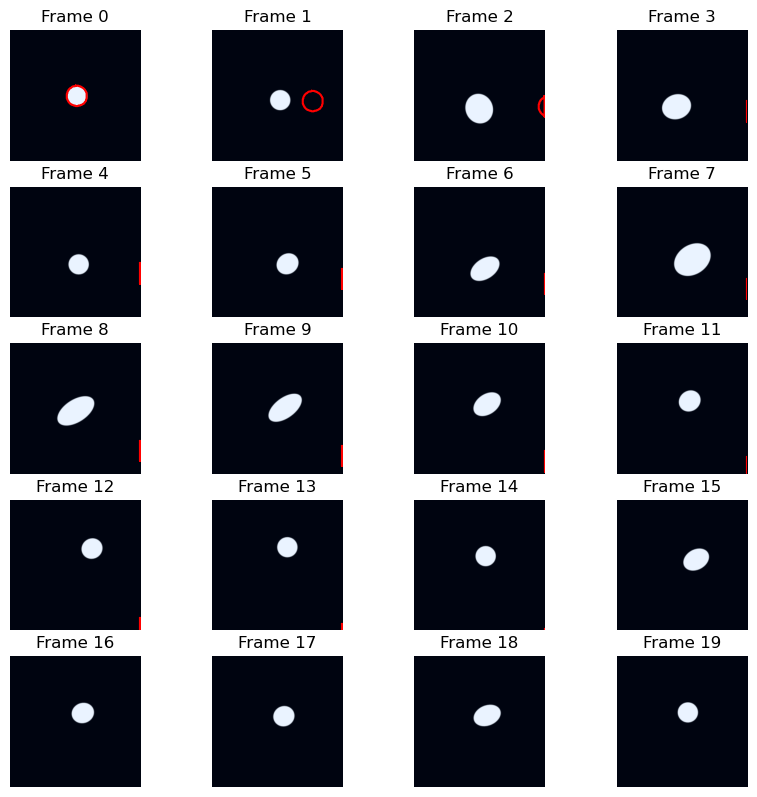

Epoch 525, IOU: 0.049799
Epoch 526, Loss: 419.65
Epoch 527, Loss: 352.27
Epoch 528, Loss: 262.96
Epoch 529, Loss: 206.82
Epoch 530, Loss: 223.22


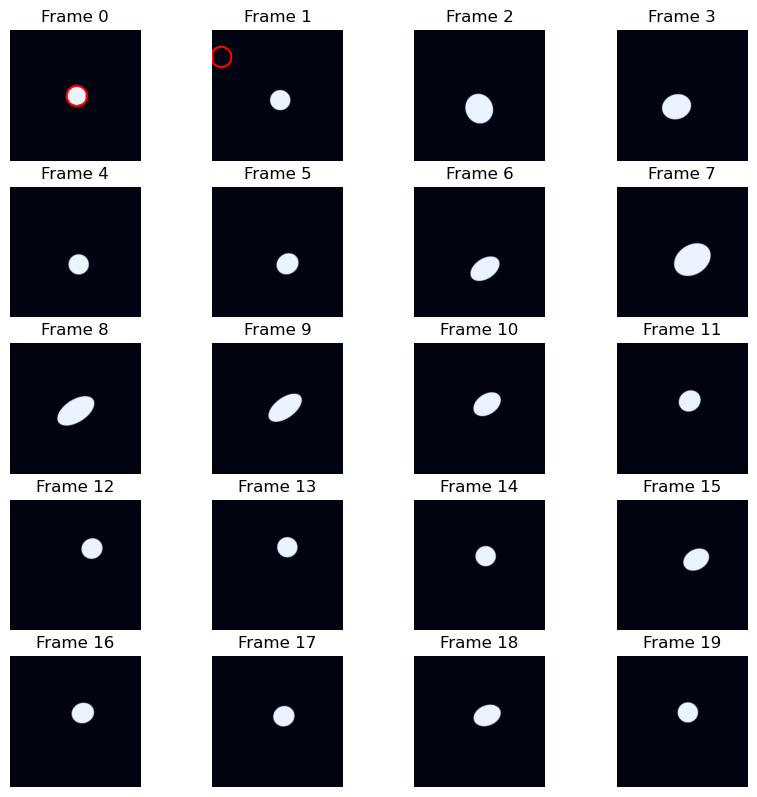

Epoch 530, IOU: 0.049799
Epoch 531, Loss: 327.92
Epoch 532, Loss: 280.71
Epoch 533, Loss: 242.31
Epoch 534, Loss: 194.82
Epoch 535, Loss: 170.61


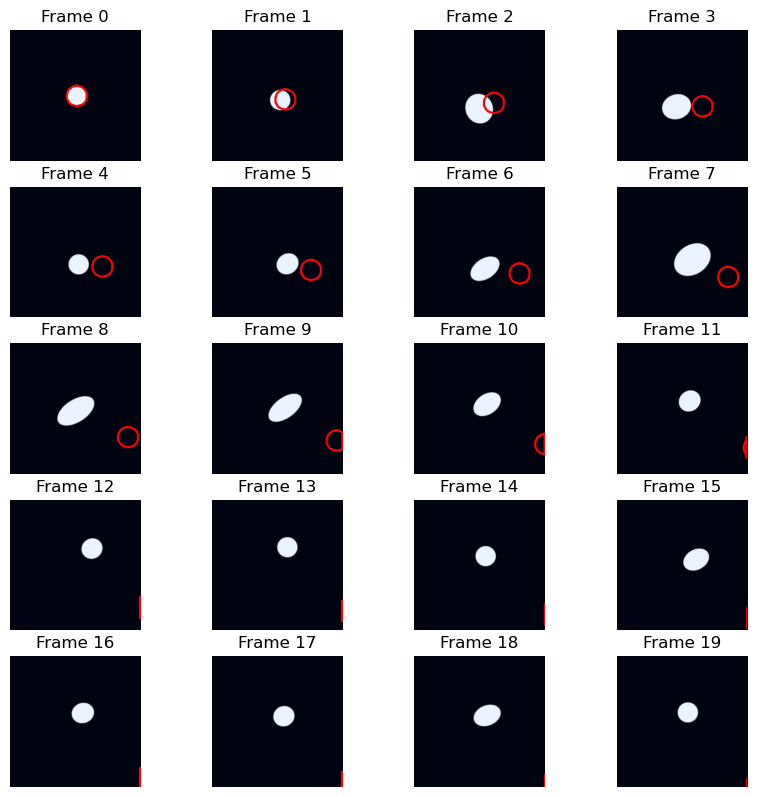

Epoch 535, IOU: 0.081768
Epoch 536, Loss: 220.03
Epoch 537, Loss: 153.56
Epoch 538, Loss: 216.30
Epoch 539, Loss: 175.10
Epoch 540, Loss: 176.03


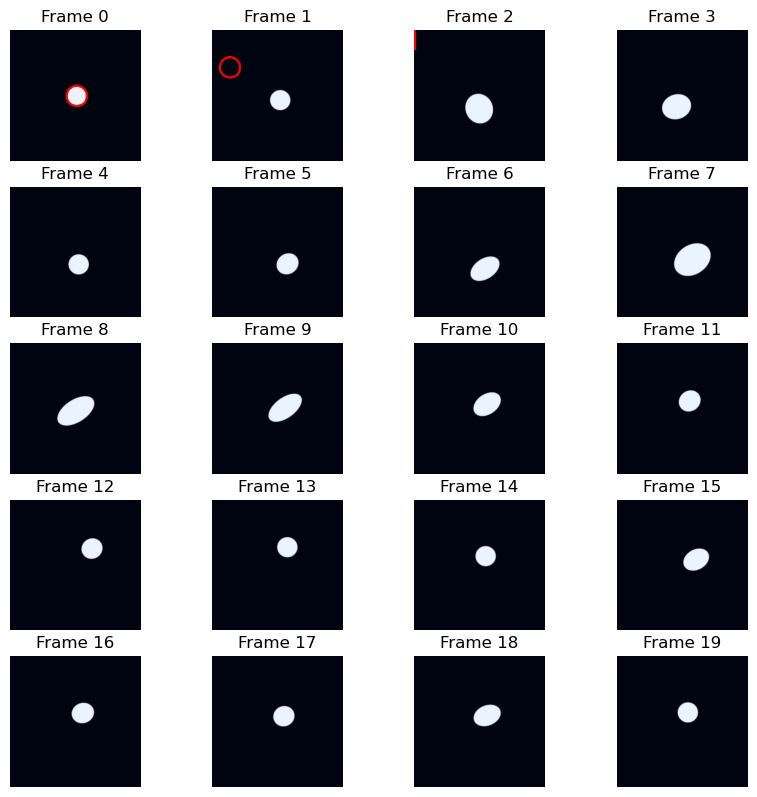

Epoch 540, IOU: 0.049799
Epoch 541, Loss: 250.37
Epoch 542, Loss: 211.38
Epoch 543, Loss: 157.91
Epoch 544, Loss: 123.37
Epoch 545, Loss: 106.31


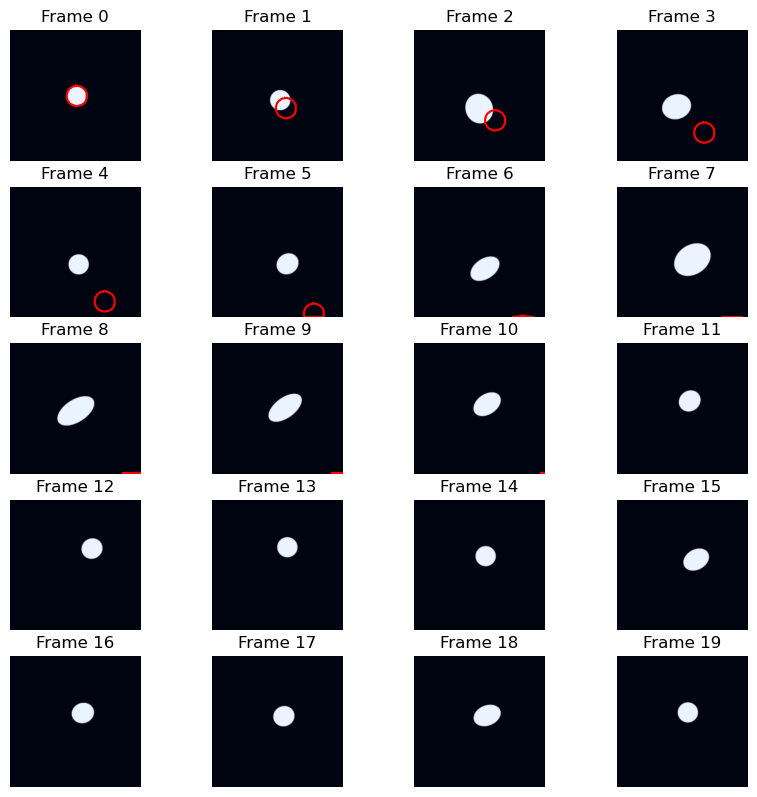

Epoch 545, IOU: 0.065158
Epoch 546, Loss: 396.14
Epoch 547, Loss: 341.80
Epoch 548, Loss: 243.94
Epoch 549, Loss: 234.42
Epoch 550, Loss: 241.49


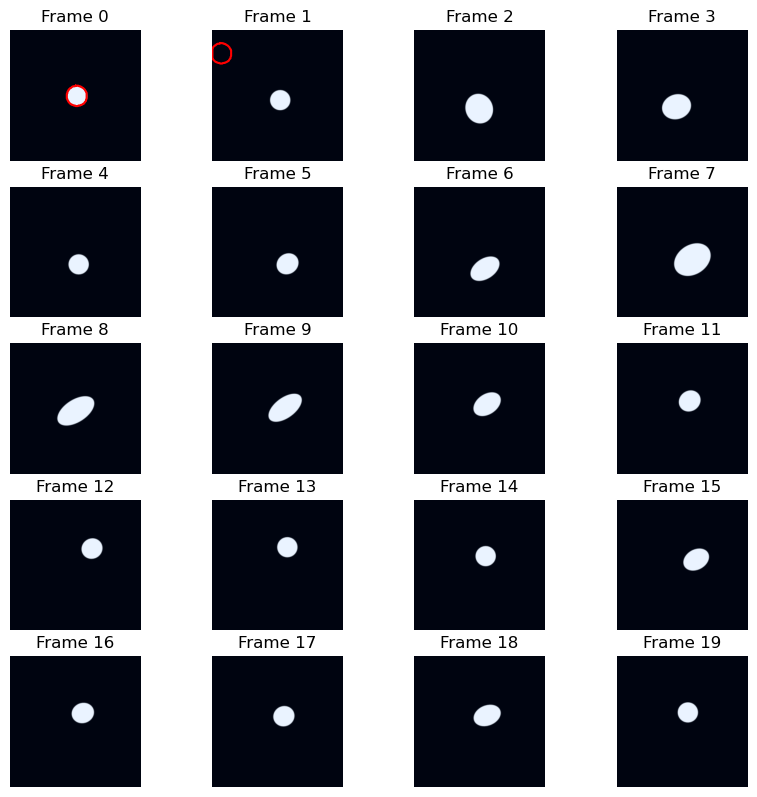

Epoch 550, IOU: 0.049799
Epoch 551, Loss: 241.43
Epoch 552, Loss: 210.69
Epoch 553, Loss: 179.53
Epoch 554, Loss: 130.14
Epoch 555, Loss: 109.98


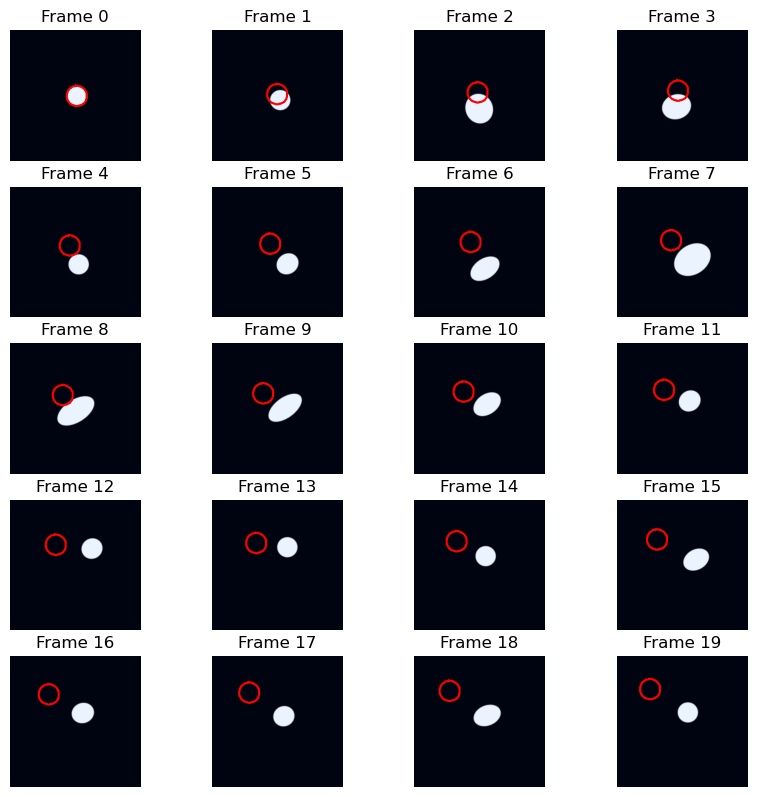

Epoch 555, IOU: 0.084964
Epoch 556, Loss: 112.34
Epoch 557, Loss: 71.06
Epoch 558, Loss: 74.28
Epoch 559, Loss: 95.86
Epoch 560, Loss: 90.76


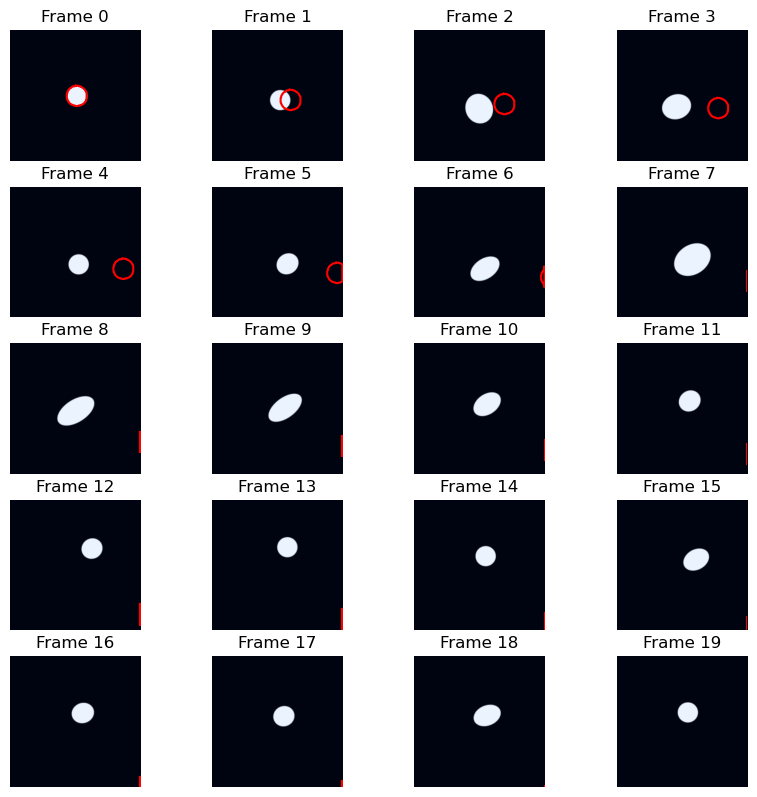

Epoch 560, IOU: 0.061628
Epoch 561, Loss: 281.70
Epoch 562, Loss: 234.34
Epoch 563, Loss: 225.34
Epoch 564, Loss: 178.68
Epoch 565, Loss: 208.27


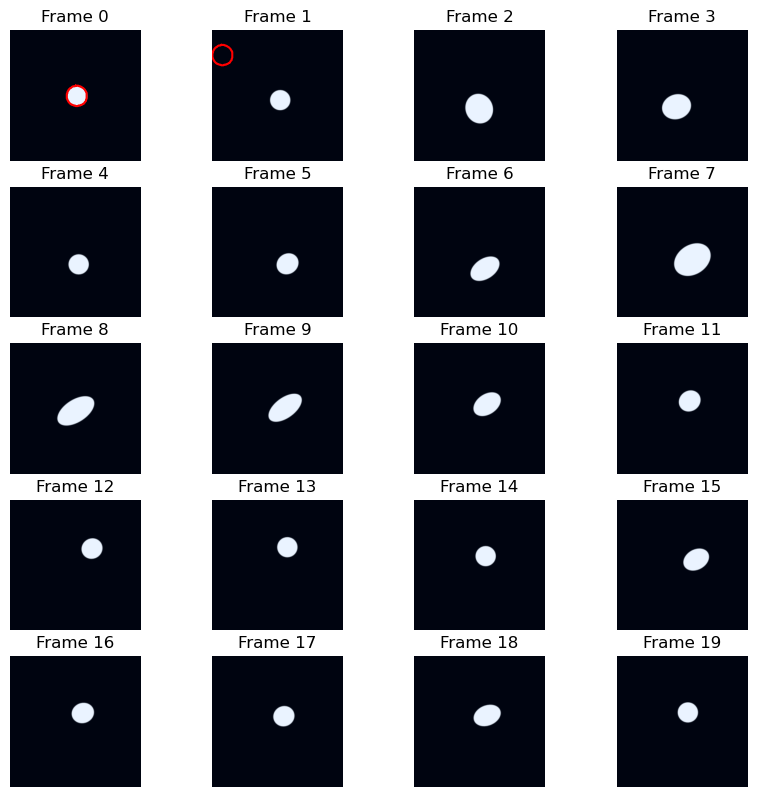

Epoch 565, IOU: 0.049799
Epoch 566, Loss: 198.32
Epoch 567, Loss: 238.39
Epoch 568, Loss: 264.43
Epoch 569, Loss: 250.93
Epoch 570, Loss: 162.09


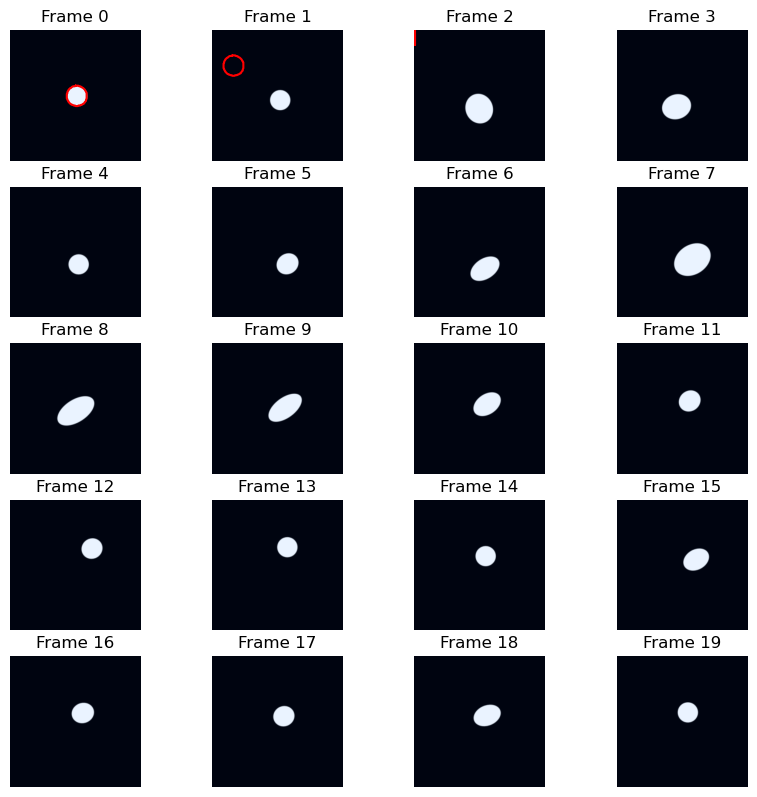

Epoch 570, IOU: 0.049799
Epoch 571, Loss: 143.68
Epoch 572, Loss: 137.95
Epoch 573, Loss: 135.77
Epoch 574, Loss: 137.96
Epoch 575, Loss: 133.63


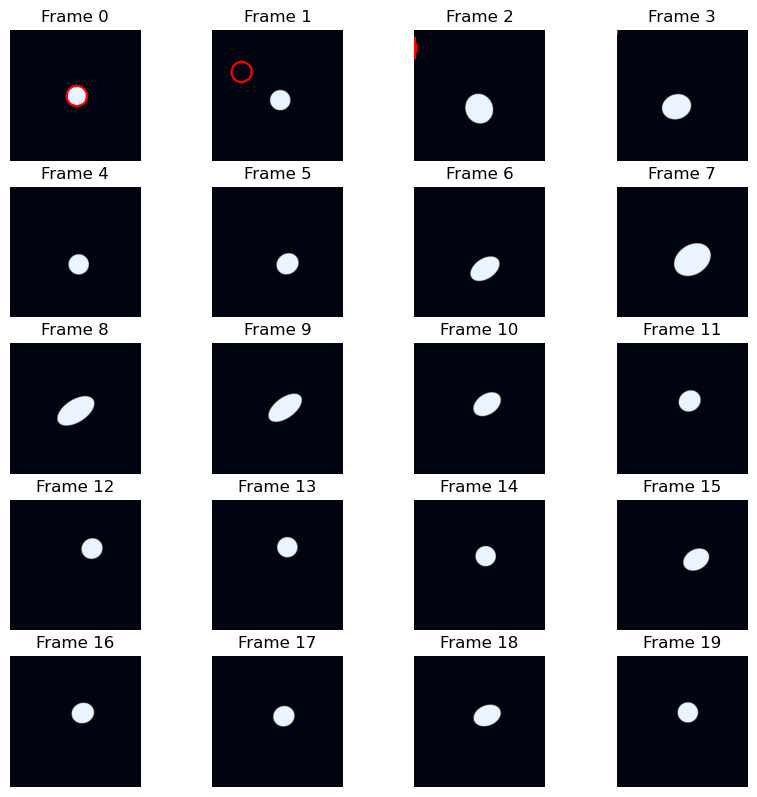

Epoch 575, IOU: 0.049799
Epoch 576, Loss: 132.90
Epoch 577, Loss: 133.82
Epoch 578, Loss: 139.65
Epoch 579, Loss: 134.39
Epoch 580, Loss: 126.32


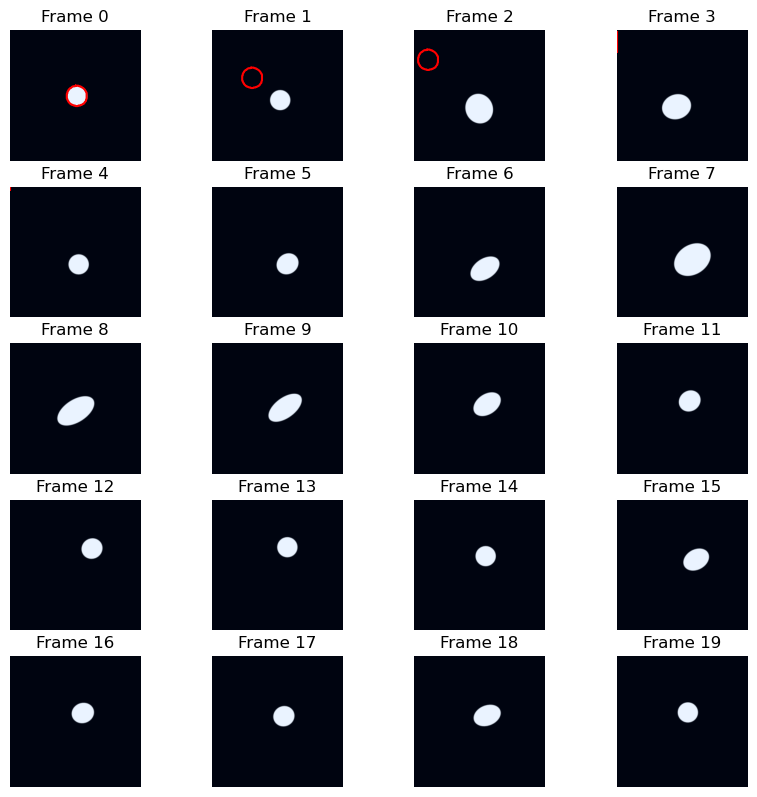

Epoch 580, IOU: 0.049799
Epoch 581, Loss: 131.80
Epoch 582, Loss: 125.96
Epoch 583, Loss: 137.06
Epoch 584, Loss: 138.92
Epoch 585, Loss: 139.70


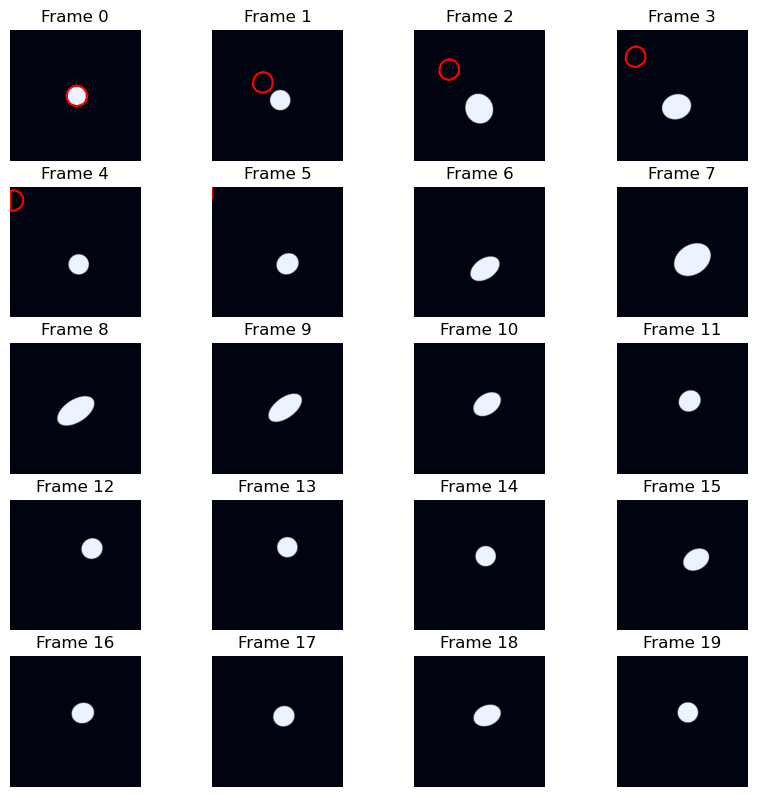

Epoch 585, IOU: 0.049799
Epoch 586, Loss: 136.17
Epoch 587, Loss: 124.22
Epoch 588, Loss: 150.82
Epoch 589, Loss: 144.45
Epoch 590, Loss: 136.21


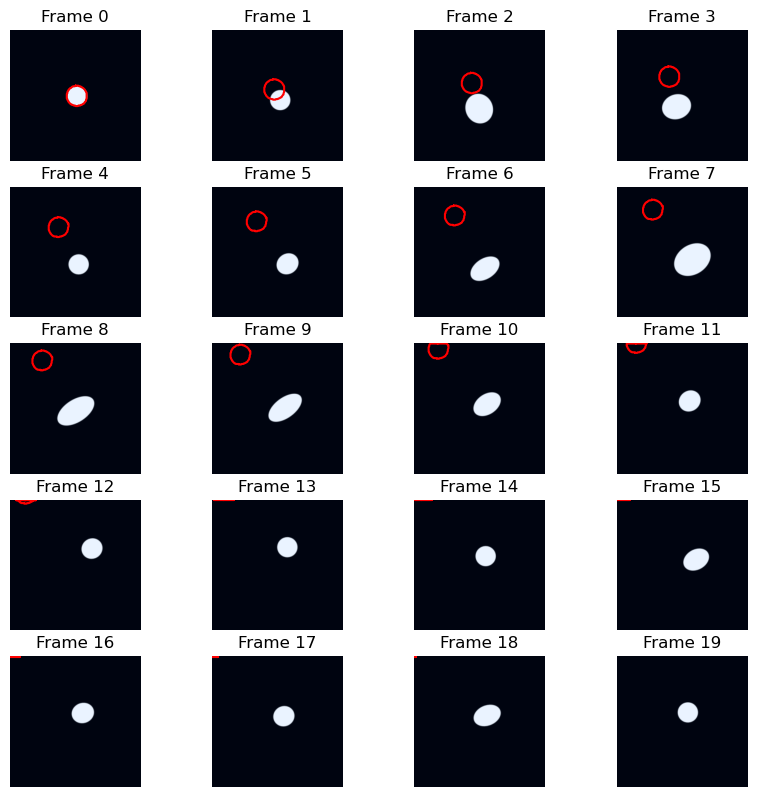

Epoch 590, IOU: 0.059111
Epoch 591, Loss: 155.01
Epoch 592, Loss: 126.37
Epoch 593, Loss: 124.44
Epoch 594, Loss: 113.78
Epoch 595, Loss: 122.38


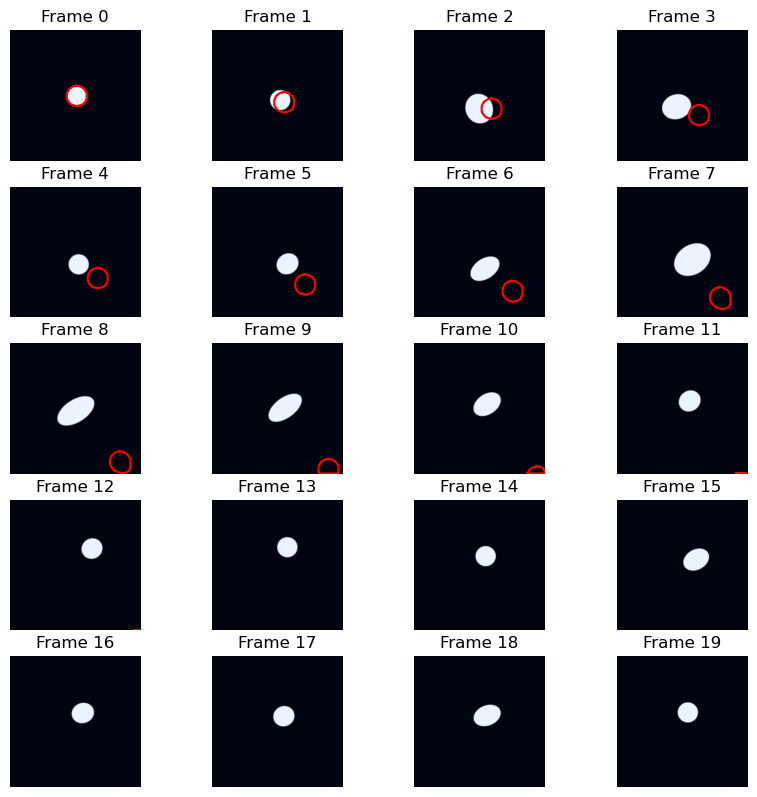

Epoch 595, IOU: 0.088077
Epoch 596, Loss: 384.79
Epoch 597, Loss: 266.90
Epoch 598, Loss: 195.74
Epoch 599, Loss: 195.05
Epoch 600, Loss: 169.55


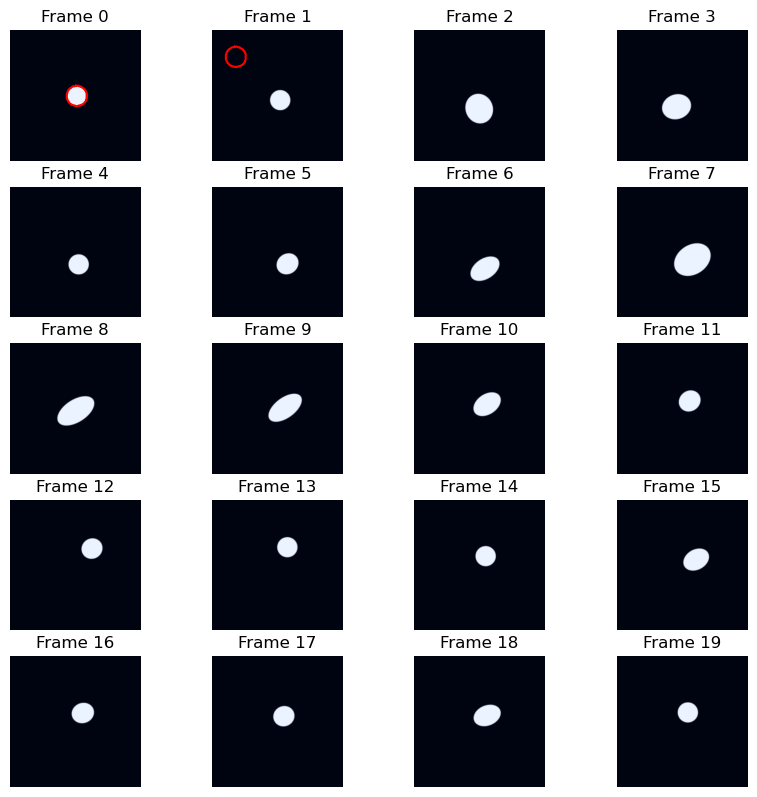

Epoch 600, IOU: 0.049799
Epoch 601, Loss: 359.01
Epoch 602, Loss: 140.13
Epoch 603, Loss: 145.48
Epoch 604, Loss: 136.18
Epoch 605, Loss: 133.39


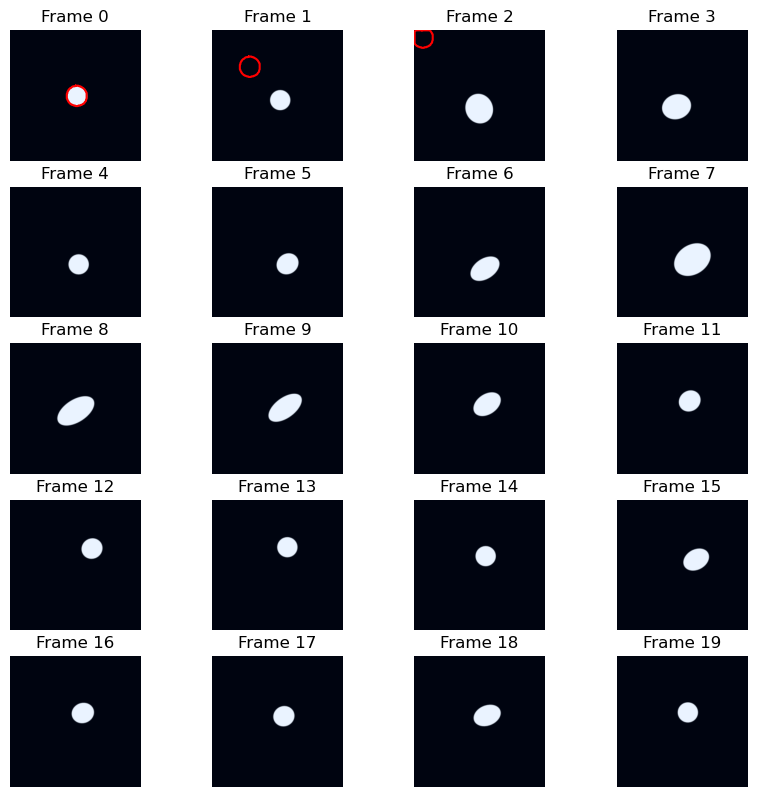

Epoch 605, IOU: 0.049799
Epoch 606, Loss: 125.39
Epoch 607, Loss: 133.23
Epoch 608, Loss: 151.69
Epoch 609, Loss: 274.29
Epoch 610, Loss: 183.57


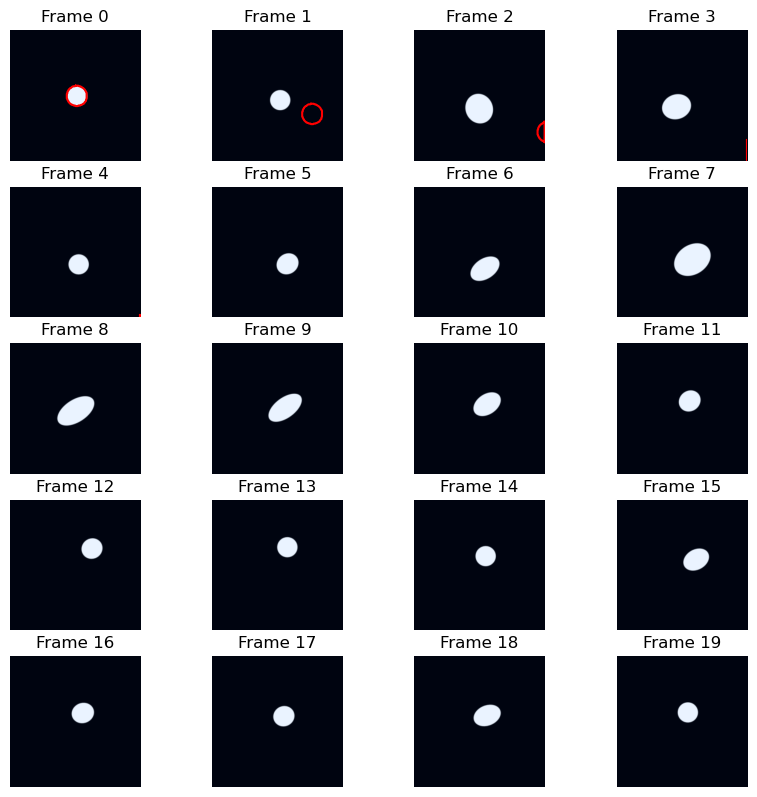

Epoch 610, IOU: 0.049799
Epoch 611, Loss: 507.92
Epoch 612, Loss: 417.74
Epoch 613, Loss: 357.13
Epoch 614, Loss: 235.03
Epoch 615, Loss: 186.95


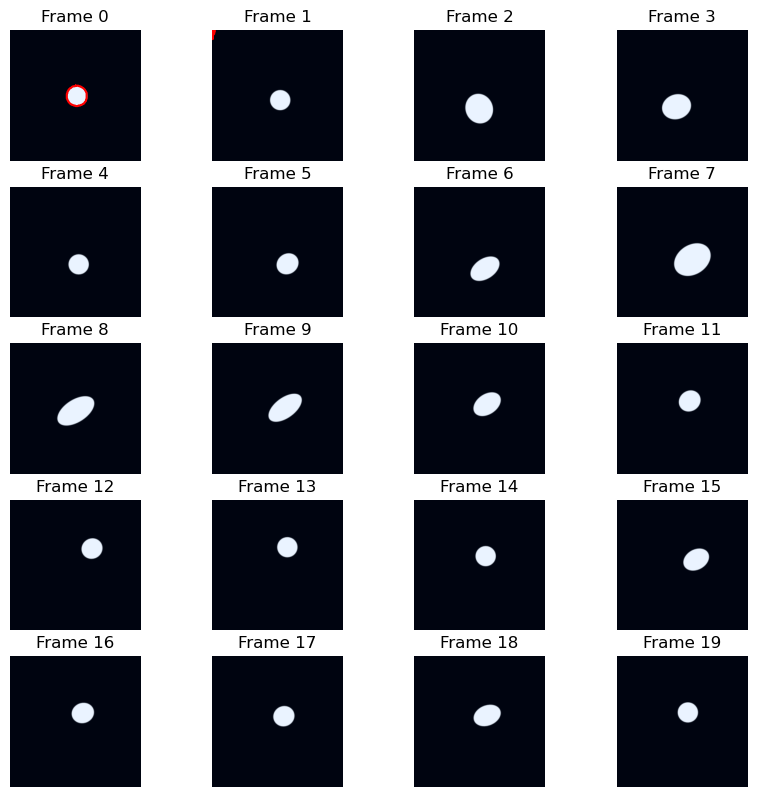

Epoch 615, IOU: 0.049799
Epoch 616, Loss: 307.47
Epoch 617, Loss: 226.45
Epoch 618, Loss: 113.76
Epoch 619, Loss: 98.19
Epoch 620, Loss: 80.77


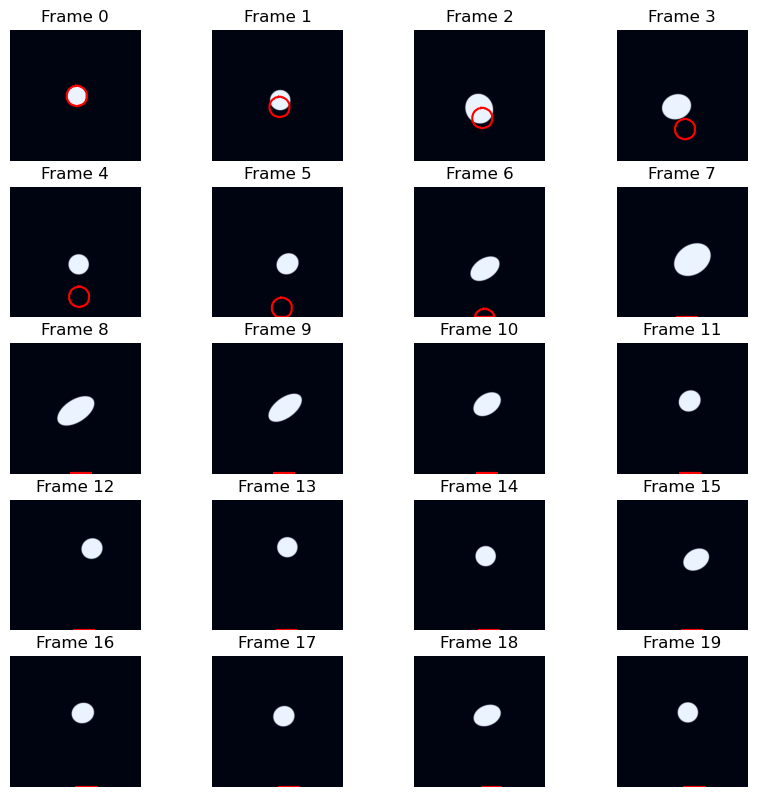

Epoch 620, IOU: 0.085595
Epoch 621, Loss: 212.97
Epoch 622, Loss: 196.82
Epoch 623, Loss: 156.23
Epoch 624, Loss: 138.74
Epoch 625, Loss: 146.98


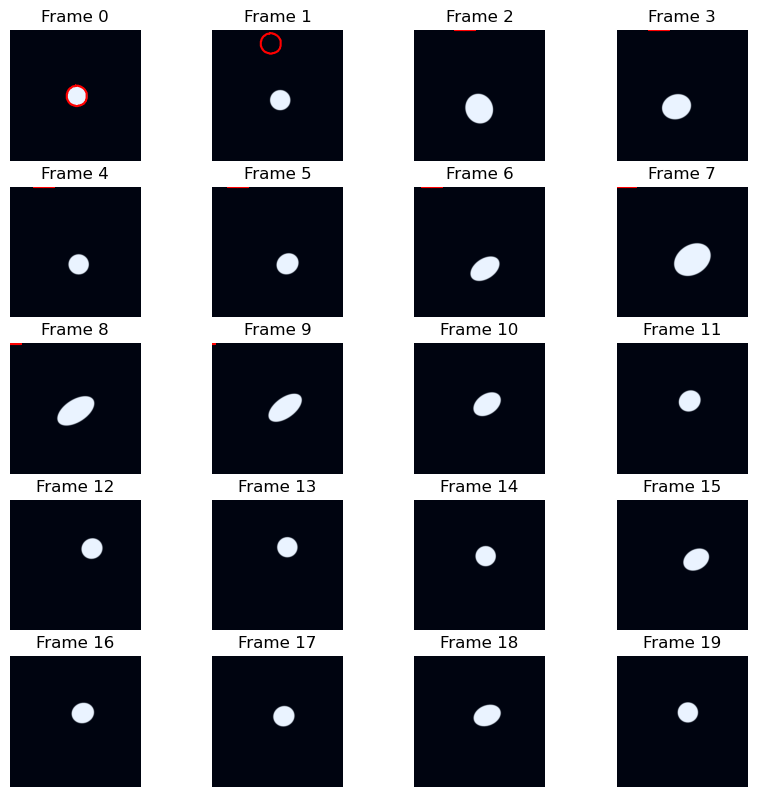

Epoch 625, IOU: 0.049799
Epoch 626, Loss: 277.28
Epoch 627, Loss: 250.48
Epoch 628, Loss: 276.63
Epoch 629, Loss: 225.50
Epoch 630, Loss: 190.21


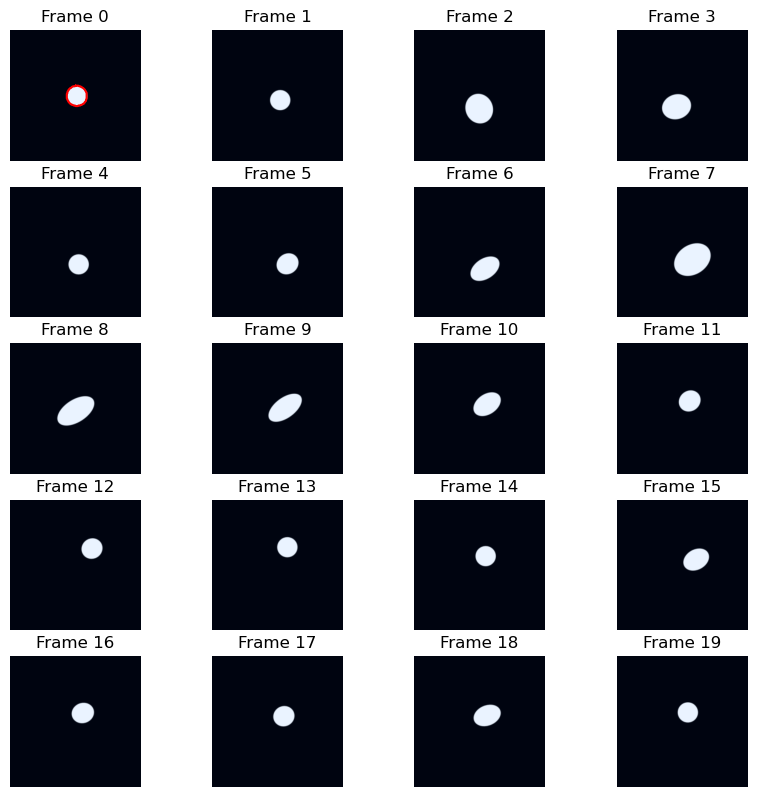

Epoch 630, IOU: 0.049799
Epoch 631, Loss: 675.68
Epoch 632, Loss: 465.29
Epoch 633, Loss: 316.45
Epoch 634, Loss: 200.97
Epoch 635, Loss: 191.88


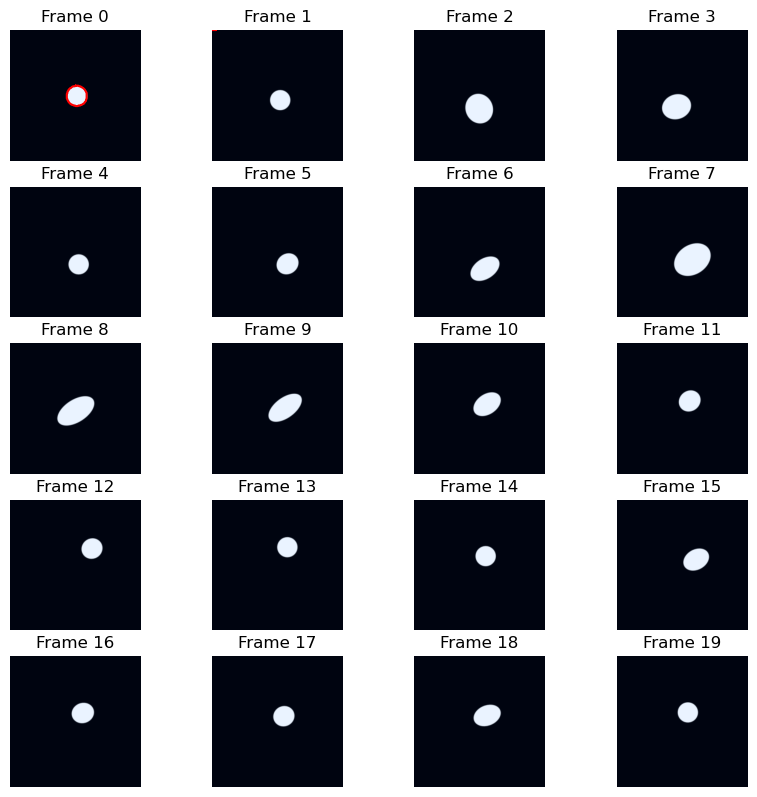

Epoch 635, IOU: 0.049799
Epoch 636, Loss: 761.84
Epoch 637, Loss: 715.21
Epoch 638, Loss: 663.22
Epoch 639, Loss: 673.60
Epoch 640, Loss: 618.08


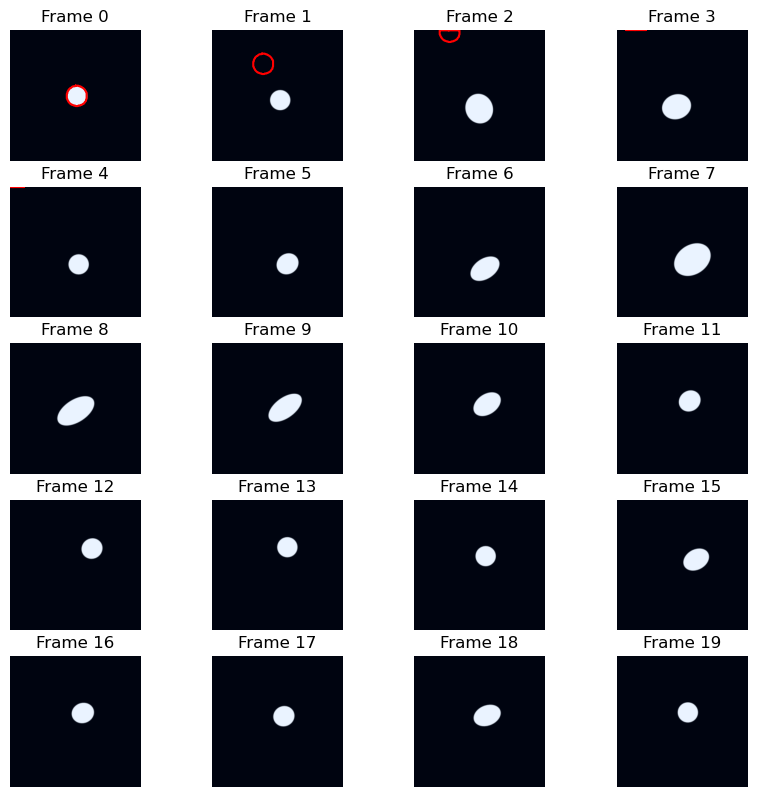

Epoch 640, IOU: 0.049799
Epoch 641, Loss: 550.42
Epoch 642, Loss: 525.39
Epoch 643, Loss: 348.26
Epoch 644, Loss: 280.35
Epoch 645, Loss: 187.70


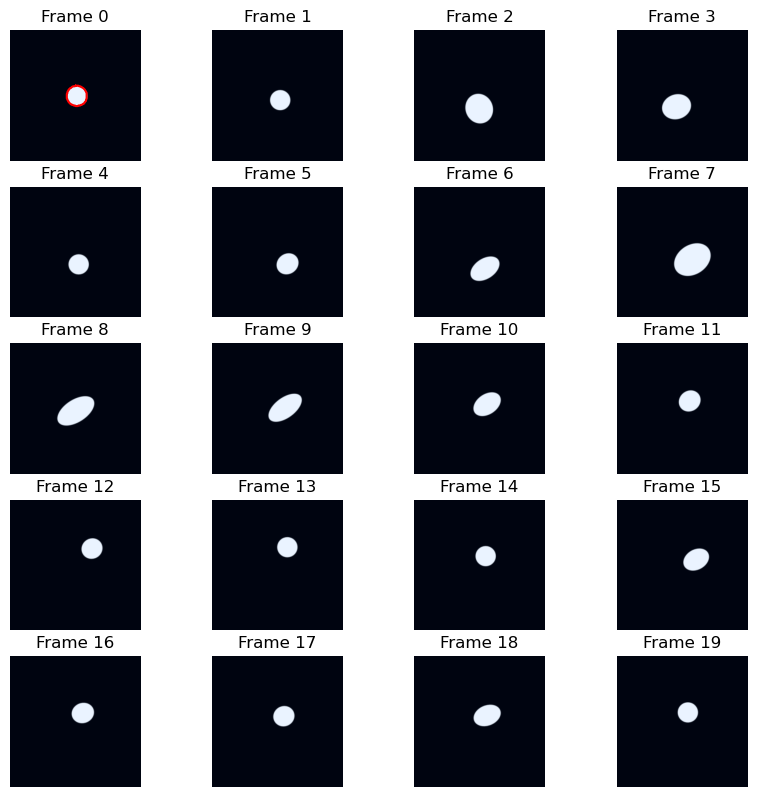

Epoch 645, IOU: 0.049799
Epoch 646, Loss: 711.09
Epoch 647, Loss: 659.37
Epoch 648, Loss: 583.24
Epoch 649, Loss: 539.88
Epoch 650, Loss: 518.54


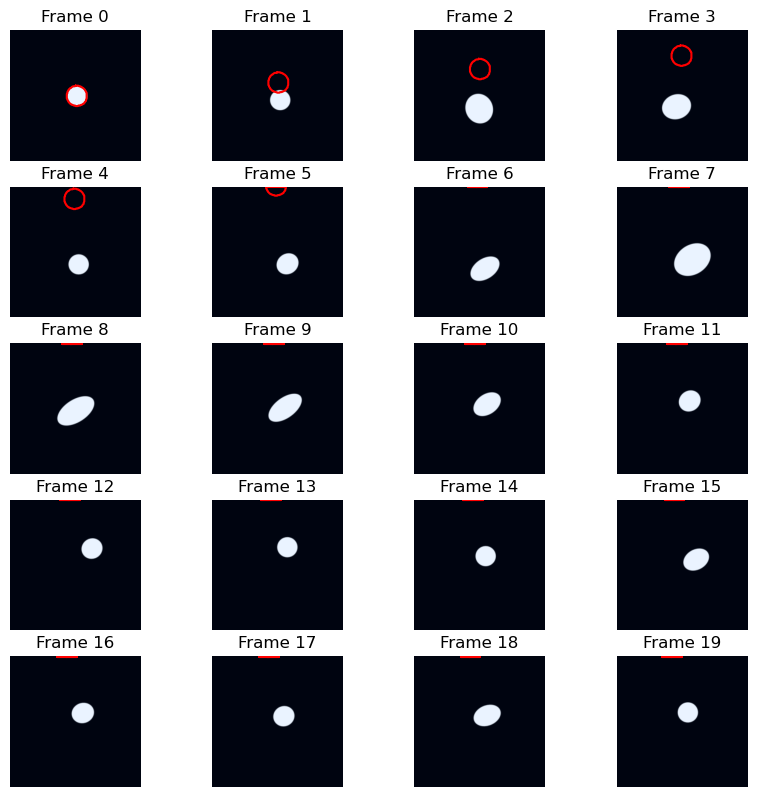

Epoch 650, IOU: 0.051685
Epoch 651, Loss: 254.13
Epoch 652, Loss: 219.56
Epoch 653, Loss: 236.62
Epoch 654, Loss: 162.95
Epoch 655, Loss: 158.67


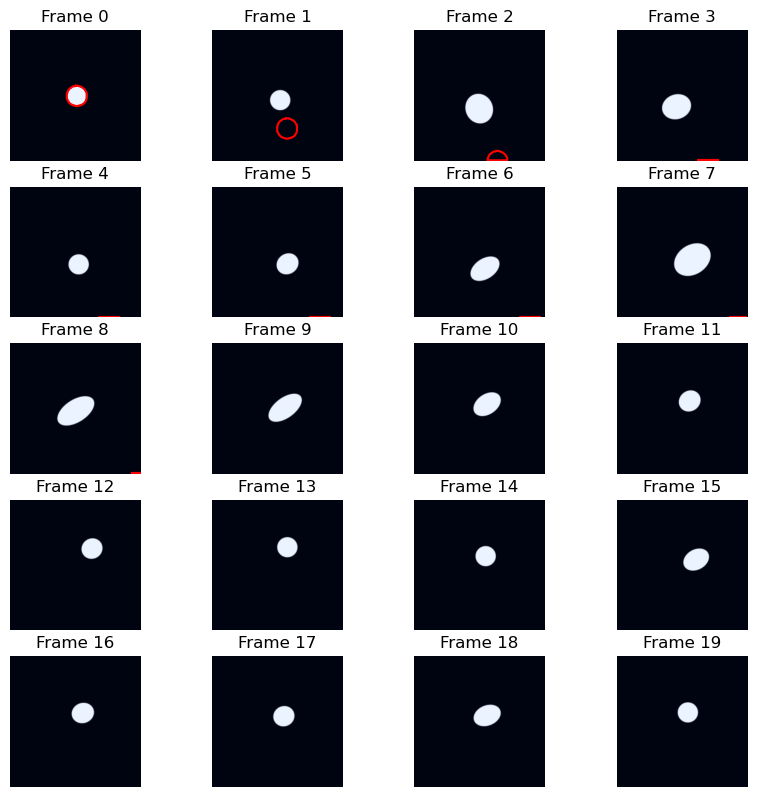

Epoch 655, IOU: 0.049799
Epoch 656, Loss: 481.40
Epoch 657, Loss: 360.54
Epoch 658, Loss: 357.17
Epoch 659, Loss: 302.03
Epoch 660, Loss: 265.36


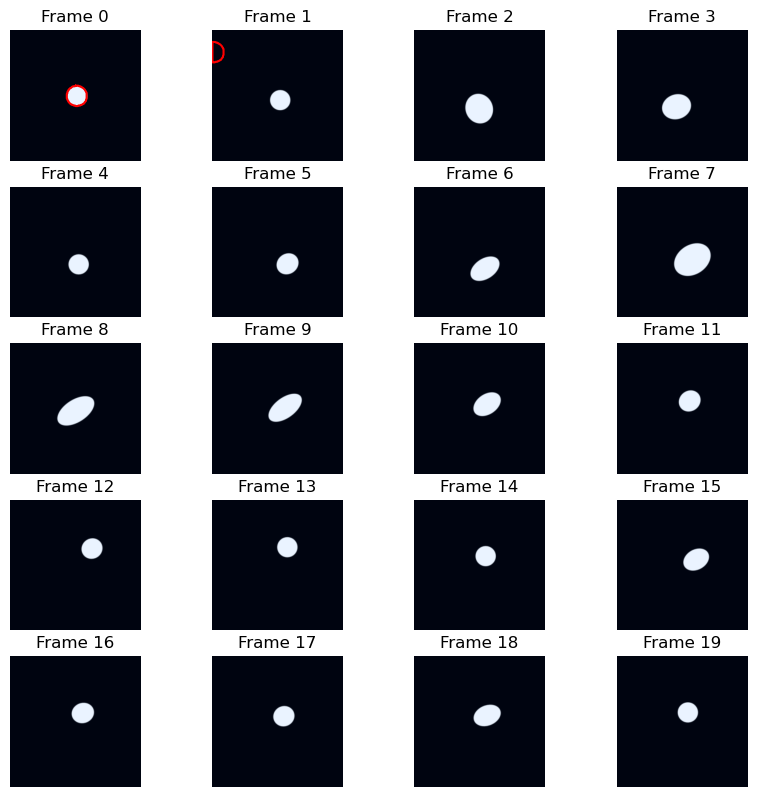

Epoch 660, IOU: 0.049799
Epoch 661, Loss: 673.73
Epoch 662, Loss: 666.72
Epoch 663, Loss: 629.38
Epoch 664, Loss: 586.87
Epoch 665, Loss: 571.74


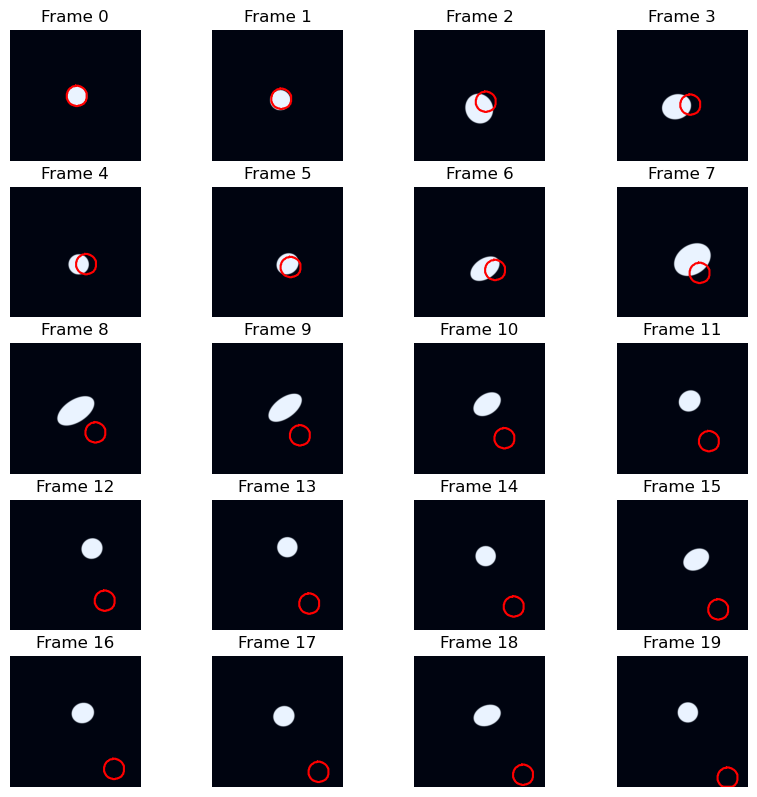

Epoch 665, IOU: 0.184229
Epoch 666, Loss: 176.73
Epoch 667, Loss: 115.45
Epoch 668, Loss: 104.31
Epoch 669, Loss: 94.41
Epoch 670, Loss: 84.25


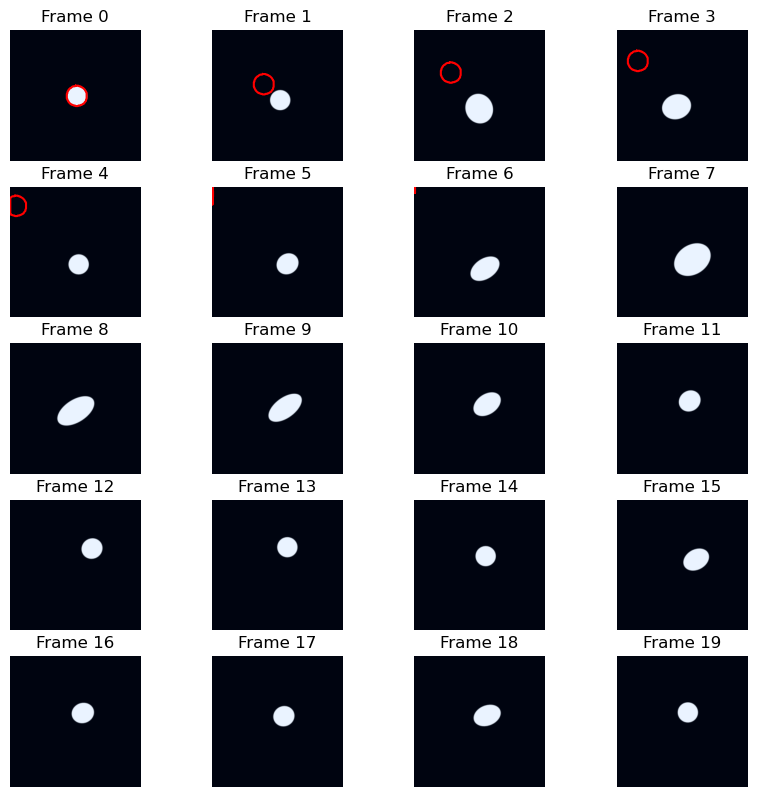

Epoch 670, IOU: 0.049799
Epoch 671, Loss: 505.09
Epoch 672, Loss: 403.98
Epoch 673, Loss: 298.25
Epoch 674, Loss: 322.02
Epoch 675, Loss: 211.10


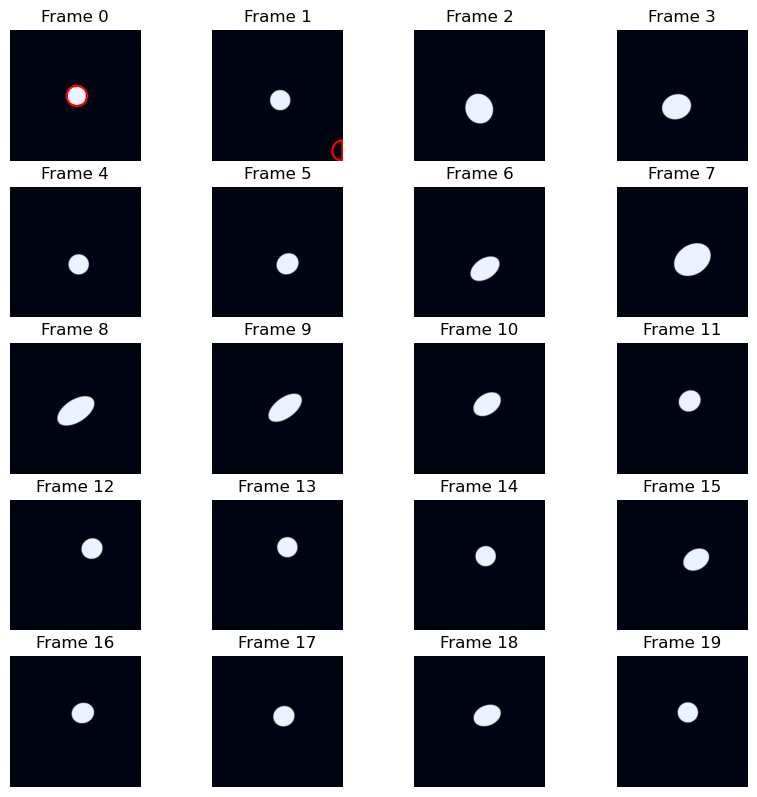

Epoch 675, IOU: 0.049799
Epoch 676, Loss: 654.08
Epoch 677, Loss: 601.25
Epoch 678, Loss: 586.12
Epoch 679, Loss: 581.23
Epoch 680, Loss: 527.02


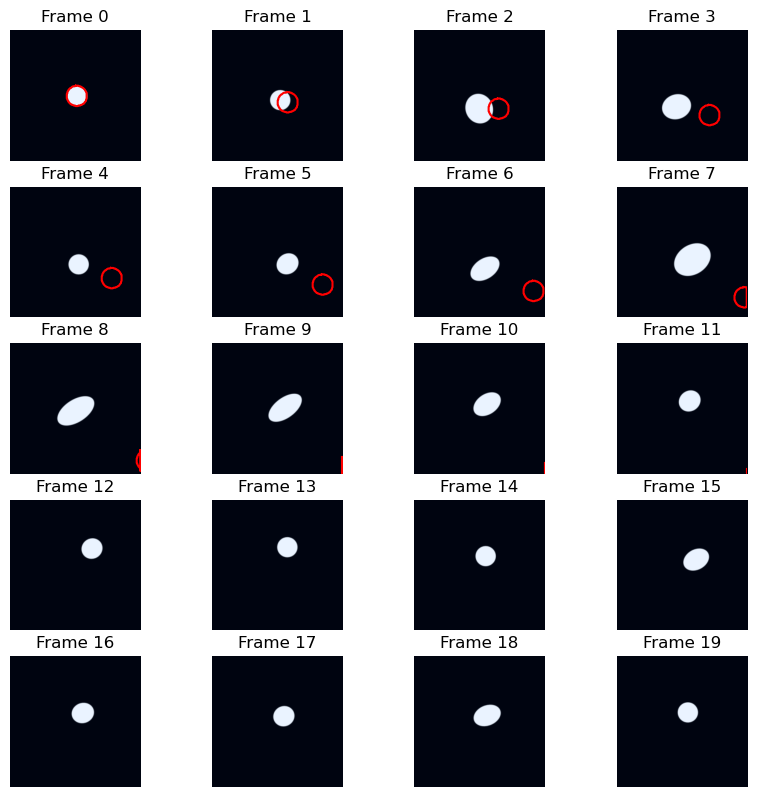

Epoch 680, IOU: 0.070176
Epoch 681, Loss: 306.46
Epoch 682, Loss: 284.40
Epoch 683, Loss: 276.00
Epoch 684, Loss: 240.47
Epoch 685, Loss: 190.92


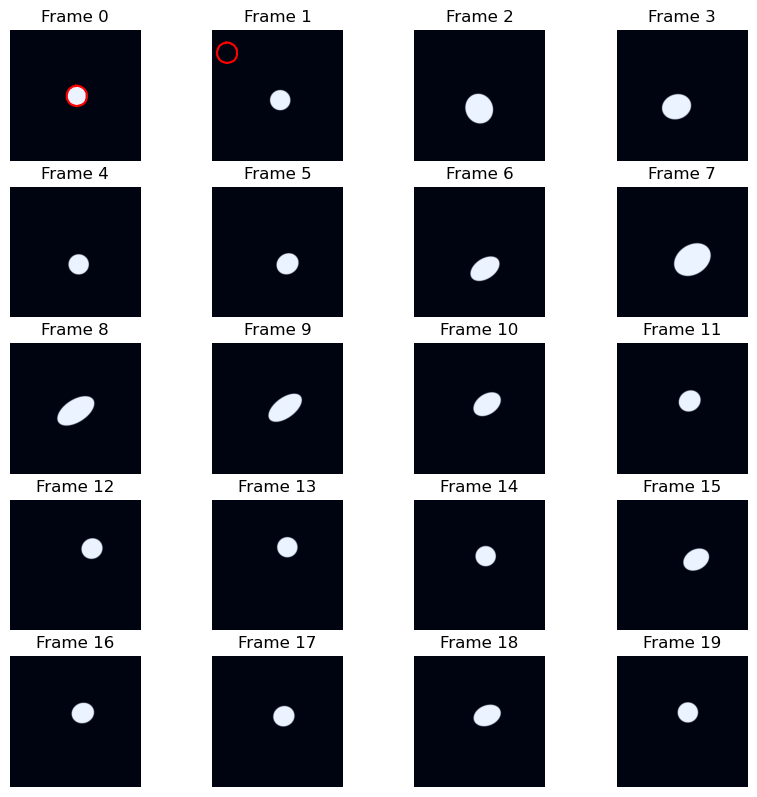

Epoch 685, IOU: 0.049799
Epoch 686, Loss: 630.56
Epoch 687, Loss: 650.28
Epoch 688, Loss: 627.41
Epoch 689, Loss: 535.07
Epoch 690, Loss: 556.72


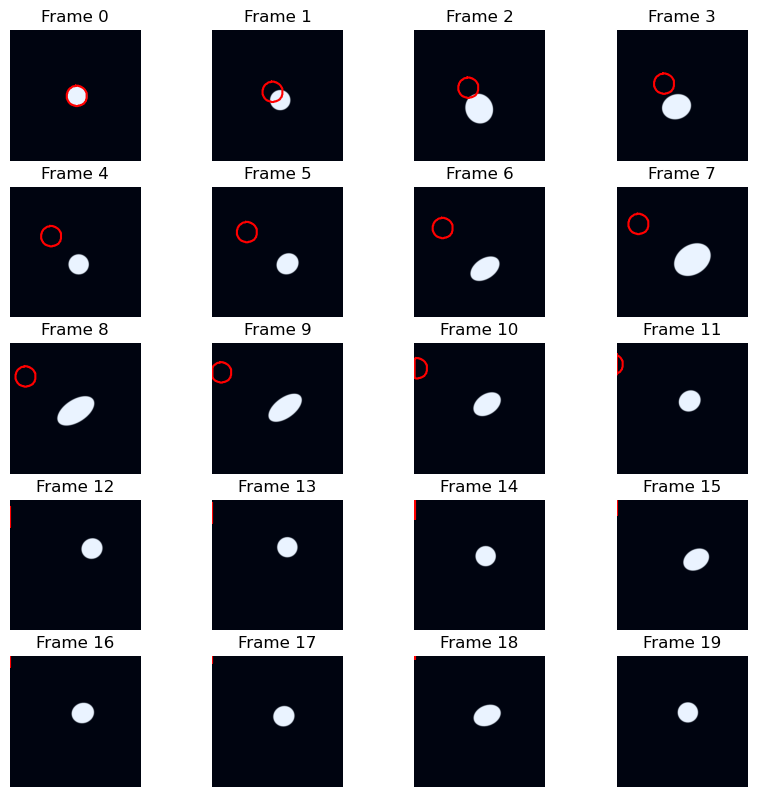

Epoch 690, IOU: 0.061433
Epoch 691, Loss: 318.90
Epoch 692, Loss: 255.42
Epoch 693, Loss: 234.47
Epoch 694, Loss: 133.45
Epoch 695, Loss: 176.20


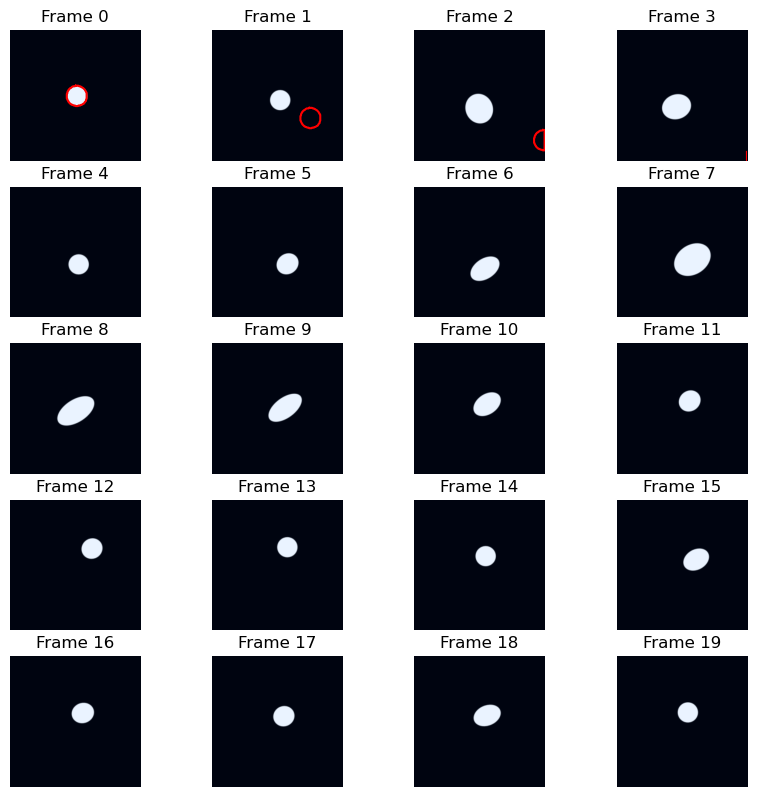

Epoch 695, IOU: 0.049799
Epoch 696, Loss: 521.26
Epoch 697, Loss: 462.93
Epoch 698, Loss: 481.96
Epoch 699, Loss: 428.65
Epoch 700, Loss: 321.44


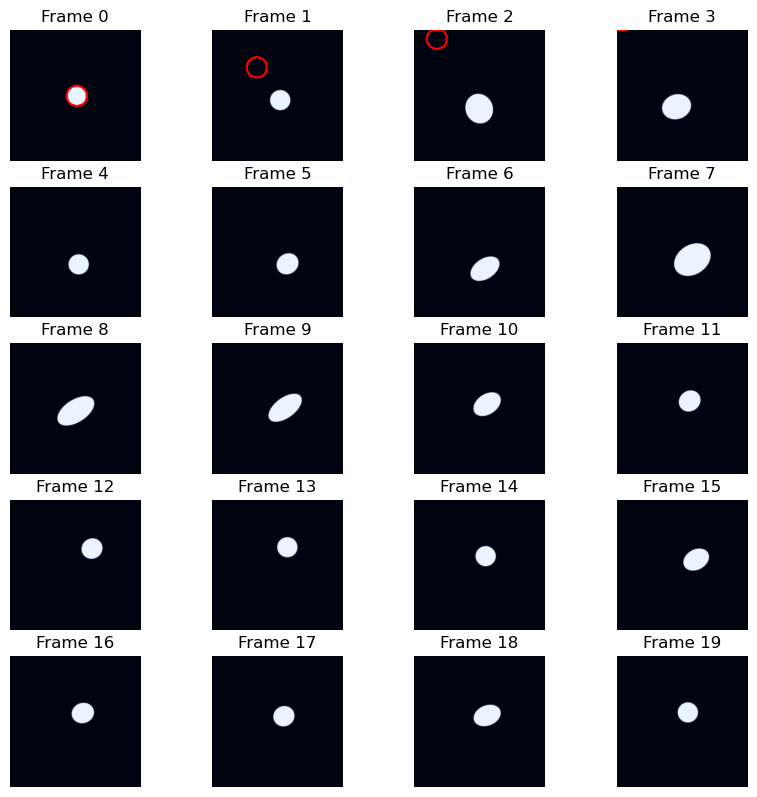

Epoch 700, IOU: 0.049799
Epoch 701, Loss: 538.39
Epoch 702, Loss: 539.55
Epoch 703, Loss: 545.08
Epoch 704, Loss: 470.77
Epoch 705, Loss: 449.51


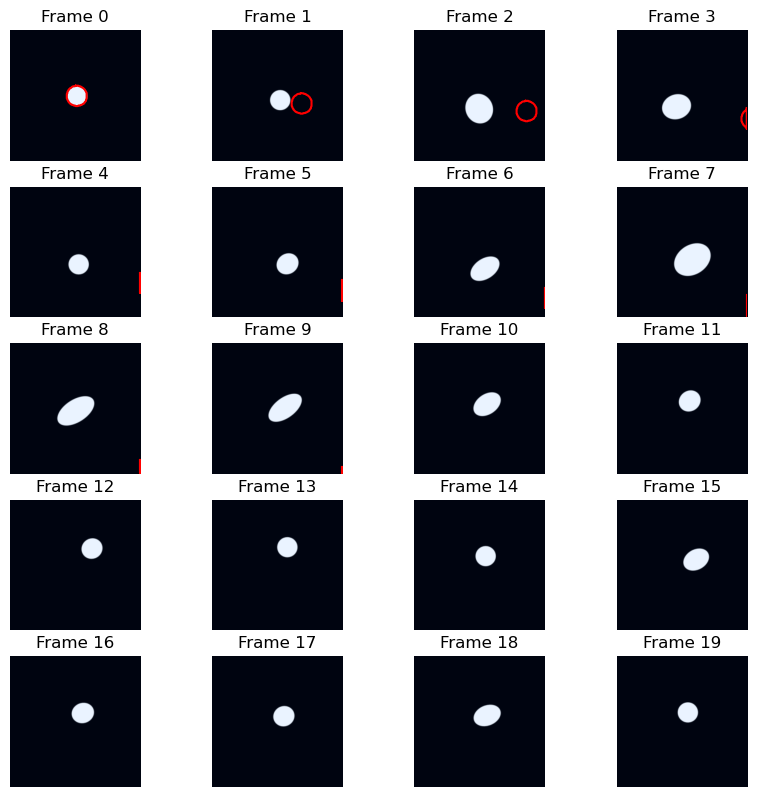

Epoch 705, IOU: 0.049799
Epoch 706, Loss: 469.05
Epoch 707, Loss: 434.14
Epoch 708, Loss: 402.25
Epoch 709, Loss: 364.11
Epoch 710, Loss: 309.55


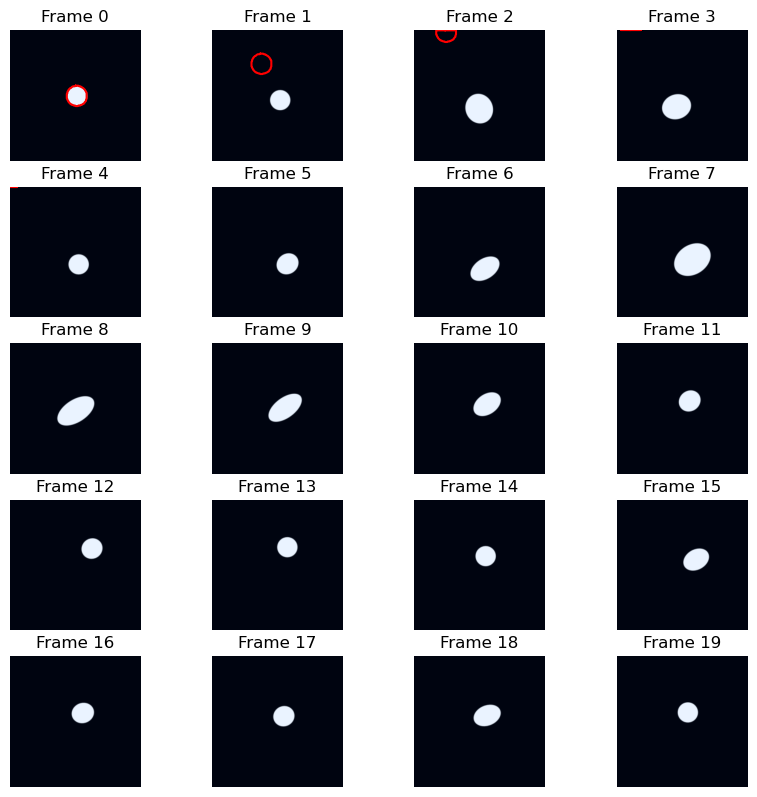

Epoch 710, IOU: 0.049799
Epoch 711, Loss: 568.66
Epoch 712, Loss: 595.56
Epoch 713, Loss: 466.92
Epoch 714, Loss: 513.08
Epoch 715, Loss: 463.50


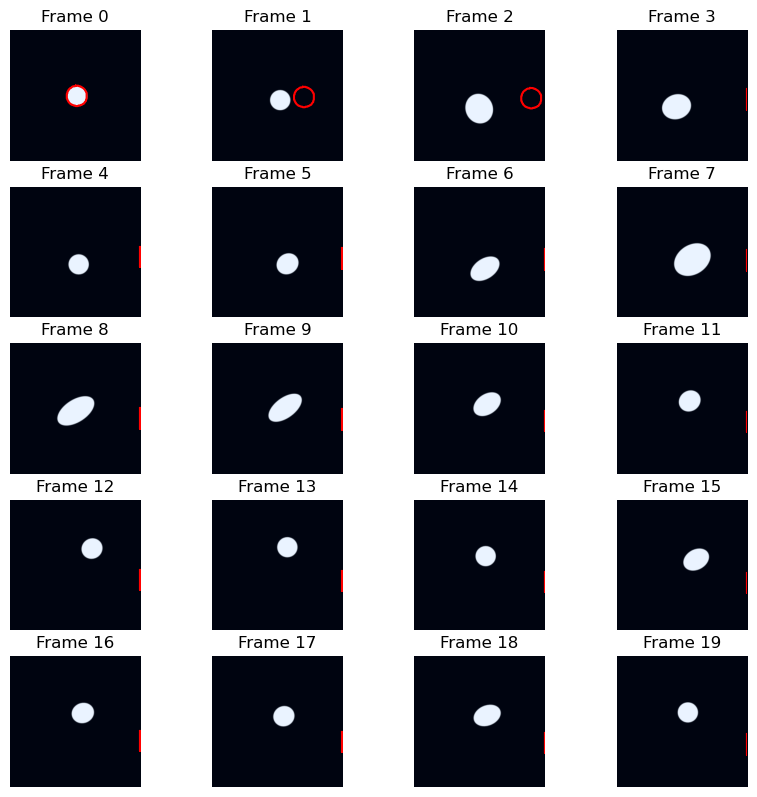

Epoch 715, IOU: 0.049799
Epoch 716, Loss: 298.16
Epoch 717, Loss: 323.81
Epoch 718, Loss: 270.87
Epoch 719, Loss: 268.96
Epoch 720, Loss: 258.84


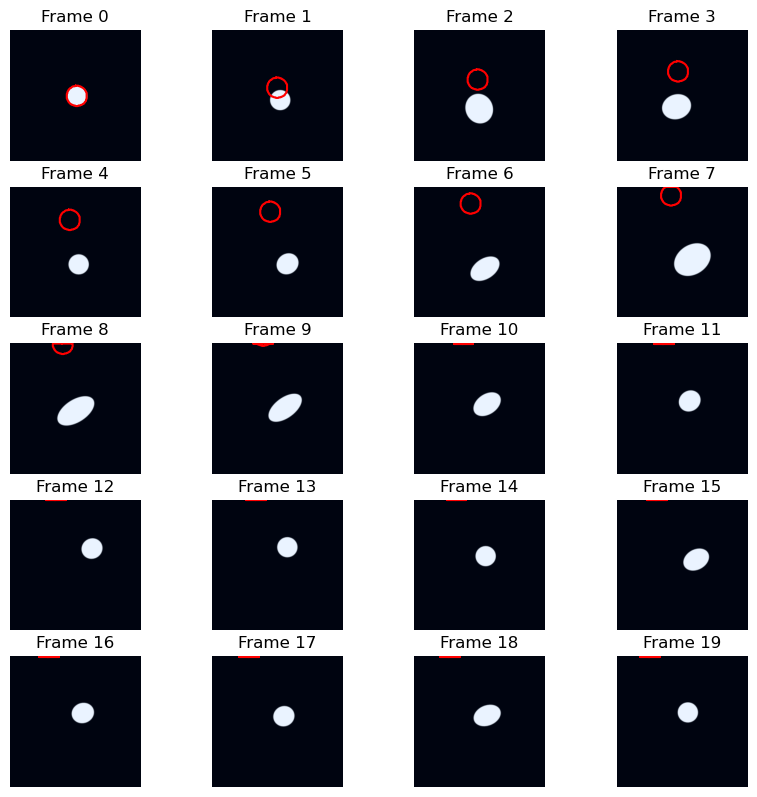

Epoch 720, IOU: 0.058167
Epoch 721, Loss: 252.64
Epoch 722, Loss: 202.21
Epoch 723, Loss: 173.40
Epoch 724, Loss: 206.66
Epoch 725, Loss: 184.37


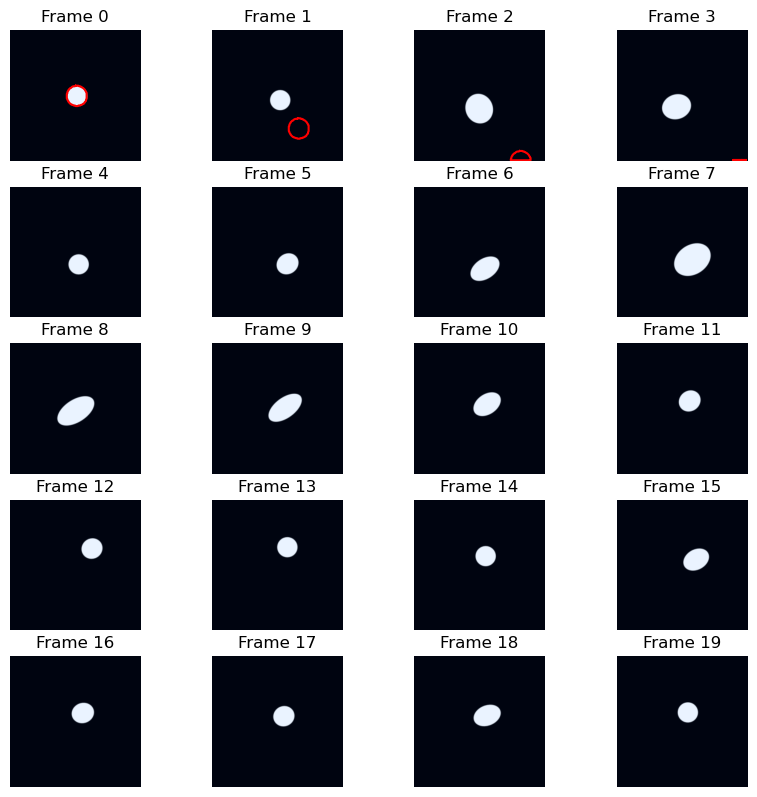

Epoch 725, IOU: 0.049799
Epoch 726, Loss: 548.50
Epoch 727, Loss: 524.08
Epoch 728, Loss: 414.64
Epoch 729, Loss: 458.17
Epoch 730, Loss: 362.67


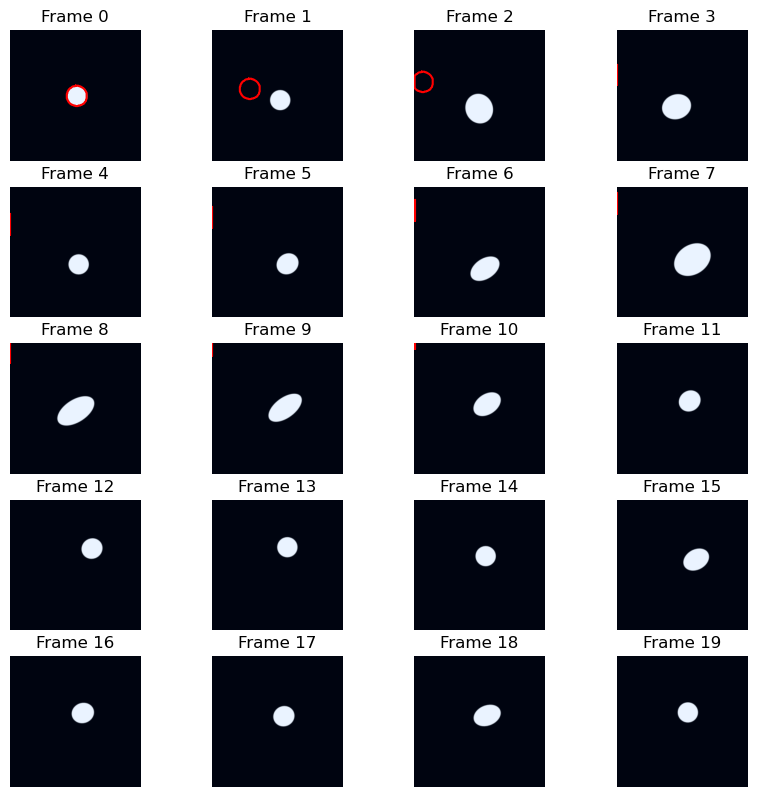

Epoch 730, IOU: 0.049799
Epoch 731, Loss: 460.84
Epoch 732, Loss: 443.10
Epoch 733, Loss: 438.99
Epoch 734, Loss: 406.84
Epoch 735, Loss: 329.50


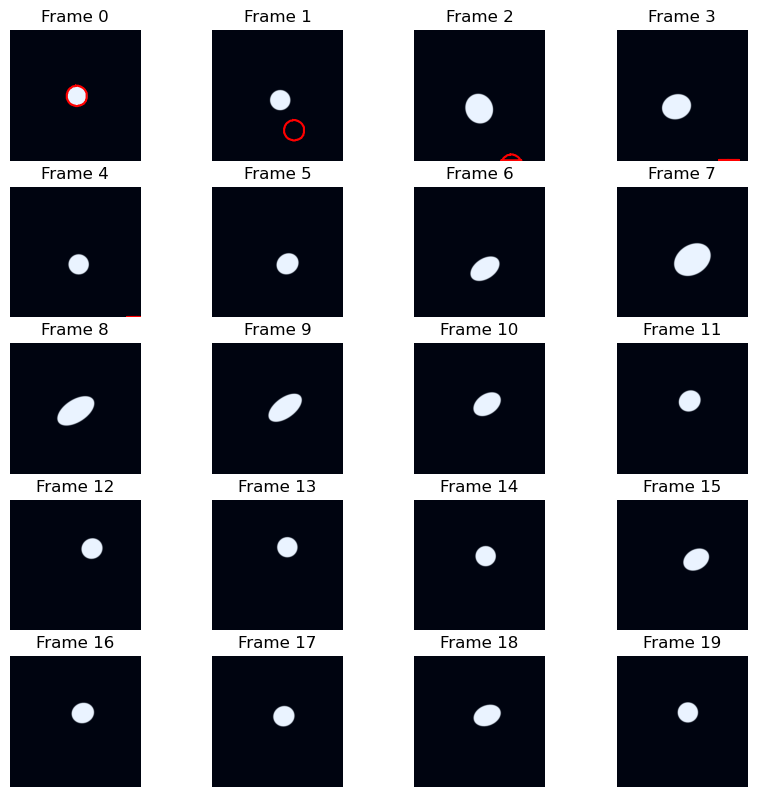

Epoch 735, IOU: 0.049799
Epoch 736, Loss: 428.13
Epoch 737, Loss: 445.74
Epoch 738, Loss: 380.87
Epoch 739, Loss: 428.52
Epoch 740, Loss: 421.04


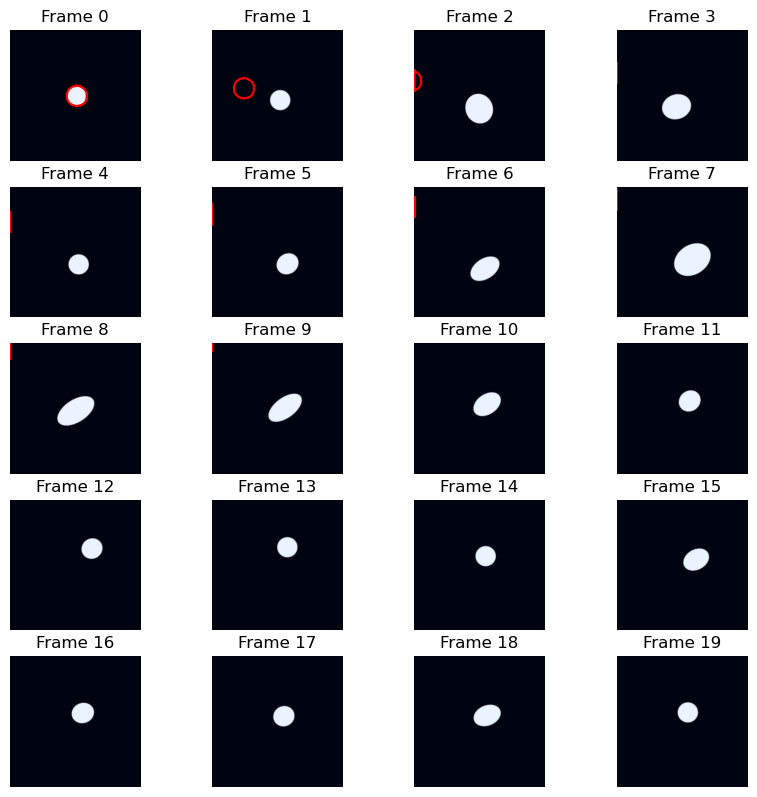

Epoch 740, IOU: 0.049799
Epoch 741, Loss: 489.57
Epoch 742, Loss: 499.63
Epoch 743, Loss: 340.40
Epoch 744, Loss: 422.30
Epoch 745, Loss: 430.61


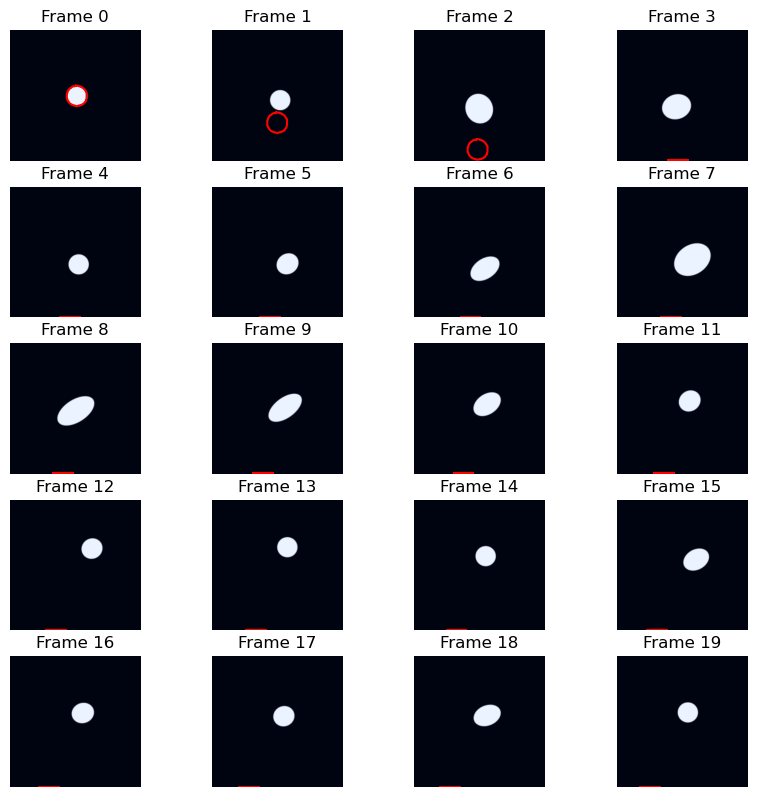

Epoch 745, IOU: 0.049799
Epoch 746, Loss: 337.08
Epoch 747, Loss: 300.80
Epoch 748, Loss: 308.92
Epoch 749, Loss: 339.84
Epoch 750, Loss: 285.87


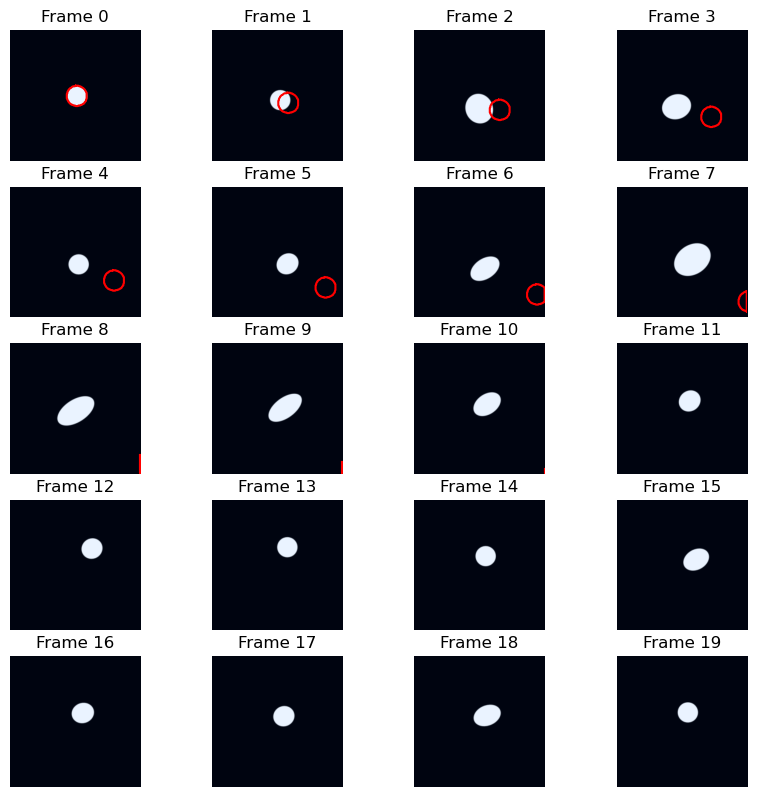

Epoch 750, IOU: 0.067427
Epoch 751, Loss: 313.83
Epoch 752, Loss: 309.69
Epoch 753, Loss: 273.67
Epoch 754, Loss: 254.54
Epoch 755, Loss: 186.50


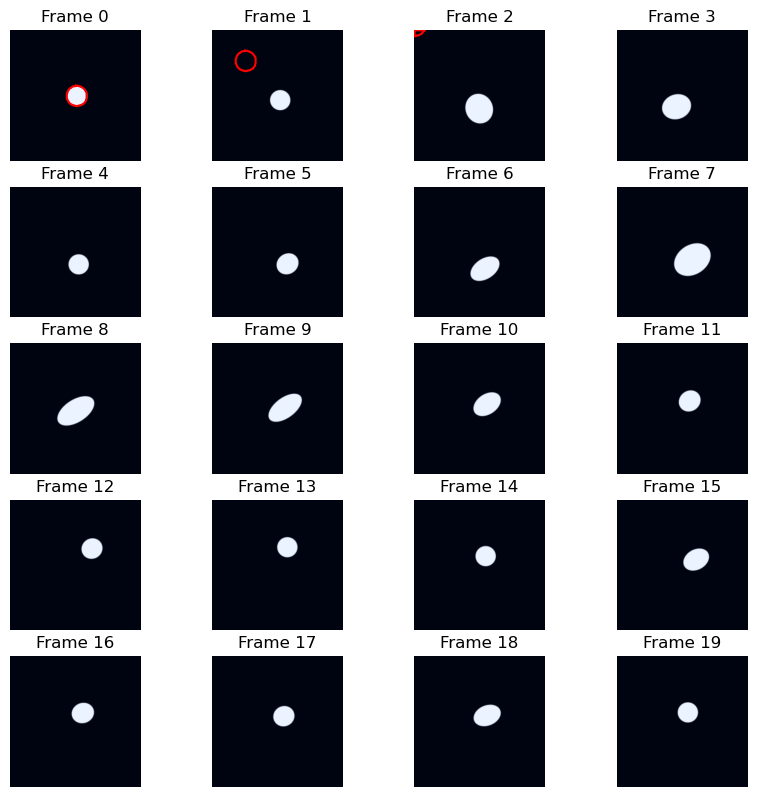

Epoch 755, IOU: 0.049799
Epoch 756, Loss: 604.92
Epoch 757, Loss: 604.64
Epoch 758, Loss: 575.52
Epoch 759, Loss: 512.83
Epoch 760, Loss: 513.76


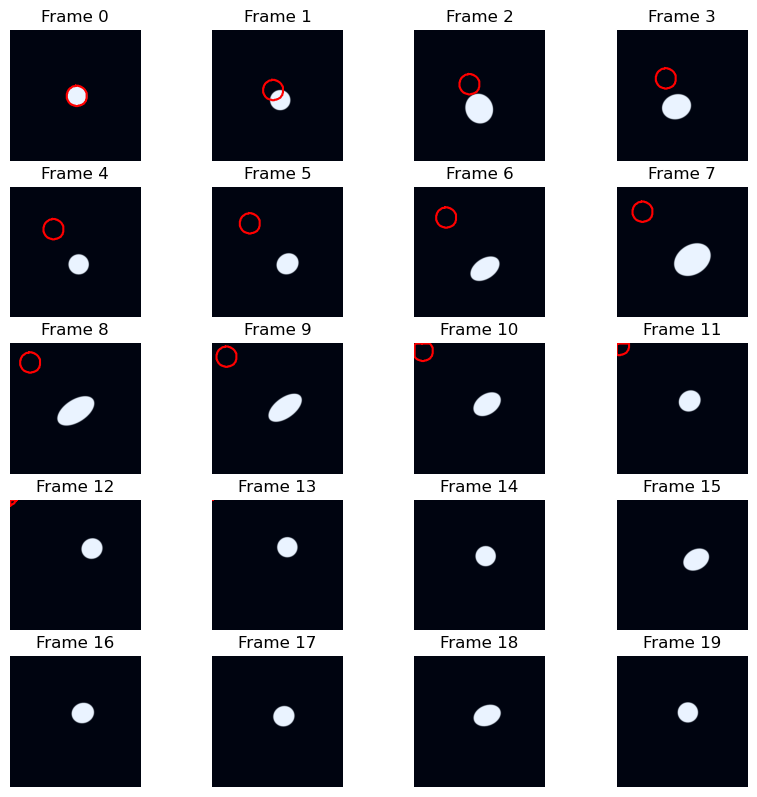

Epoch 760, IOU: 0.058863
Epoch 761, Loss: 260.34
Epoch 762, Loss: 237.18
Epoch 763, Loss: 216.73
Epoch 764, Loss: 212.03
Epoch 765, Loss: 221.77


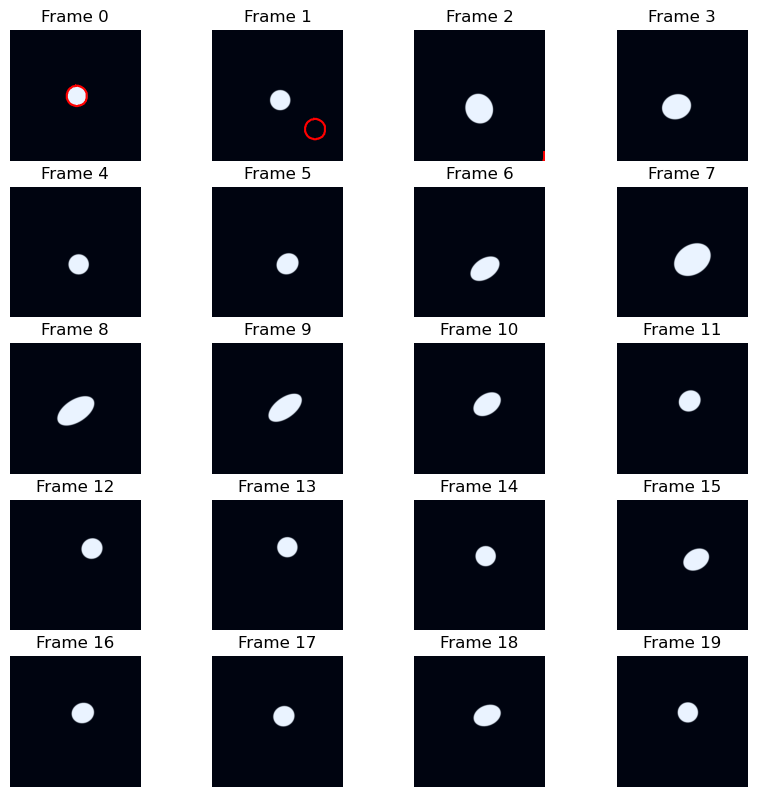

Epoch 765, IOU: 0.049799
Epoch 766, Loss: 567.02
Epoch 767, Loss: 569.53
Epoch 768, Loss: 520.63
Epoch 769, Loss: 468.50
Epoch 770, Loss: 454.95


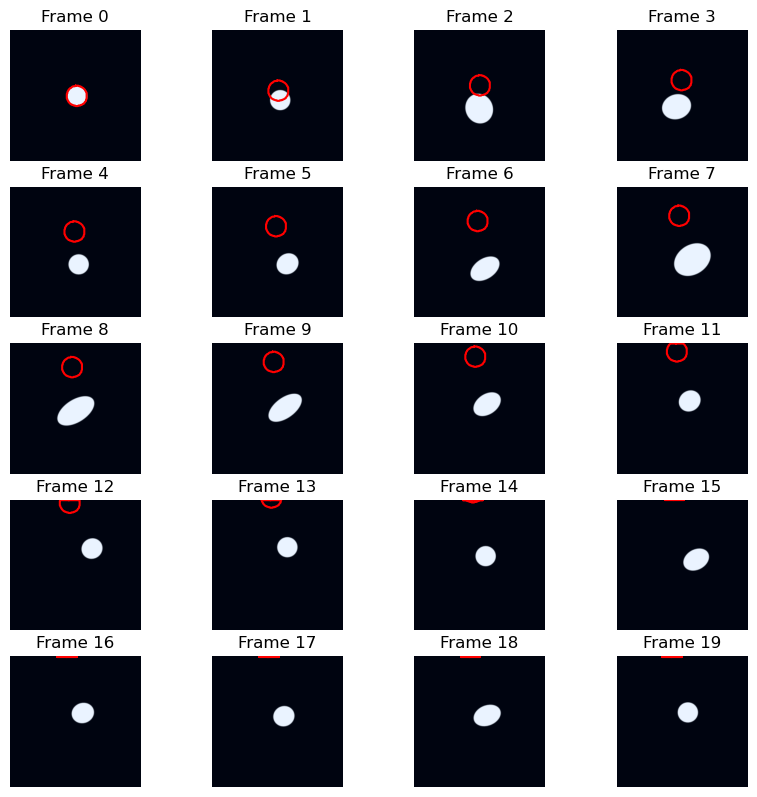

Epoch 770, IOU: 0.064993
Epoch 771, Loss: 181.40
Epoch 772, Loss: 186.55
Epoch 773, Loss: 155.39
Epoch 774, Loss: 136.86
Epoch 775, Loss: 97.30


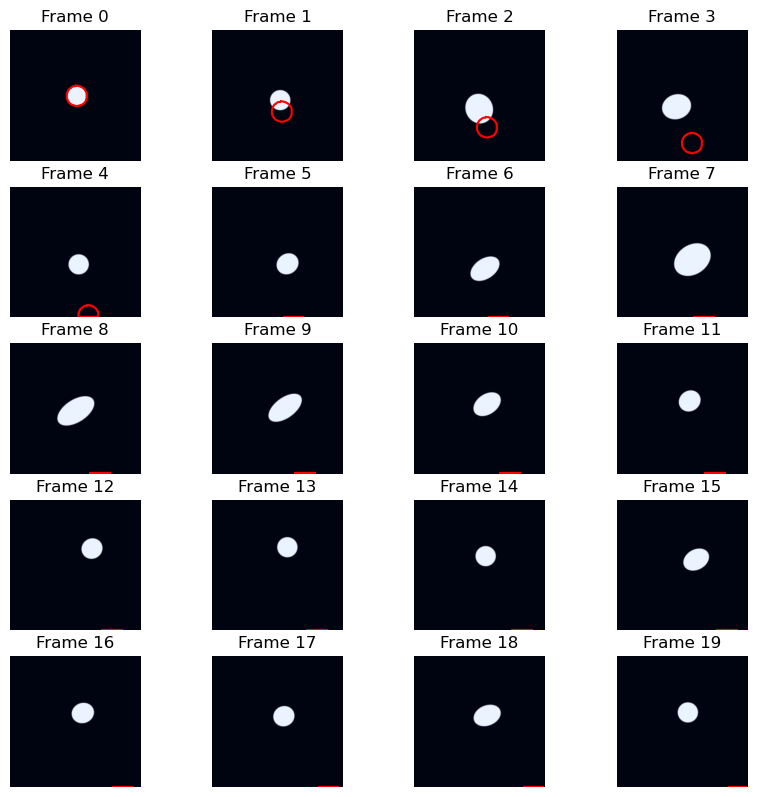

Epoch 775, IOU: 0.061578
Epoch 776, Loss: 296.88
Epoch 777, Loss: 326.91
Epoch 778, Loss: 280.83
Epoch 779, Loss: 234.37
Epoch 780, Loss: 243.02


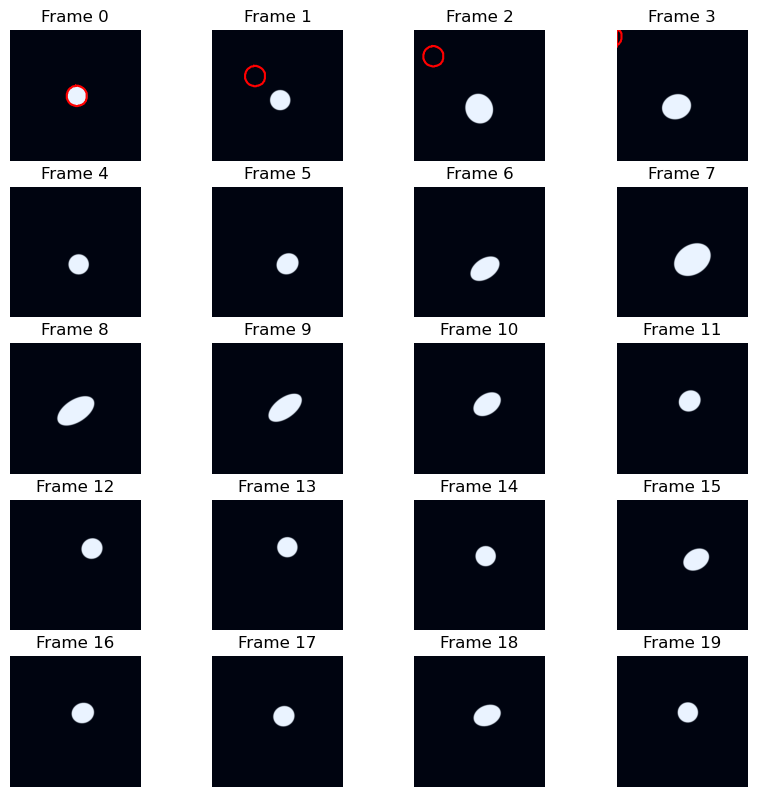

Epoch 780, IOU: 0.049799
Epoch 781, Loss: 515.51
Epoch 782, Loss: 417.00
Epoch 783, Loss: 509.09
Epoch 784, Loss: 505.69
Epoch 785, Loss: 396.27


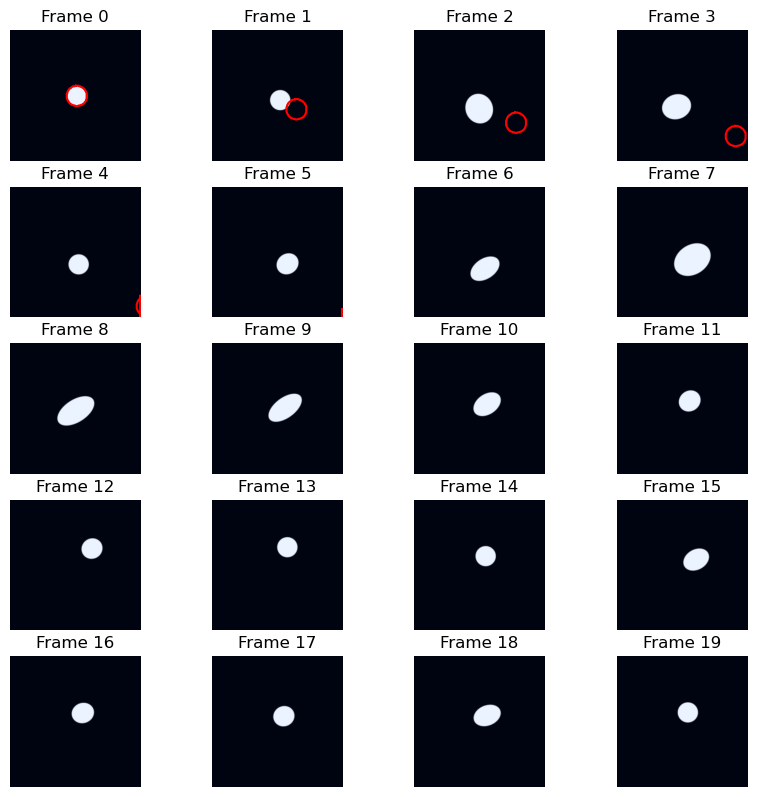

Epoch 785, IOU: 0.050620
Epoch 786, Loss: 519.03
Epoch 787, Loss: 479.66
Epoch 788, Loss: 455.12
Epoch 789, Loss: 363.48
Epoch 790, Loss: 298.41


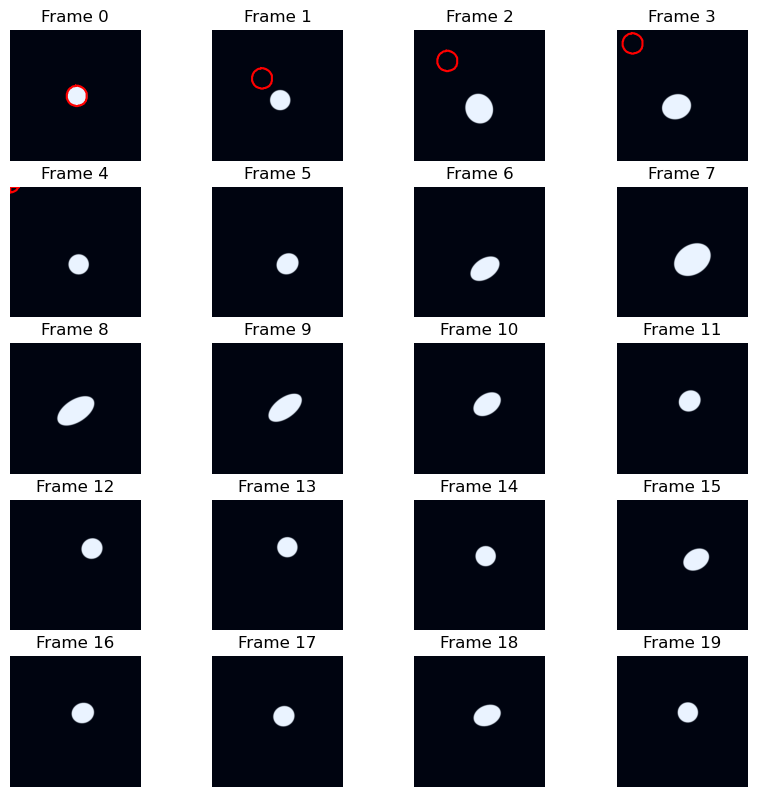

Epoch 790, IOU: 0.049799
Epoch 791, Loss: 542.90
Epoch 792, Loss: 470.25
Epoch 793, Loss: 506.90
Epoch 794, Loss: 402.51
Epoch 795, Loss: 427.97


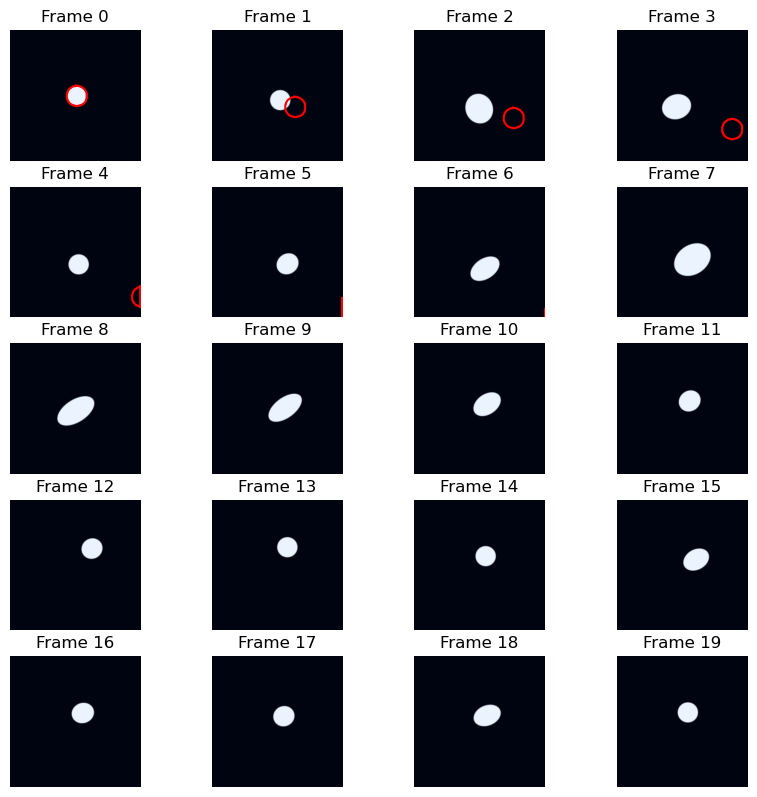

Epoch 795, IOU: 0.052318
Epoch 796, Loss: 459.62
Epoch 797, Loss: 439.38
Epoch 798, Loss: 446.78
Epoch 799, Loss: 294.52
Epoch 800, Loss: 344.01


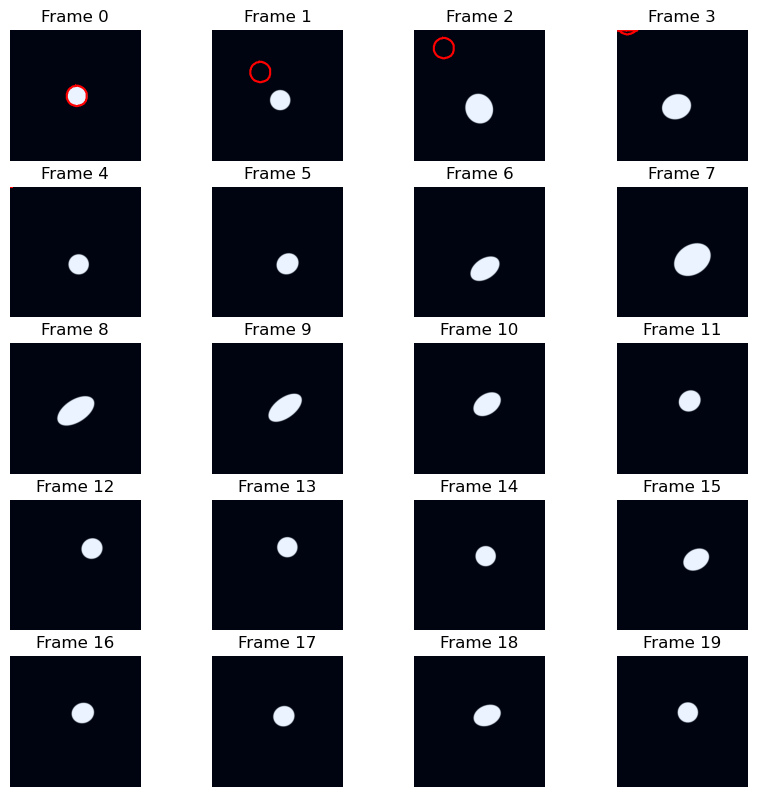

Epoch 800, IOU: 0.049799
Epoch 801, Loss: 507.53
Epoch 802, Loss: 496.25
Epoch 803, Loss: 470.33
Epoch 804, Loss: 429.71
Epoch 805, Loss: 307.50


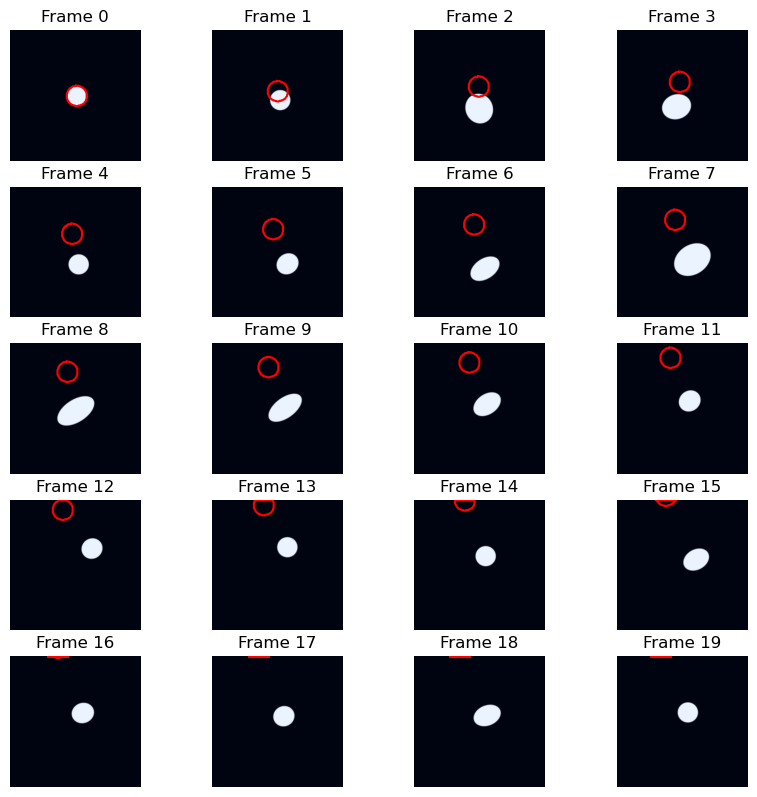

Epoch 805, IOU: 0.066760
Epoch 806, Loss: 177.21
Epoch 807, Loss: 129.78
Epoch 808, Loss: 114.12
Epoch 809, Loss: 121.94
Epoch 810, Loss: 144.22


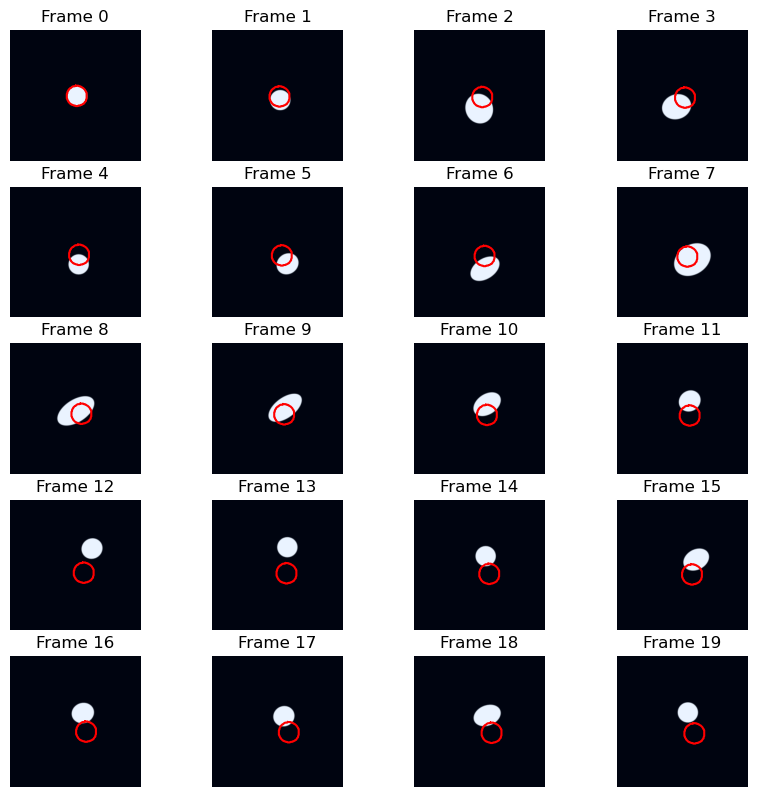

Epoch 810, IOU: 0.223766
Epoch 811, Loss: 126.35
Epoch 812, Loss: 87.07
Epoch 813, Loss: 94.87
Epoch 814, Loss: 61.89
Epoch 815, Loss: 65.07


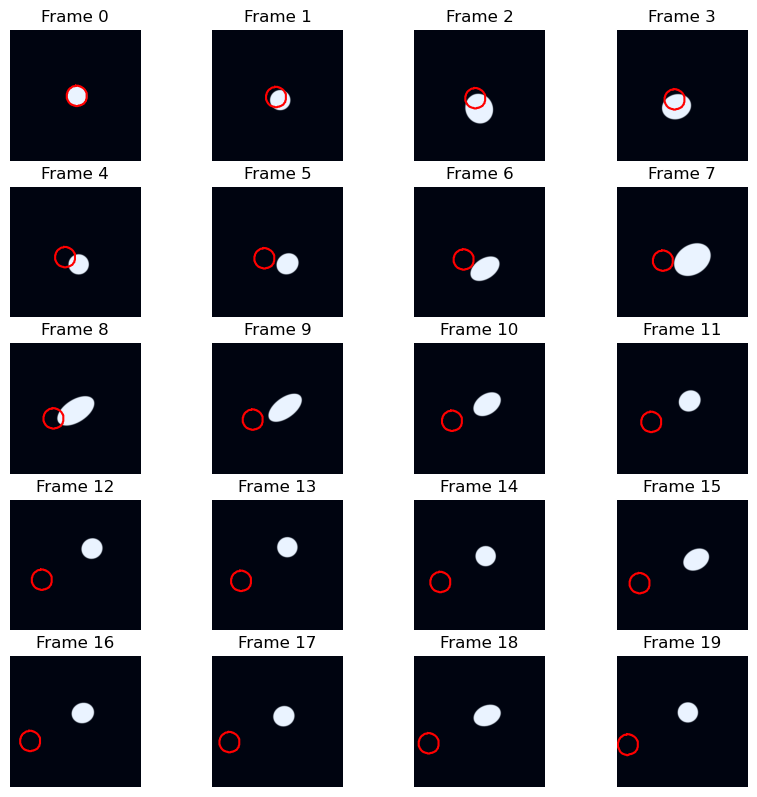

Epoch 815, IOU: 0.118450
Epoch 816, Loss: 120.60
Epoch 817, Loss: 88.48
Epoch 818, Loss: 86.80
Epoch 819, Loss: 116.88
Epoch 820, Loss: 117.10


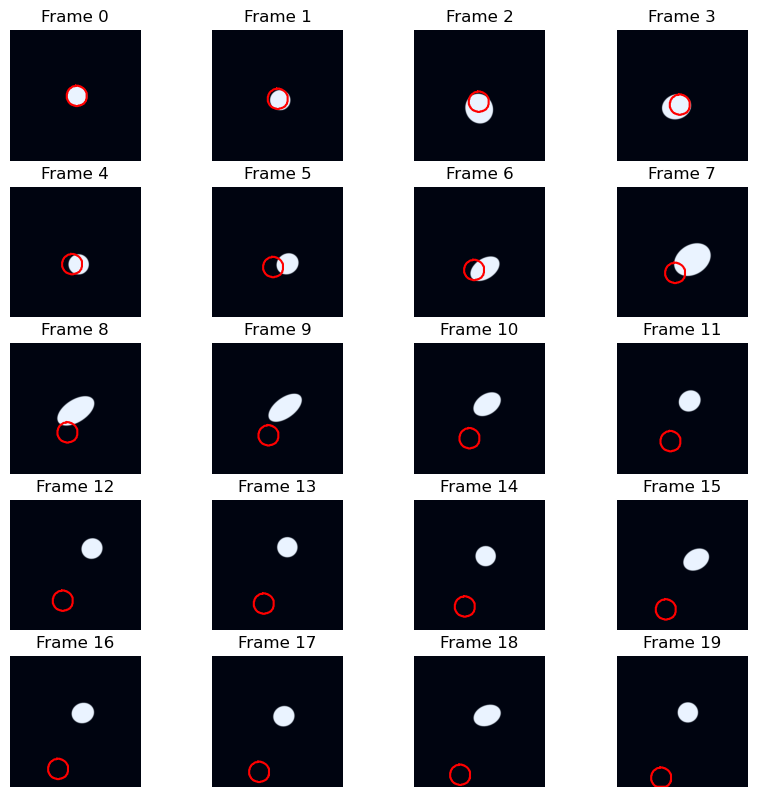

Epoch 820, IOU: 0.187374
Epoch 821, Loss: 113.79
Epoch 822, Loss: 103.61
Epoch 823, Loss: 137.23
Epoch 824, Loss: 117.27
Epoch 825, Loss: 94.32


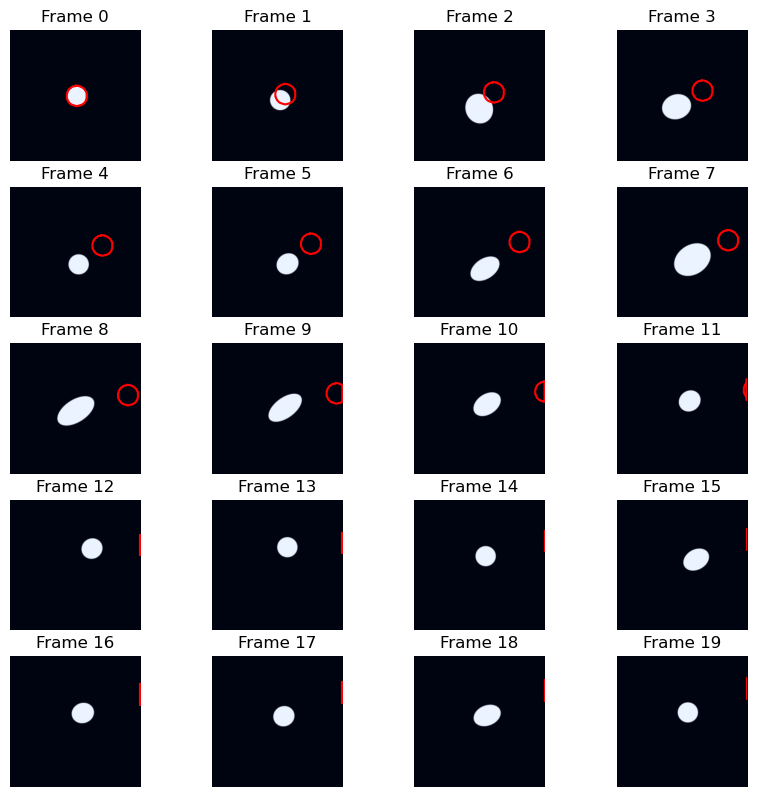

Epoch 825, IOU: 0.069060
Epoch 826, Loss: 176.54
Epoch 827, Loss: 203.07
Epoch 828, Loss: 215.03
Epoch 829, Loss: 211.70
Epoch 830, Loss: 234.60


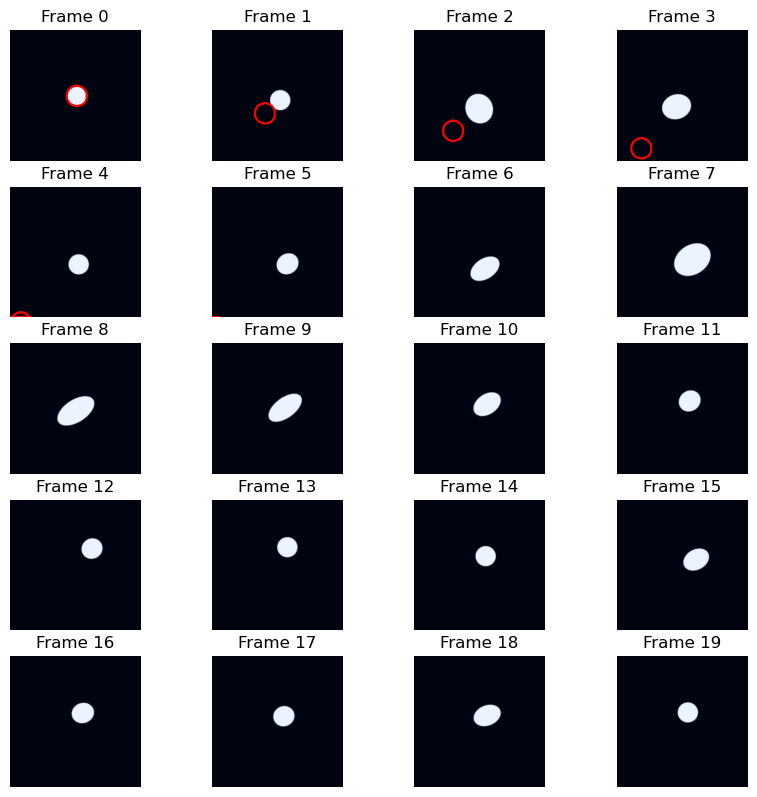

Epoch 830, IOU: 0.049900
Epoch 831, Loss: 525.17
Epoch 832, Loss: 454.68
Epoch 833, Loss: 503.12
Epoch 834, Loss: 418.34
Epoch 835, Loss: 444.93


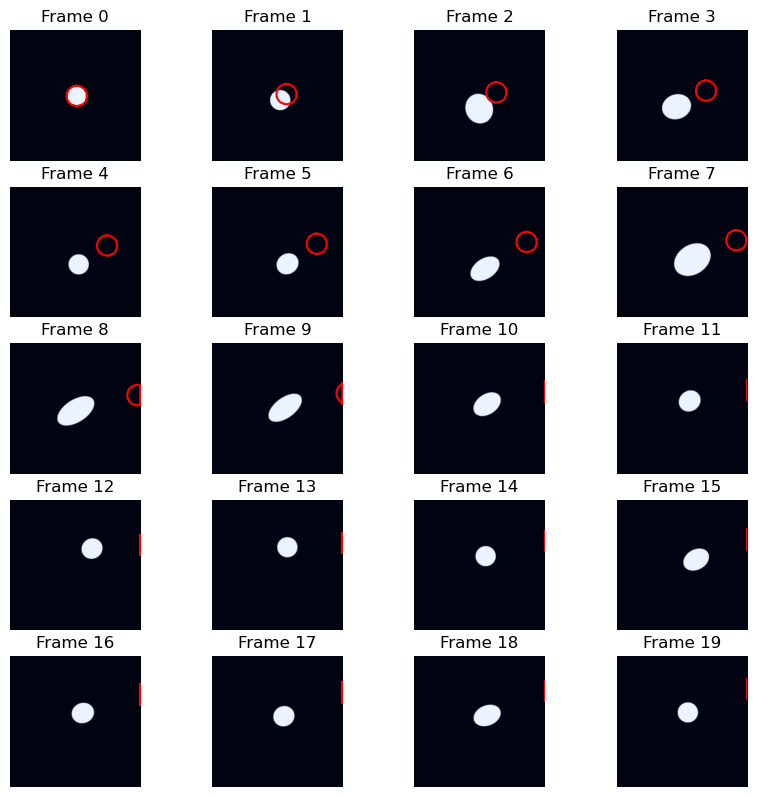

Epoch 835, IOU: 0.066149
Epoch 836, Loss: 235.65
Epoch 837, Loss: 205.23
Epoch 838, Loss: 228.90
Epoch 839, Loss: 257.30
Epoch 840, Loss: 184.79


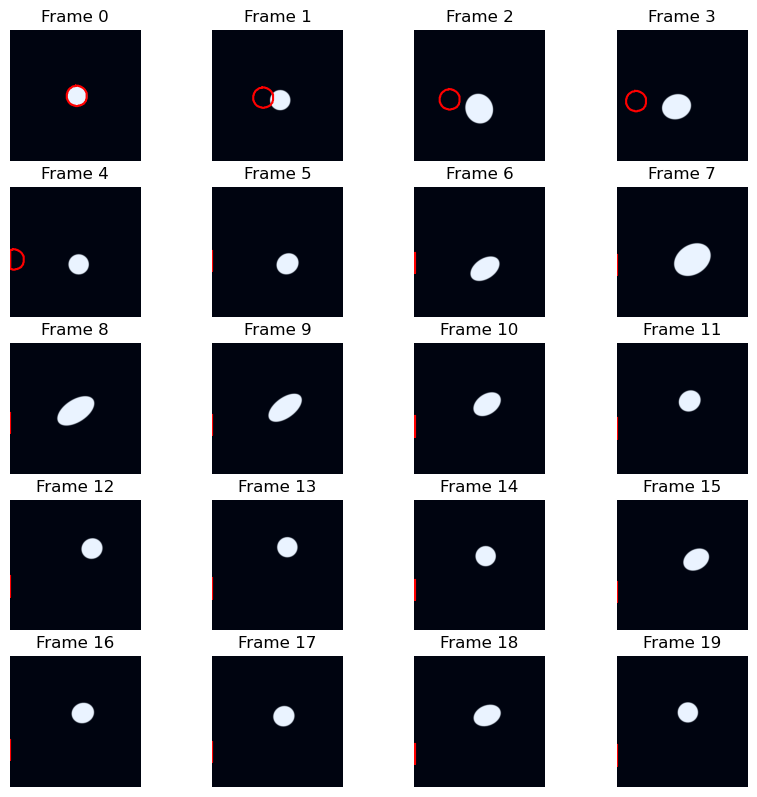

Epoch 840, IOU: 0.052068
Epoch 841, Loss: 302.77
Epoch 842, Loss: 332.35
Epoch 843, Loss: 270.62
Epoch 844, Loss: 218.25
Epoch 845, Loss: 174.95


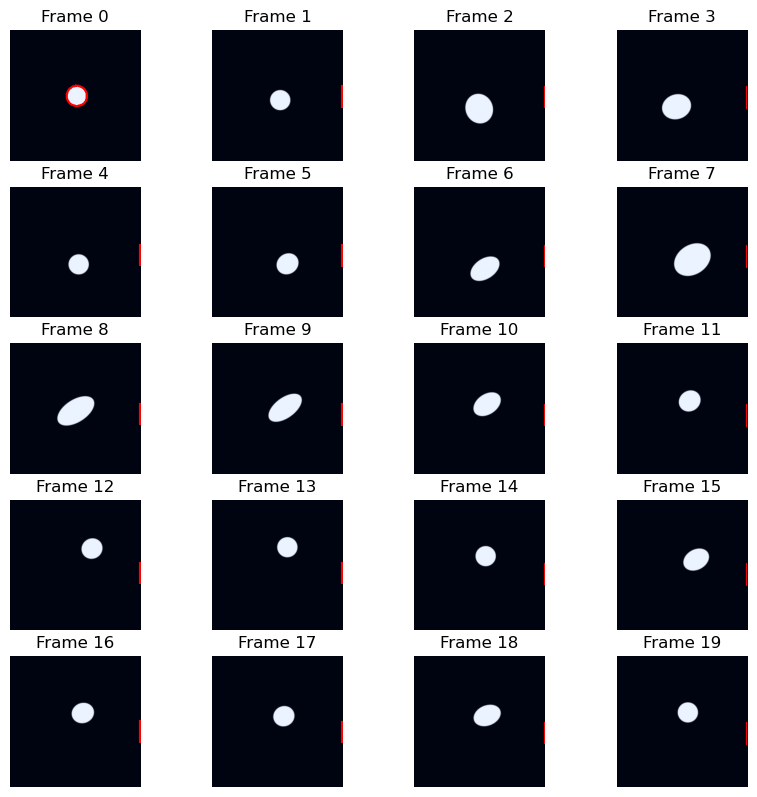

Epoch 845, IOU: 0.049799
Epoch 846, Loss: 281.81
Epoch 847, Loss: 257.38
Epoch 848, Loss: 244.74
Epoch 849, Loss: 227.94
Epoch 850, Loss: 197.87


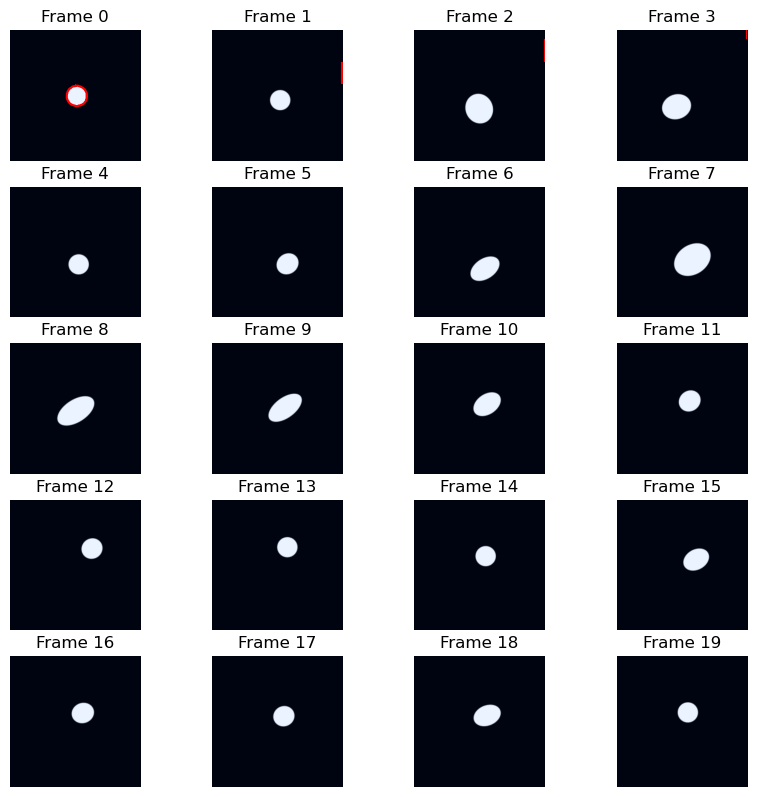

Epoch 850, IOU: 0.049799
Epoch 851, Loss: 373.41
Epoch 852, Loss: 330.81
Epoch 853, Loss: 320.19
Epoch 854, Loss: 234.34
Epoch 855, Loss: 211.91


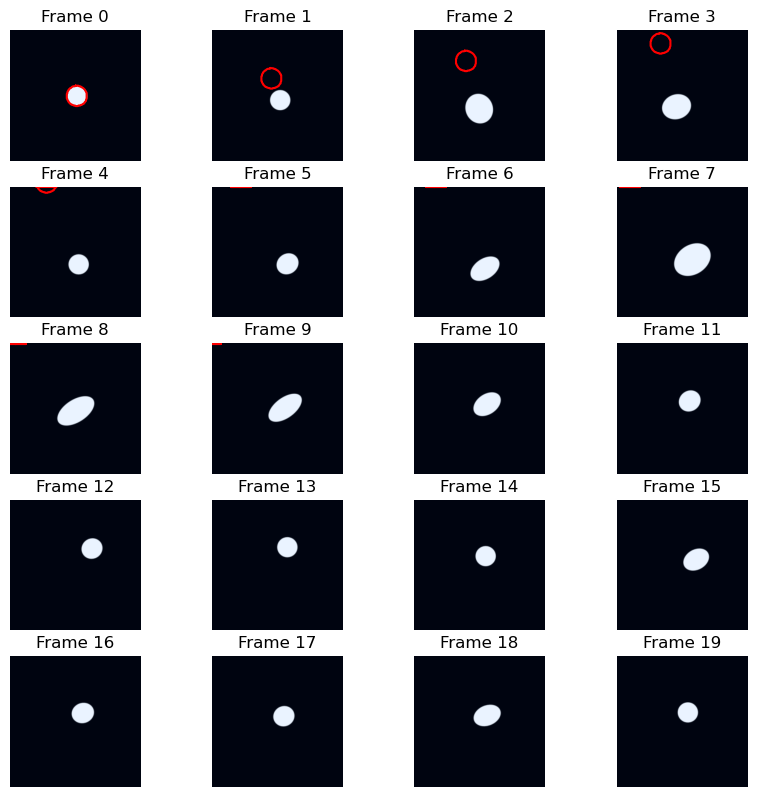

Epoch 855, IOU: 0.049799
Epoch 856, Loss: 366.14
Epoch 857, Loss: 276.74
Epoch 858, Loss: 225.49
Epoch 859, Loss: 186.39
Epoch 860, Loss: 257.87


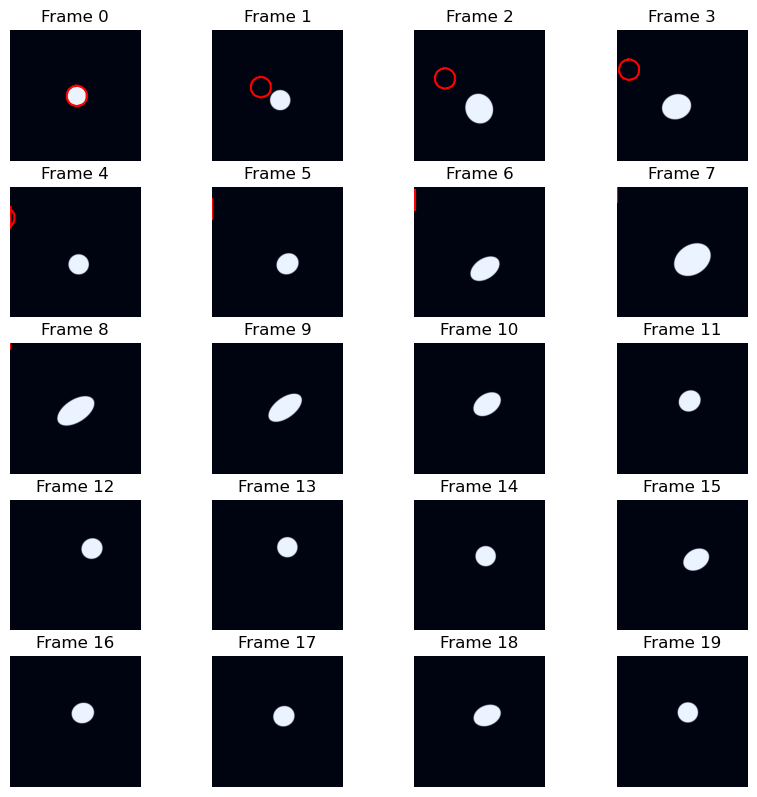

Epoch 860, IOU: 0.049799
Epoch 861, Loss: 221.95
Epoch 862, Loss: 243.62
Epoch 863, Loss: 214.85
Epoch 864, Loss: 234.28
Epoch 865, Loss: 219.69


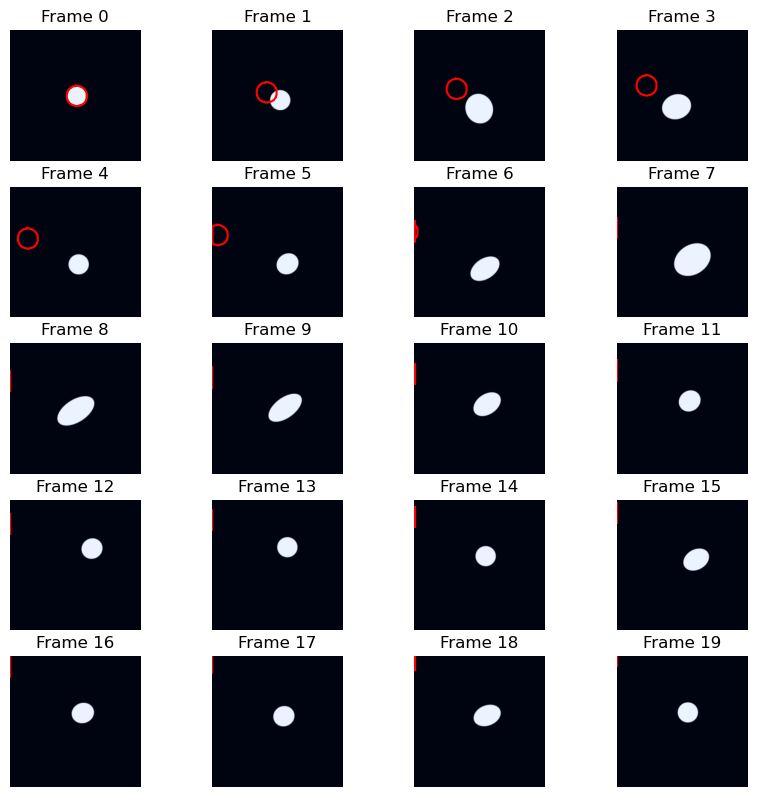

Epoch 865, IOU: 0.053954
Epoch 866, Loss: 240.04
Epoch 867, Loss: 181.47
Epoch 868, Loss: 193.59
Epoch 869, Loss: 186.57
Epoch 870, Loss: 159.35


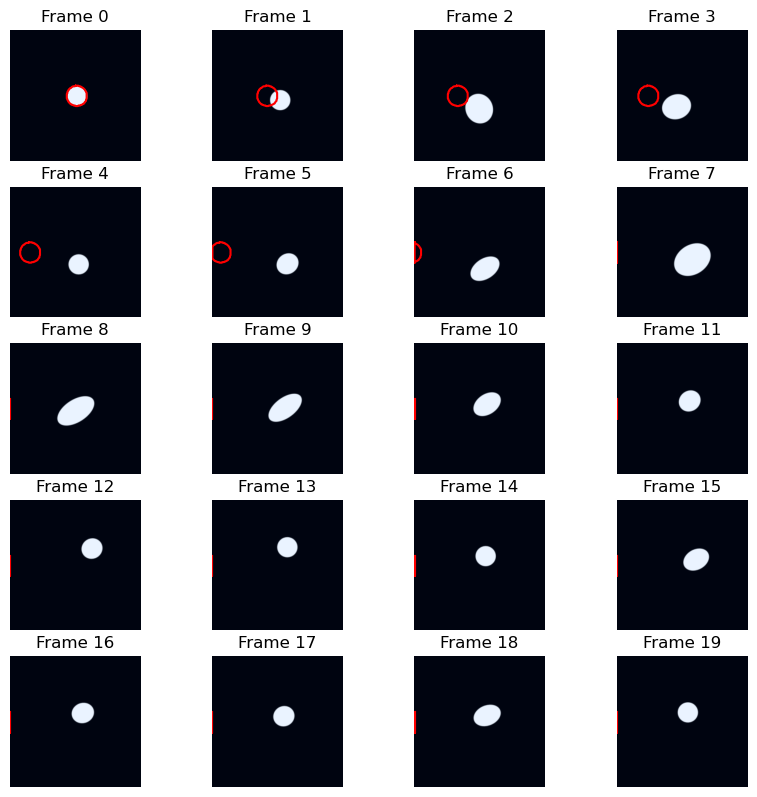

Epoch 870, IOU: 0.056612
Epoch 871, Loss: 168.26
Epoch 872, Loss: 155.94
Epoch 873, Loss: 198.21
Epoch 874, Loss: 153.78
Epoch 875, Loss: 153.34


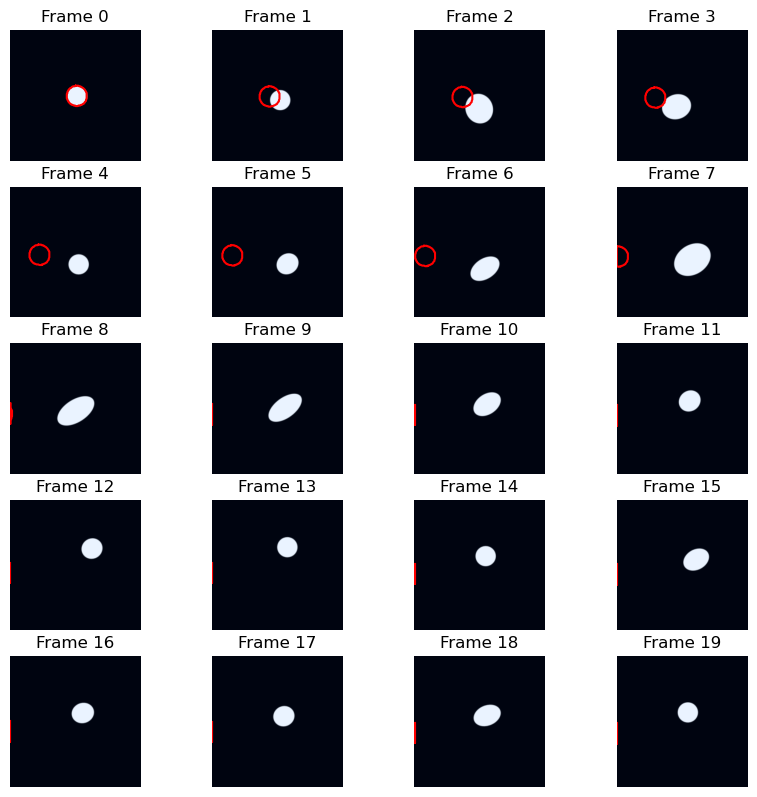

Epoch 875, IOU: 0.063875
Epoch 876, Loss: 163.25
Epoch 877, Loss: 167.01
Epoch 878, Loss: 154.35
Epoch 879, Loss: 155.47
Epoch 880, Loss: 154.99


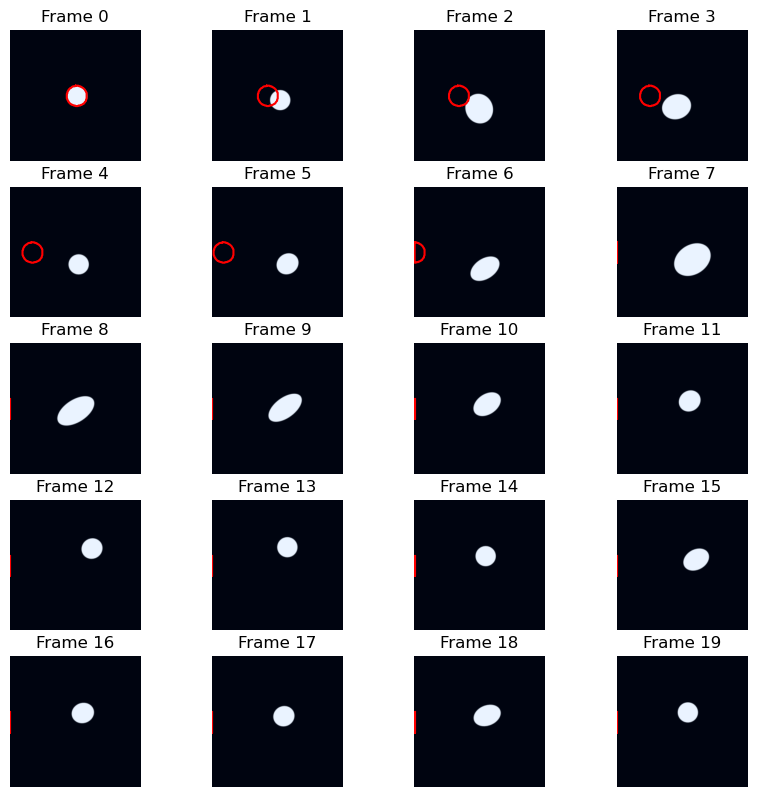

Epoch 880, IOU: 0.057813
Epoch 881, Loss: 146.46
Epoch 882, Loss: 170.86
Epoch 883, Loss: 165.12
Epoch 884, Loss: 137.86
Epoch 885, Loss: 157.13


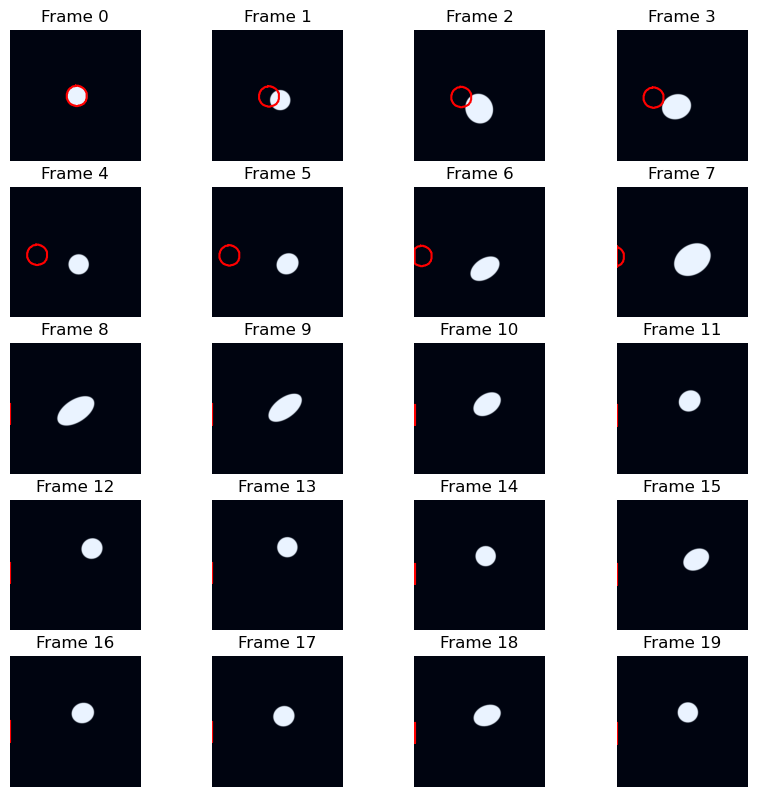

Epoch 885, IOU: 0.061494
Epoch 886, Loss: 144.45
Epoch 887, Loss: 147.91
Epoch 888, Loss: 142.87
Epoch 889, Loss: 149.98
Epoch 890, Loss: 166.24


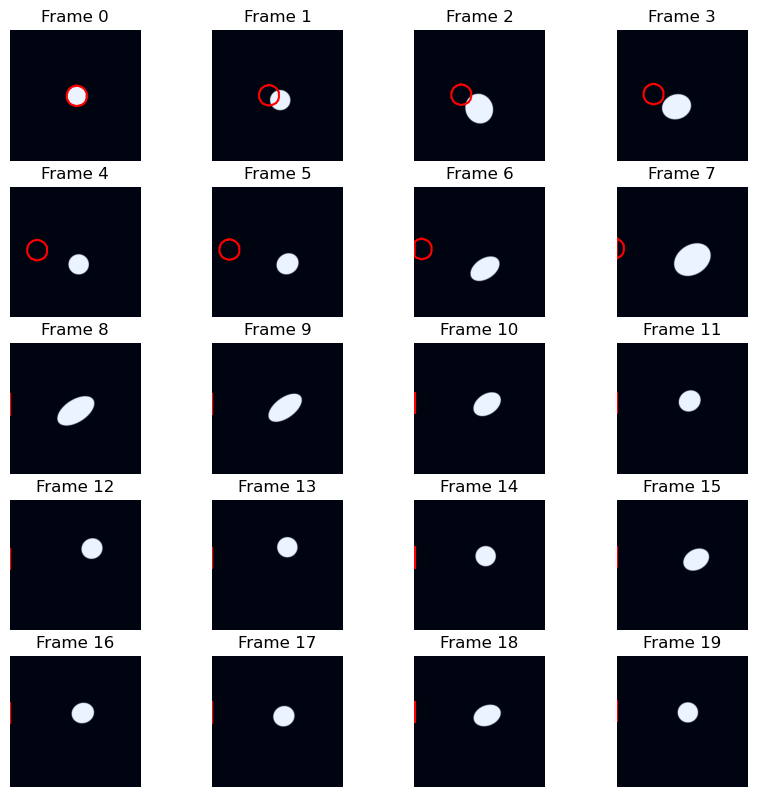

Epoch 890, IOU: 0.059972
Epoch 891, Loss: 153.18
Epoch 892, Loss: 151.13
Epoch 893, Loss: 151.34
Epoch 894, Loss: 146.98
Epoch 895, Loss: 157.36


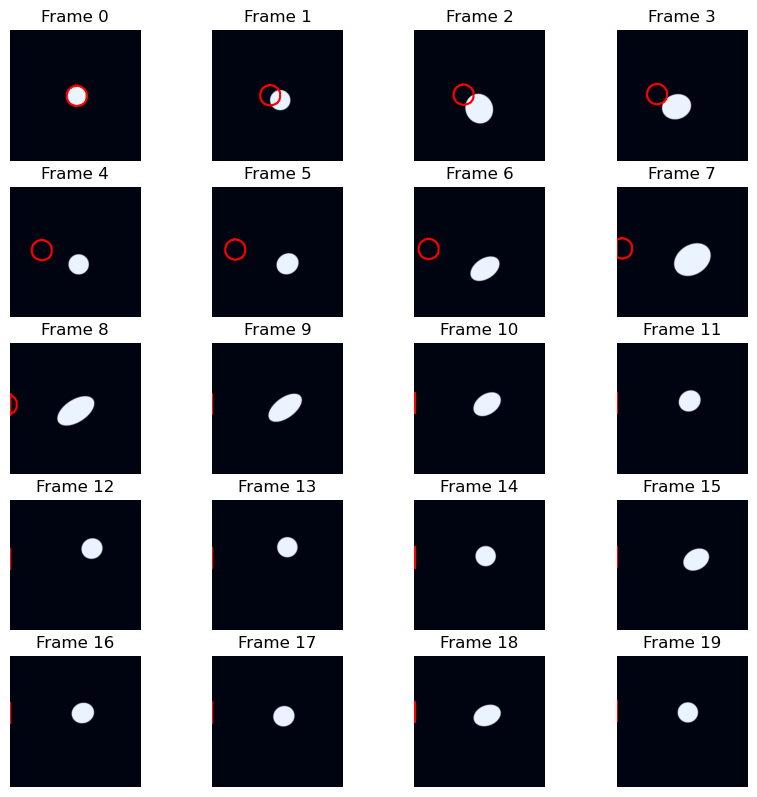

Epoch 895, IOU: 0.063596
Epoch 896, Loss: 170.14
Epoch 897, Loss: 162.71
Epoch 898, Loss: 143.15
Epoch 899, Loss: 144.88
Epoch 900, Loss: 146.77


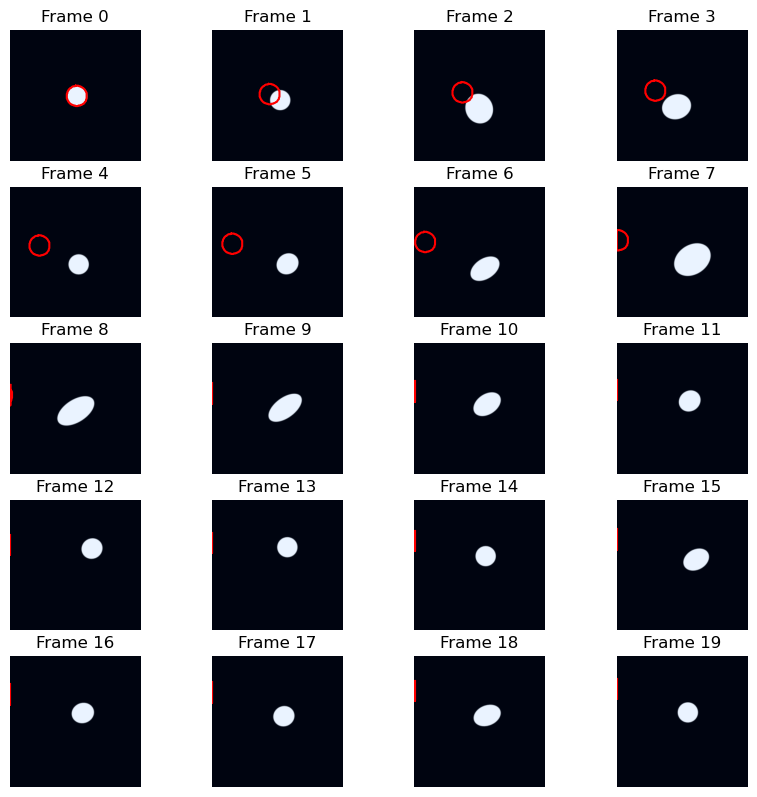

Epoch 900, IOU: 0.059743
Epoch 901, Loss: 152.84
Epoch 902, Loss: 168.01
Epoch 903, Loss: 158.74
Epoch 904, Loss: 172.35
Epoch 905, Loss: 132.32


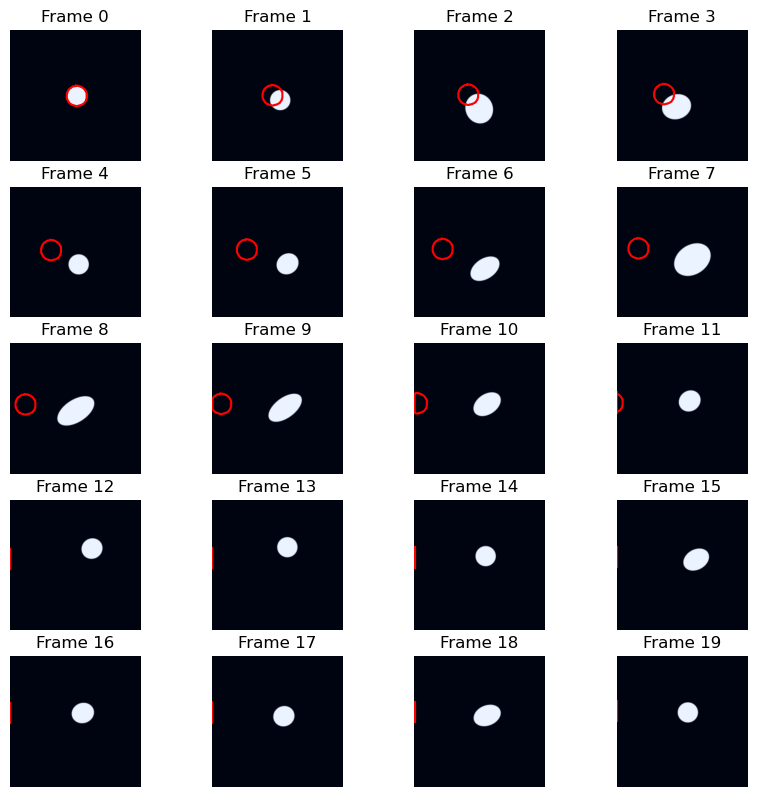

Epoch 905, IOU: 0.074908
Epoch 906, Loss: 138.47
Epoch 907, Loss: 173.24
Epoch 908, Loss: 138.62
Epoch 909, Loss: 149.47
Epoch 910, Loss: 155.12


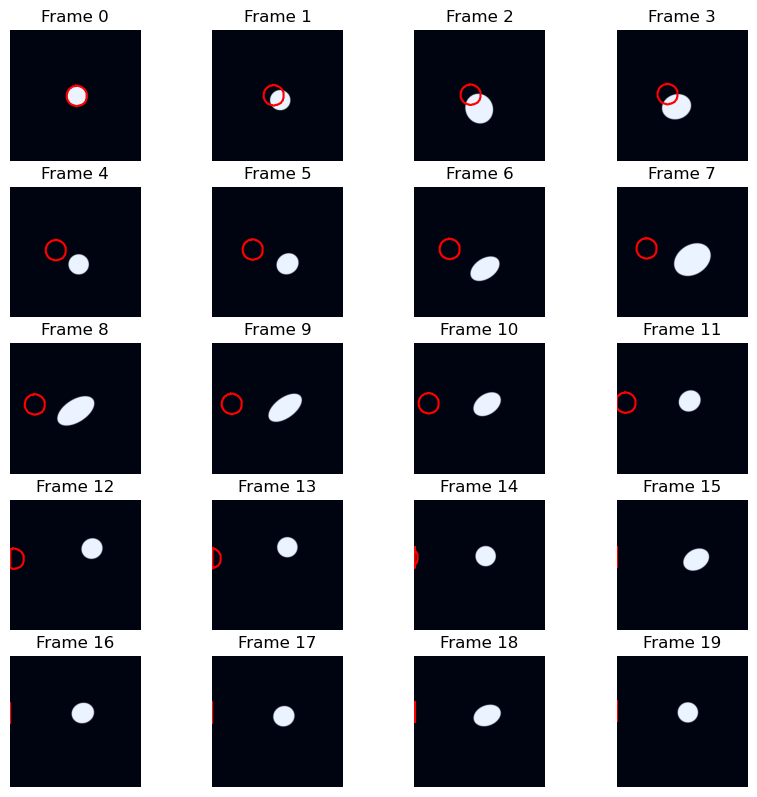

Epoch 910, IOU: 0.081253
Epoch 911, Loss: 138.47
Epoch 912, Loss: 158.31
Epoch 913, Loss: 126.60
Epoch 914, Loss: 139.13
Epoch 915, Loss: 143.02


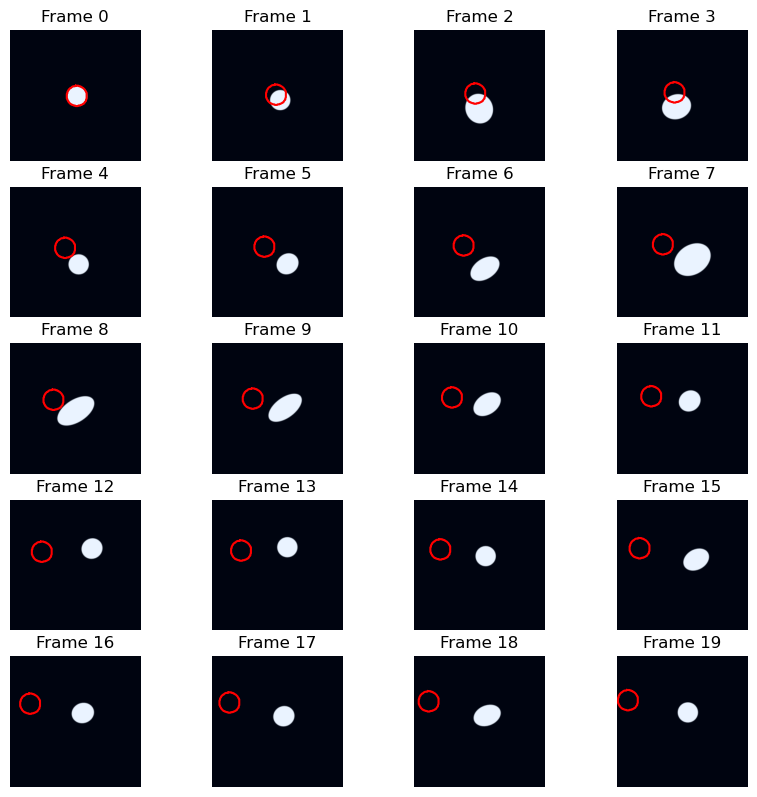

Epoch 915, IOU: 0.086997
Epoch 916, Loss: 122.31
Epoch 917, Loss: 107.34
Epoch 918, Loss: 125.73
Epoch 919, Loss: 104.22
Epoch 920, Loss: 118.86


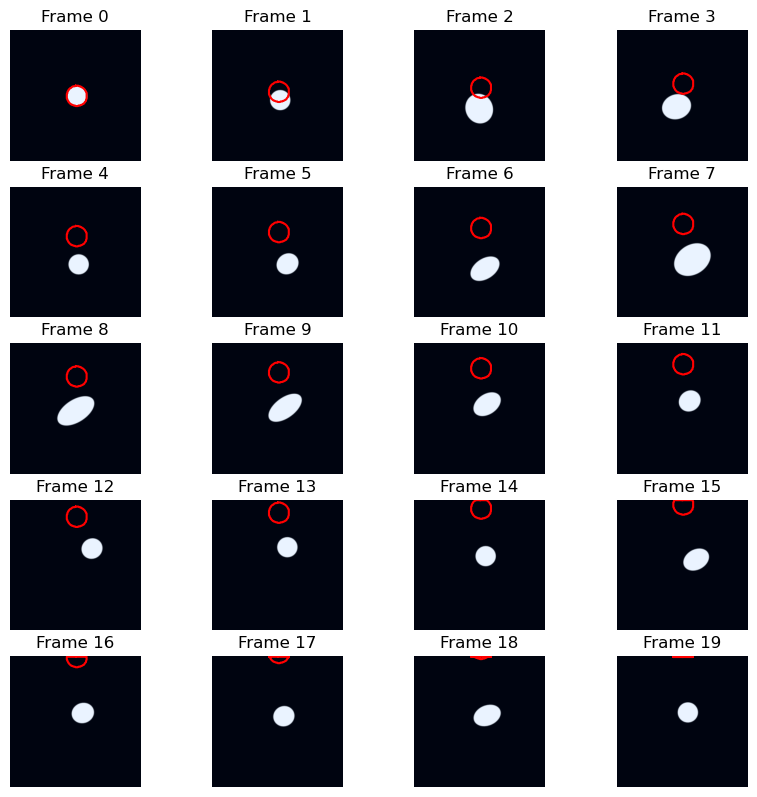

Epoch 920, IOU: 0.069458
Epoch 921, Loss: 146.14
Epoch 922, Loss: 118.51
Epoch 923, Loss: 102.08
Epoch 924, Loss: 135.33
Epoch 925, Loss: 113.93


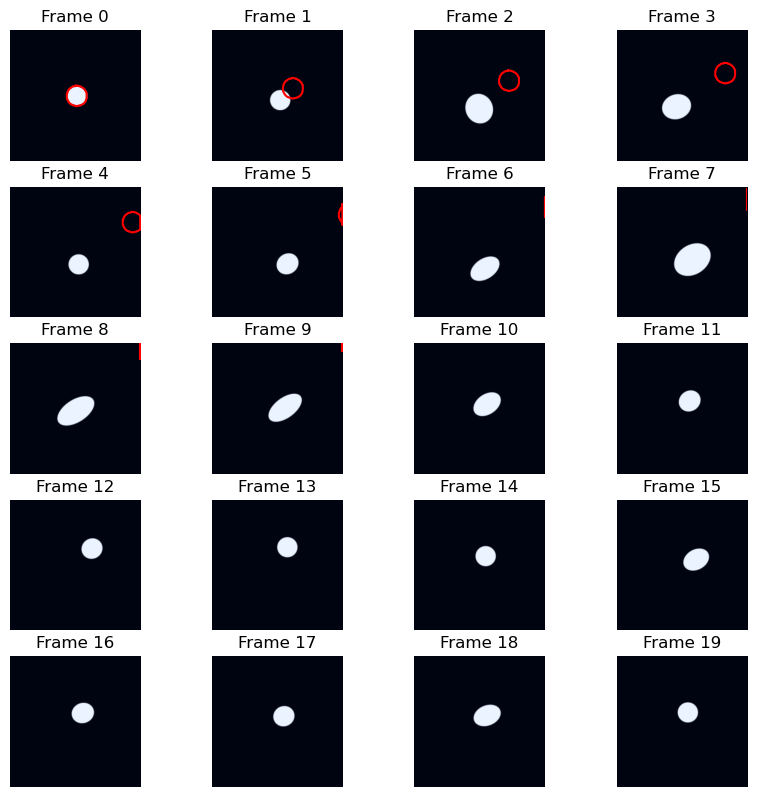

Epoch 925, IOU: 0.051876
Epoch 926, Loss: 286.34
Epoch 927, Loss: 256.86
Epoch 928, Loss: 191.26
Epoch 929, Loss: 195.36
Epoch 930, Loss: 194.79


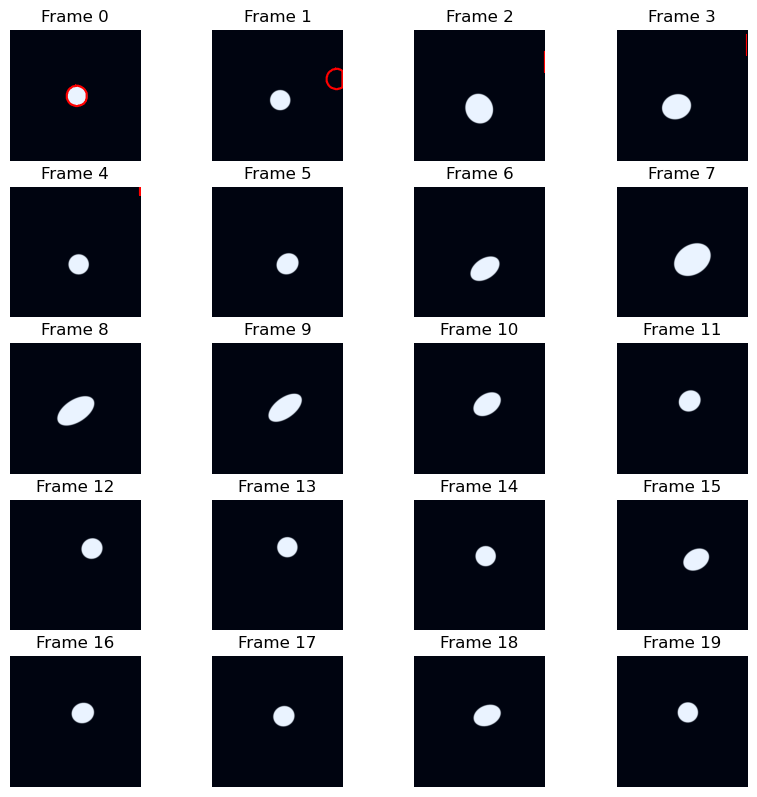

Epoch 930, IOU: 0.049799
Epoch 931, Loss: 177.15
Epoch 932, Loss: 193.24
Epoch 933, Loss: 204.33
Epoch 934, Loss: 175.55
Epoch 935, Loss: 177.88


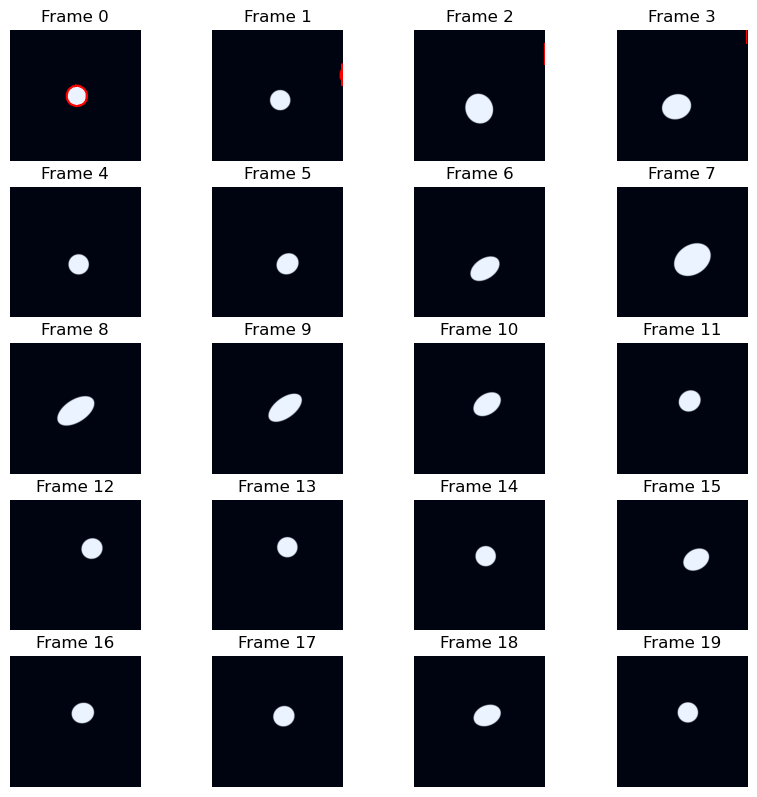

Epoch 935, IOU: 0.049799
Epoch 936, Loss: 171.87
Epoch 937, Loss: 191.20
Epoch 938, Loss: 173.78
Epoch 939, Loss: 205.23
Epoch 940, Loss: 185.01


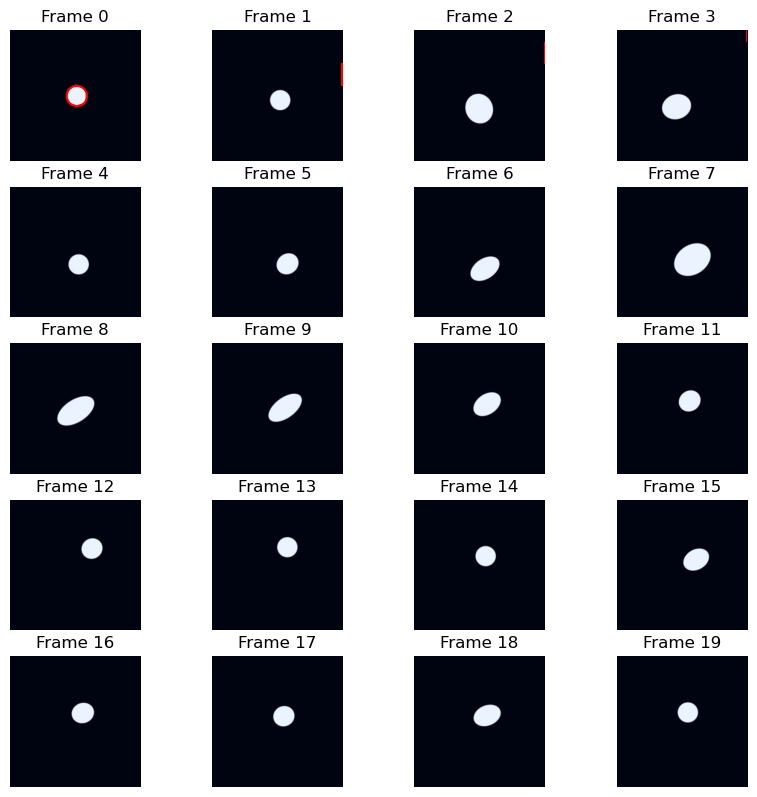

Epoch 940, IOU: 0.049799
Epoch 941, Loss: 177.96
Epoch 942, Loss: 183.62
Epoch 943, Loss: 169.96
Epoch 944, Loss: 171.27
Epoch 945, Loss: 170.84


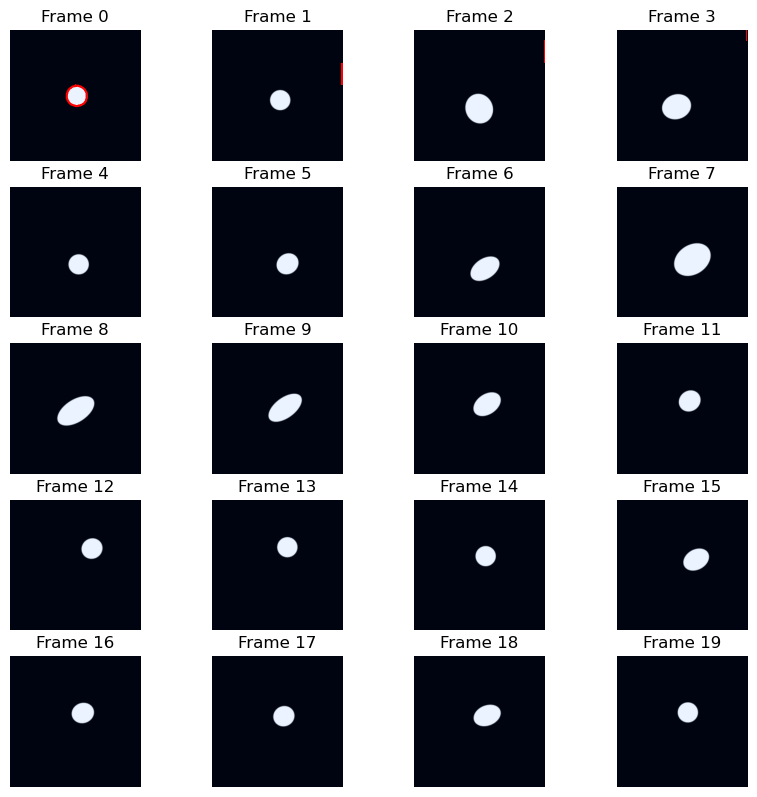

Epoch 945, IOU: 0.049799
Epoch 946, Loss: 195.40
Epoch 947, Loss: 164.32
Epoch 948, Loss: 185.93
Epoch 949, Loss: 175.45
Epoch 950, Loss: 185.95


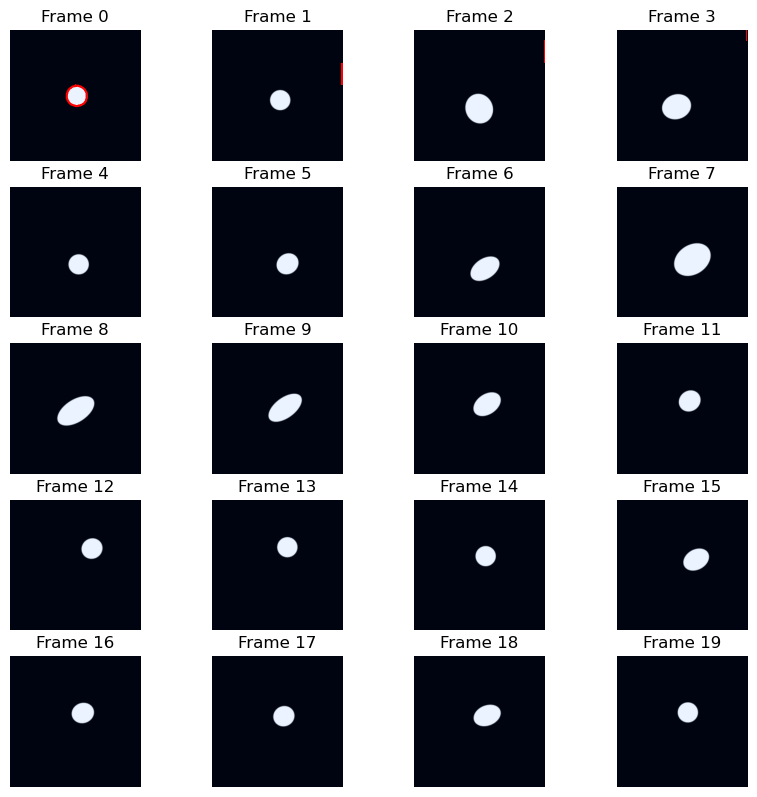

Epoch 950, IOU: 0.049799
Epoch 951, Loss: 173.99
Epoch 952, Loss: 181.97
Epoch 953, Loss: 171.50
Epoch 954, Loss: 179.52
Epoch 955, Loss: 166.82


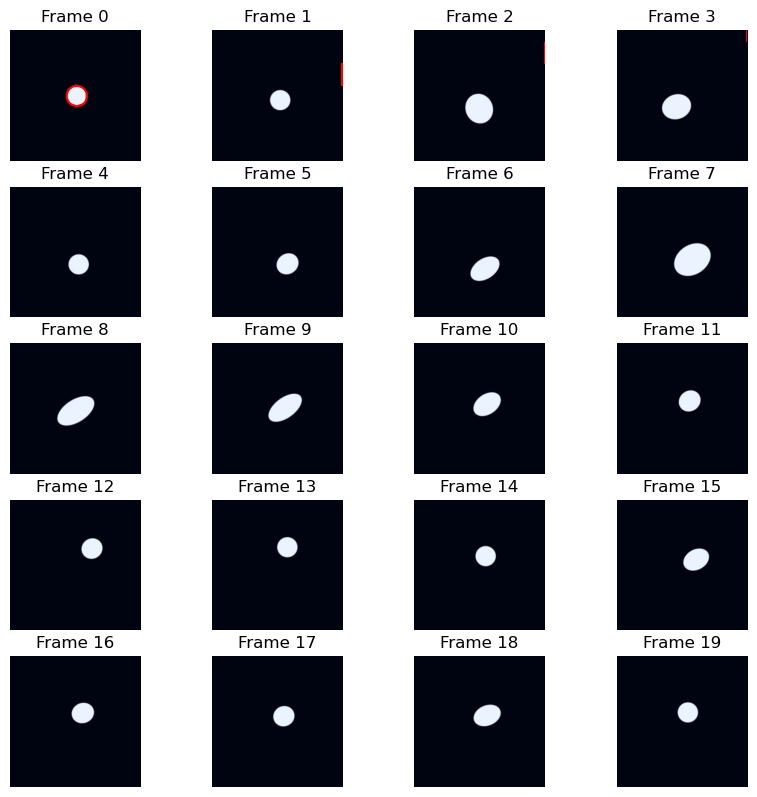

Epoch 955, IOU: 0.049799
Epoch 956, Loss: 183.19
Epoch 957, Loss: 201.85
Epoch 958, Loss: 191.65
Epoch 959, Loss: 168.22
Epoch 960, Loss: 165.09


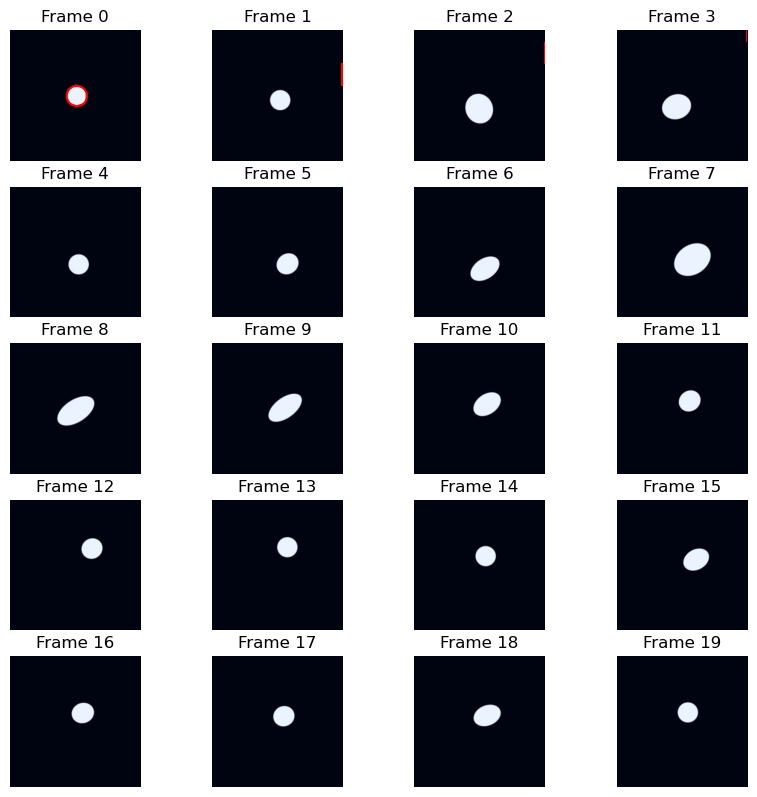

Epoch 960, IOU: 0.049799
Epoch 961, Loss: 204.76
Epoch 962, Loss: 196.09
Epoch 963, Loss: 176.12
Epoch 964, Loss: 209.11
Epoch 965, Loss: 225.32


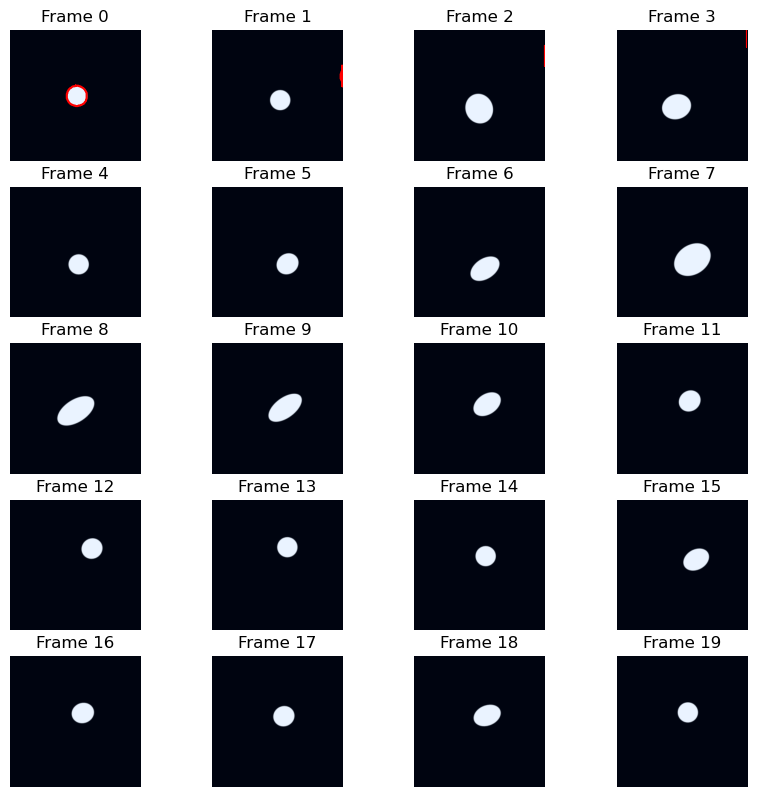

Epoch 965, IOU: 0.049799
Epoch 966, Loss: 211.28
Epoch 967, Loss: 204.69
Epoch 968, Loss: 173.73
Epoch 969, Loss: 165.29
Epoch 970, Loss: 173.40


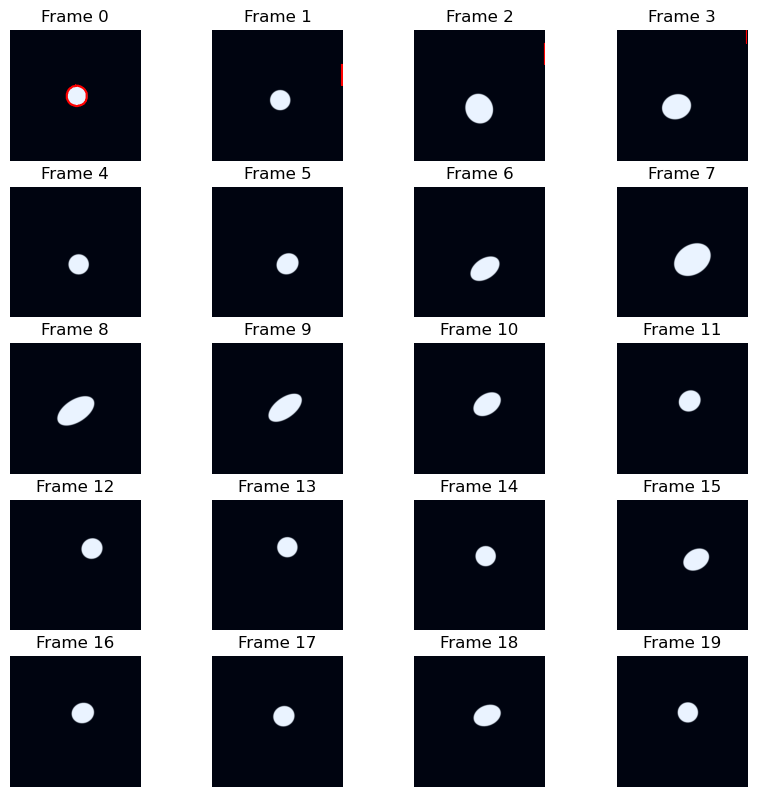

Epoch 970, IOU: 0.049799
Epoch 971, Loss: 167.53
Epoch 972, Loss: 191.44
Epoch 973, Loss: 208.19
Epoch 974, Loss: 193.96
Epoch 975, Loss: 215.90


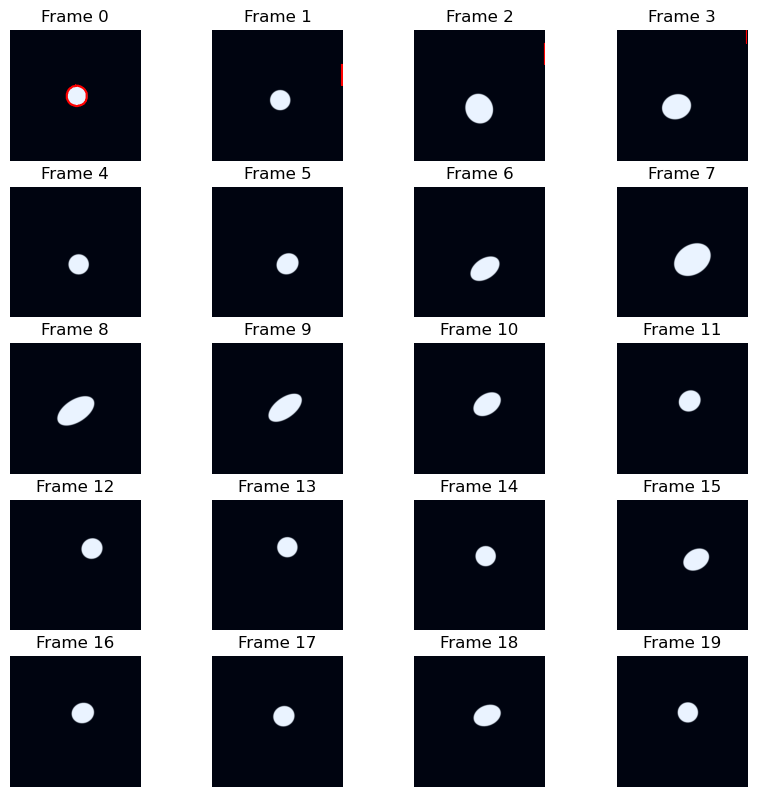

Epoch 975, IOU: 0.049799
Epoch 976, Loss: 179.30
Epoch 977, Loss: 176.89
Epoch 978, Loss: 168.87
Epoch 979, Loss: 192.59
Epoch 980, Loss: 186.90


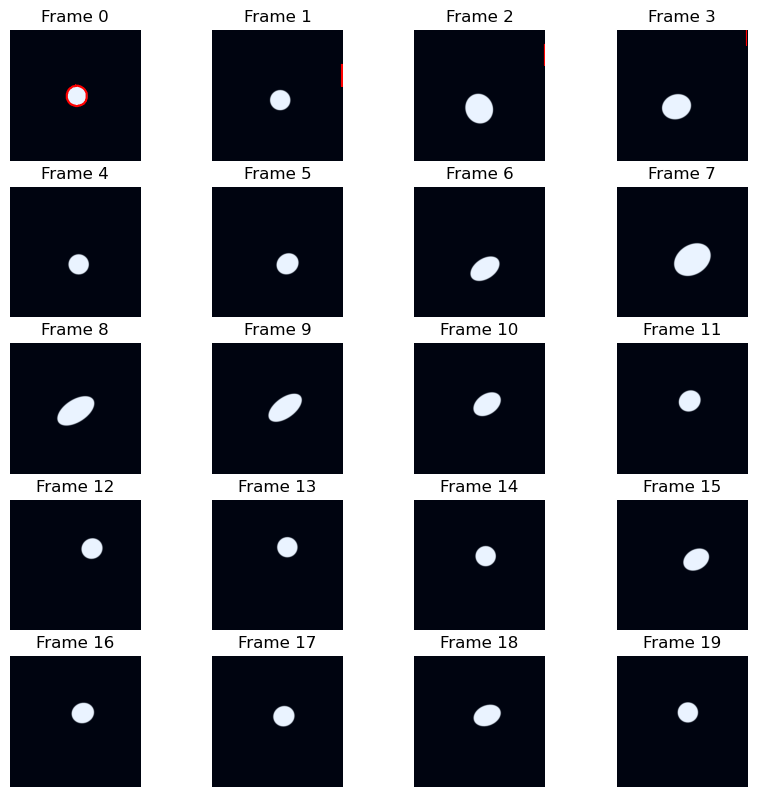

Epoch 980, IOU: 0.049799
Epoch 981, Loss: 183.55
Epoch 982, Loss: 170.45
Epoch 983, Loss: 179.11
Epoch 984, Loss: 170.69
Epoch 985, Loss: 181.37


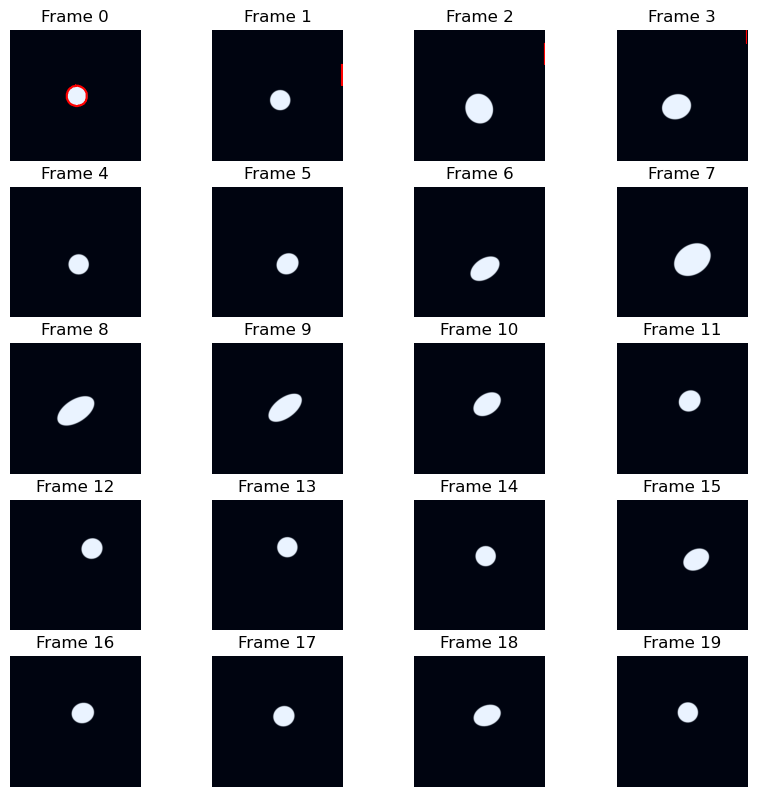

Epoch 985, IOU: 0.049799
Epoch 986, Loss: 165.55
Epoch 987, Loss: 183.80
Epoch 988, Loss: 176.89
Epoch 989, Loss: 190.22
Epoch 990, Loss: 180.21


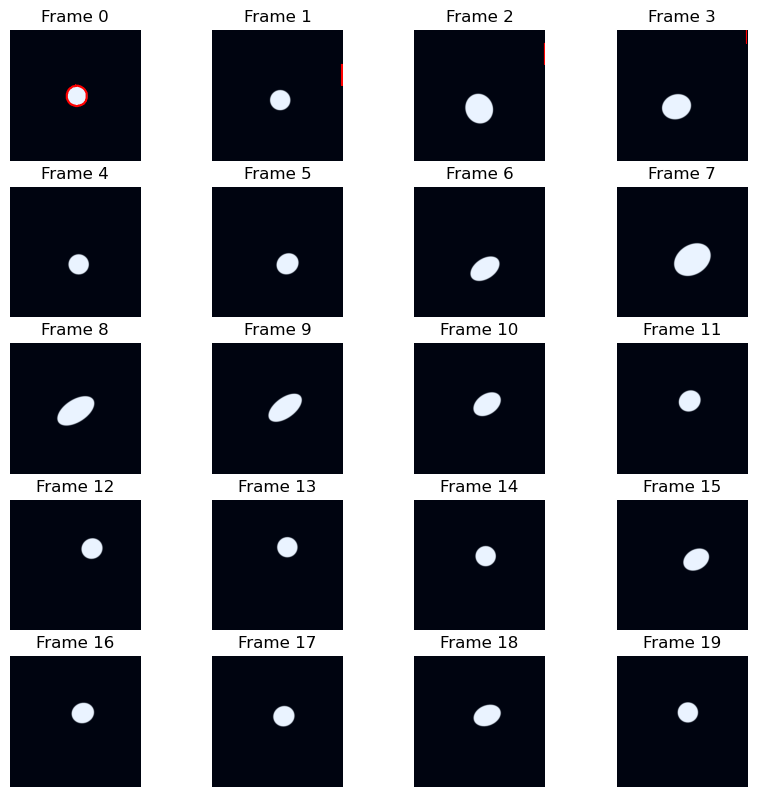

Epoch 990, IOU: 0.049799
Epoch 991, Loss: 208.64
Epoch 992, Loss: 166.46
Epoch 993, Loss: 195.50
Epoch 994, Loss: 167.21
Epoch 995, Loss: 207.48


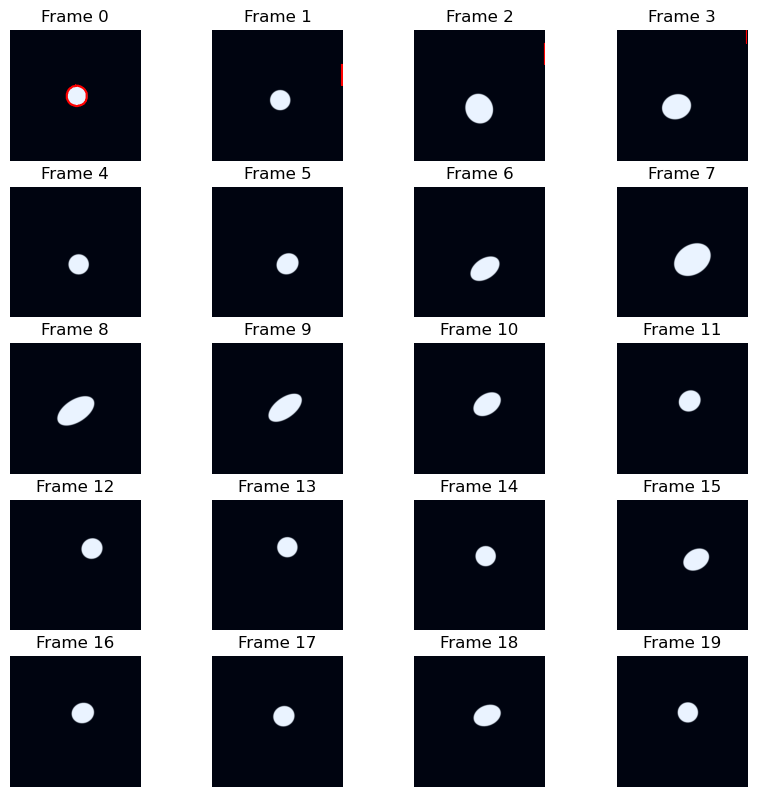

Epoch 995, IOU: 0.049799
Epoch 996, Loss: 170.51
Epoch 997, Loss: 165.42
Epoch 998, Loss: 178.14
Epoch 999, Loss: 185.11
Epoch 1000, Loss: 188.99


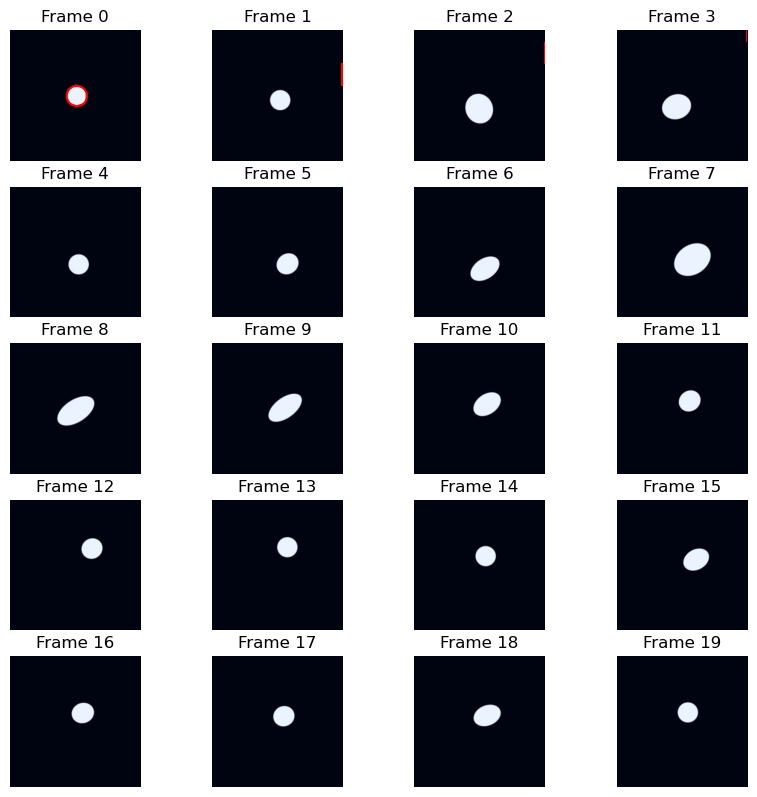

Epoch 1000, IOU: 0.049799


In [23]:
for interval in range(interval_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
            pre_idx = pre_idx.item()
            curr_idx = curr_idx.item()
            pre_boundary = model_infer.get_boundary(pre_idx)
            pre_boundary = pre_boundary.unsqueeze(0).to("cuda")
            first_boundary = first_boundary.to("cuda")
            first_frame, first_boundary, pre_frame, curr_frame, pre_boundary, curr_boundary = (
                first_frame.to("cuda"),
                first_boundary.to("cuda"),
                pre_frame.to("cuda"),
                curr_frame.to("cuda"),
                pre_boundary.to("cuda"),
                curr_boundary.to("cuda"),
            )
            optimizer.zero_grad()
            results = model(first_frame, first_boundary, pre_frame, curr_frame, pre_boundary)
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * loss_func(results[i], curr_boundary)
            mean_loss += loss.item()
            # nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            loss.backward()
            optimizer.step()
        mean_loss /= len(data_loader)
        epoch_index += 1
        print(f"Epoch {epoch_index}, Loss: {mean_loss:.2f}")
        dict_loss[epoch_index] = mean_loss
    model_infer.infer_model(model)
    iou = model_infer.show_infer_result(0)
    dict_iou[epoch_index] = iou
    print(f"Epoch {epoch_index}, IOU: {iou:5f}")
    if interval_epochs > 100:
        interval_epochs = 50
    elif interval_epochs > 5:
        interval_epochs -= 5

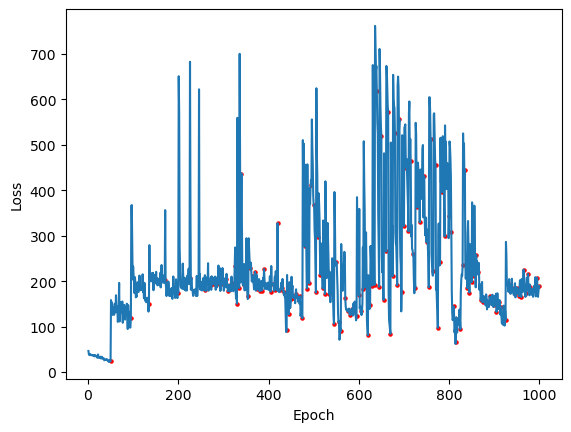

In [24]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plot the update points
plt.scatter(list(dict_iou.keys()), [dict_loss[i] for i in list(dict_iou.keys())], c="r", s=5)
plt.show()

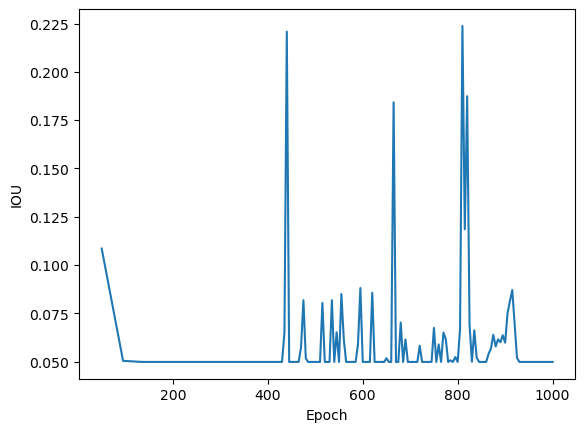

In [25]:
# plot the iou
plt.plot(list(dict_iou.keys()), list(dict_iou.values()))
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.show()